In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys, os, time
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd


from utils.ImagingParametersClass import ImagingParameters
from utils.text_parser import parse_text_file
#from utils.debug import (single_image_analysis, output_debug_summary, 
#                        output_debug_ROIs, output_debug_images, output_debug_single_ROI)

from utils.fastai_helper import acc_segmentation, SegMultiImageList
from utils.summary import create_summary_columns, create_cell_comparisons

import utils.debug as debug

from tkinter import Tk, filedialog

In [3]:
# See your current version of python/anaconda
print (sys.version)

3.7.1 | packaged by conda-forge | (default, Mar 13 2019, 13:32:59) [MSC v.1900 64 bit (AMD64)]









# Step 1 - Load your Config File

This can either be done manually (first cell) or through the dialog boxes (second cell)











In [4]:
#--------------Choose the root to your config files------------

config_root = Path('config')


#--------------Input your config file filename---------------

#config_filename = "config - Single+Br.txt"  #General single colour anisotropy + single brightfield (4 channels)
config_filename = "config - Copy.txt"       #General 16 channel setup (William) 


#--------------Choose the path to your base folder------------
"""User Input"""
data_path = Path(r"D:\William\2019-05-10 INS1E Glucose Dose Response 2 (Manual not Done)")
data_path = Path(r"D:\William\2019-04-30 - INS1E H2O2 and Glucose (Manual Analyzed)")

data_path = Path(r'D:\Huntley\(Manual) 2019.06.01 HomoFRET hPKM2 INS-1Es 2PM Venus K305Q+FUCCI - diamide')

config_path = config_root/config_filename


In [5]:
#---------Run this if you would prefer to choose the files using dialog boxes----------
root = Tk()
default_dir = Path('D:/')
default_dir = Path(r'D:\[] ML Dataset\YOLO Training\YOLO Validation Set - Fluorescence')
#default_dir = Path(r'D:\[] ML Dataset\Datasets\20190412 Org Cyto Hyper')
initial_dir = default_dir if default_dir.exists() else ''
data_path = Path(filedialog.askdirectory(initialdir = initial_dir))
config_path = Path(filedialog.askopenfilename(initialdir = 'config'))
root.destroy()

In [6]:
#-------Variables are loaded from your config file and loaded into the ImagingParameters Class-----

config_variables = parse_text_file (str(config_path))
Parameters = ImagingParameters(data_path = data_path, **config_variables)

#--------Write the parameters file to your folder as a backup--------------------------

with open(Parameters.data_path/'parameters.txt', "w") as txt_file:
    for key, value in config_variables.items():
        txt_file.write(f'{key} = {value}\n')

#-------Output the variables here for reference---------------------------

if Parameters.debug_mode == True:
    print("Loaded the following variables:")
    for variables in config_variables:
        print(f'{variables: <25}: {config_variables[variables]}')  

C:\Users\Rocheleau Microscope\Google Drive\Python Analysis\config\config - 40X - Merge 10 Channels.txt
unknown variables found: same_cells
unknown variables found: single_detection_mode
unknown variables found: cell_segmentation_weights
['channel_array', 'channel_thresholds', 'suffix', 'machine_learning_mode', 'ROI_match_threshold']


INFO       Loaded weights from weights\YOLO\20190810FluorescenceOnly.pt


0.15017702870564203 0.004776014352821042 0.8450469569415368
Loaded the following variables:
channel_array            : [3, 7]
image_type_array         : ['Anisotropy', 'Brightfield']
channel_thresholds       : [5000, 5000, 5000, 0]
same_cells               : True
root_dir_same_treatment  : True
suffix                   : ome.tif
machine_learning_mode    : True
manual_boxing            : False
debug_mode               : True
segmentation_outputs     : False
numerical_aperture       : 0.75
index_of_refraction      : 1.0
magnification            : 40.0
gFactor                  : 1.0
max_neighborhood_size    : 80
max_threshold            : 1000.0
local_max_avg_radius     : 4
thresh_tolerance         : 0.5
IoU_match_thresh         : 0.8
ROI_match_threshold      : 0.4
min_ROI_size             : 40
single_detection_mode    : Detect
detection_channels       : [0, 3, 6]
weights_path             : weights\YOLO\20190810FluorescenceOnly.pt
classes                  : 20
network_size             : [

## Step 2 - Check that the experiment is organized in the way that you want

In [7]:
#--------------Prints out Information about your experiment--------------------------------

Parameters.print_experiment_summary()

Your Experiment will be organized as follows:

Experiment 0 is: 01  - T2 [Whole Br]
This experiment will use the following models: ['WholeCell', 'None']
	|-> D:\William\2019-08-22 Monomer Dimer\01  - T2 [Whole Br]\01 - Monomer
		|-> 1_2\1_2_MMStack_3-Pos_000_000.ome.tif
		|->(...) x 9
		|-> 1_2\1_2_MMStack_3-Pos_001_001.ome.tif
		|->(...) x 9
		|-> 1_2\1_2_MMStack_3-Pos_002_002.ome.tif
		|->(...) x 9
		|-> 1_2\1_2_MMStack_3-Pos_003_003.ome.tif
		|->(...) x 9
		|-> 1_2\1_2_MMStack_3-Pos_004_004.ome.tif
		|->(...) x 9
		|-> 1_2\1_2_MMStack_3-Pos_005_005.ome.tif
		|->(...) x 9
		|-> 1_2\1_2_MMStack_3-Pos_006_006.ome.tif
		|->(...) x 9
		|-> 1_2\1_2_MMStack_3-Pos_007_007.ome.tif
		|->(...) x 9
		|-> 1_2\1_2_MMStack_3-Pos_008_008.ome.tif
		|->(...) x 9
	|-> D:\William\2019-08-22 Monomer Dimer\01  - T2 [Whole Br]\02 - Dimer
		|-> 1_1\1_1_MMStack_4-Pos_000_000.ome.tif
		|->(...) x 9
		|-> 1_1\1_1_MMStack_4-Pos_001_001.ome.tif
		|->(...) x 9
		|-> 1_1\1_1_MMStack_4-Pos_002_002.ome.tif
		|->(..

## Step 3 - Analyze the data

Want to test a single image first?  [Go Here](#Single_Image)

In [8]:
#---------------Analyze the data (timed for comparison)-----------------------------

start_time = time.time()
experiments = Parameters.iterate_through_experiments()
end_time = time.time()


#---------------Export the raw dataframes as pickles-------------

#Note, this should be a class method in the experiment or Imaging Parameters class
for name, experiment in experiments.items():
    dataframe = experiment.results
    roi_columns = [(i,j,k) for (i,j,k) in dataframe if k == 'ROI']
    save_name = str(name).replace(os.sep, '-')
    #Complete dataframe (large filesize)
    save_path = f'{data_path}{os.sep}{save_name}.pkl'
    dataframe.to_pickle(save_path)
    #Reduced Dataframe (saves a lot of space)
    save_path = f'{data_path}{os.sep}{save_name}-Reduced.pkl'
    dataframe.drop(roi_columns, axis = 1).to_pickle(save_path)


print (f"Total Time is {end_time - start_time} seconds")


Currently analyzing the "01  - T2 [Whole Br]" group of directories


C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source

Loaded the WholeCell network
Loaded the None network
Root D:\William\2019-08-22 Monomer Dimer\01  - T2 [Whole Br]\01 - Monomer
current image is :1_2\1_2_MMStack_3-Pos_000_000.ome.tif in 01  - T2 [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 805 y 33 cat 0.9017117619514465 w 85.34621381051788 h 40.97485870484881 new_H 60 new_W 105
x 531 y 204 cat 0.8962834477424622 w 40.71766471090587 h 64.73300504491397 new_H 84 new_W 60
x 579 y 164 cat 0.8784042596817017 w 47.24081367358827 h 44.26010934930099 new_H 64 new_W 67
x 196 y 361 cat 0.8780404925346375 w 42.51998131220479 h 43.657683255379666 new_H 63 new_W 62
x 259 y 339 cat 0.8773590922355652 w 44.57598456873102 h 57.38285294299828 new_H 77 new_W 64
x 315 y 579 cat 0.8754939436912537 w 46.964303288221686 h 57.25325059568995 new_H 77 new_W 66
x 651 y 570 cat 0.8729592561721802 w 47.739594329545696 h 48.13541279534097 new_H 68 new_W 67
x 589 y 254 cat 0.8695825934410095 w 54.54676614985293 h 59.3913672237422 new_H

C:\Users\Rocheleau Microscope\Google Drive\Python Analysis\utils\feature_extraction.py:21: RuntimeWarning: invalid value encountered in true_divide
  data_inputs[channel] = np.sum(image[:,:, index])/np.count_nonzero(image[:,:, index])


Outputting the cache: D:\William\2019-08-22 Monomer Dimer\01  - T2 [Whole Br]\01 - Monomer 1_2\1_2_MMStack_3-Pos_000_000.ome.tif
current image is :1_2\1_2_MMStack_3-Pos_000_001.ome.tif in 01  - T2 [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 4 y 252 cat 0.9285357594490051 w 72.71325477672171 h 50.425285267282916 new_H 70 new_W 86
x 271 y 45 cat 0.8963651061058044 w 44.24977603968982 h 42.18000696673889 new_H 62 new_W 64
x 650 y 210 cat 0.8881949186325073 w 46.650051595711034 h 50.51251323663915 new_H 70 new_W 66
x 608 y 16 cat 0.8770654797554016 w 107.02452781358069 h 83.77255747353661 new_H 103 new_W 127
x 314 y 203 cat 0.8740506172180176 w 53.089167585900604 h 84.91312580391785 new_H 104 new_W 73
x 394 y 643 cat 0.8668391704559326 w 61.4153879760248 h 49.491249733125635 new_H 69 new_W 81
x 78 y 248 cat 0.8613216876983643 w 57.142004839321864 h 31.975652244248696 new_H 51 new_W 77
x 161 y 10 cat 0.8416337966918945 w 30.77065689972377 h 59.56814620498061 ne

x 576 y 730 cat 0.484810471534729 w 45.14207814740427 h 14.891951958660172 new_H 20 new_W 65
x 471 y 637 cat 0.4612240195274353 w 61.185192030933706 h 46.644936997880826 new_H 66 new_W 81
x 212 y 405 cat 0.4537092447280884 w 93.59482375748567 h 41.39036446801725 new_H 61 new_W 113
x 1228 y 367 cat 0.4210931360721588 w 26.911946614583336 h 57.72402134533675 new_H 77 new_W 46
x 319 y 424 cat 0.4153510332107544 w 42.77469934625665 h 57.37161514344003 new_H 77 new_W 62
x 506 y 536 cat 0.4131849408149719 w 67.48894687091452 h 63.172089652654776 new_H 83 new_W 87
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\01  - T2 [Whole Br]\01 - Monomer 1_2\1_2_MMStack_3-Pos_000_004.ome.tif
current image is :1_2\1_2_MMStack_3-Pos_000_005.ome.tif in 01  - T2 [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 266 y 121 cat 0.9315725564956665 w 63.10266516887547 h 35.51509384587709 new_H 55 new_W 83
x 519 y 327 cat 0.9223632216453552 w 63.19307512085126 h 41.6053500156171 

x 604 y 253 cat 0.877739667892456 w 73.05020656405513 h 67.51398627606802 new_H 87 new_W 93
x 409 y 547 cat 0.8769552111625671 w 34.69722345226046 h 35.968620722432206 new_H 55 new_W 54
x 311 y 525 cat 0.8674083948135376 w 26.34515026674258 h 58.01583973502341 new_H 78 new_W 46
x 363 y 622 cat 0.8647727370262146 w 39.60756597892154 h 44.03588043501181 new_H 64 new_W 59
x 1128 y 490 cat 0.8638026714324951 w 44.61219995578452 h 47.48634690504808 new_H 67 new_W 64
x 343 y 448 cat 0.8625232577323914 w 76.85927401605727 h 64.51718983926915 new_H 84 new_W 96
x 834 y 561 cat 0.8481858968734741 w 118.84875570649882 h 69.3153463304445 new_H 89 new_W 138
x 137 y 650 cat 0.8480581641197205 w 70.28220053401232 h 40.926396914339264 new_H 60 new_W 90
x 1209 y 245 cat 0.843326985836029 w 41.821012303896765 h 49.43624177796317 new_H 69 new_W 61
x 579 y 322 cat 0.8411389589309692 w 41.36464832218392 h 57.65785042251814 new_H 77 new_W 61
x 495 y 561 cat 0.8403894901275635 w 57.0655656781113 h 40.9249132

x 745 y 185 cat 0.9259970188140869 w 39.859625853668504 h 40.84965842552031 new_H 60 new_W 59
x 833 y 185 cat 0.9146637320518494 w 33.70767891455276 h 58.508285707790364 new_H 78 new_W 53
x 782 y 211 cat 0.9109528064727783 w 62.0238754540159 h 65.4814997581657 new_H 85 new_W 82
x 717 y 261 cat 0.8954194784164429 w 50.820849955323254 h 57.70844980257887 new_H 77 new_W 70
x 854 y 117 cat 0.8951676487922668 w 70.45446357263728 h 55.71011266052 new_H 75 new_W 90
x 752 y 349 cat 0.8911430835723877 w 37.188790675277815 h 40.9297545892507 new_H 60 new_W 57
x 733 y 599 cat 0.8870774507522583 w 46.334846609838905 h 30.406947827049596 new_H 50 new_W 66
x 762 y 126 cat 0.8808838129043579 w 79.10327453201438 h 54.52703004906535 new_H 74 new_W 99
x 807 y 620 cat 0.872603714466095 w 49.27687910854736 h 37.12859979750496 new_H 57 new_W 69
x 557 y 280 cat 0.866611659526825 w 86.69998148353154 h 72.73196925936763 new_H 92 new_W 106
x 647 y 261 cat 0.866594672203064 w 61.75129211672888 h 50.845908881842

x 399 y 255 cat 0.896397590637207 w 69.65801787794682 h 76.32767469068932 new_H 96 new_W 89
x 305 y 148 cat 0.8924961090087891 w 88.73858469603998 h 96.09846494522816 new_H 116 new_W 108
x 855 y 166 cat 0.8770586252212524 w 45.72879930256832 h 47.336045402907814 new_H 67 new_W 65
x 247 y 288 cat 0.8730460405349731 w 80.60284728592063 h 63.06701915499009 new_H 83 new_W 100
x 689 y 294 cat 0.8705375790596008 w 46.21980069426873 h 67.04464709324394 new_H 87 new_W 66
x 10 y 221 cat 0.867928147315979 w 43.43518198196061 h 73.21188251531397 new_H 93 new_W 63
x 721 y 229 cat 0.8668380379676819 w 61.82926045159097 h 58.325760937895375 new_H 78 new_W 81
x 722 y 306 cat 0.8658775687217712 w 49.807160741726236 h 70.50911688965503 new_H 90 new_W 69
x 792 y 339 cat 0.8582989573478699 w 56.70797980716515 h 45.677562224559296 new_H 65 new_W 76
x 942 y 178 cat 0.8485549688339233 w 50.15234729185118 h 50.44536949909329 new_H 70 new_W 70
x 7 y 432 cat 0.8434789180755615 w 61.34082286592759 h 52.64032583

x 365 y 3 cat 0.4265940487384796 w 127.39553499414853 h 115.19585267348812 new_H 128 new_W 147
x 837 y 474 cat 0.42421644926071167 w 91.18147539352438 h 68.80823981198866 new_H 88 new_W 111
x 1152 y 721 cat 0.4177093803882599 w 40.51314912247754 h 24.80270045971581 new_H 29 new_W 60
x 3 y 423 cat 0.40440207719802856 w 18.62414264550254 h 54.99836366475835 new_H 74 new_W 31
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\01  - T2 [Whole Br]\01 - Monomer 1_2\1_2_MMStack_3-Pos_001_008.ome.tif
current image is :1_2\1_2_MMStack_3-Pos_002_000.ome.tif in 01  - T2 [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 379 y 572 cat 0.8922342658042908 w 53.84214570615617 h 53.977972115582304 new_H 73 new_W 73
x 976 y 606 cat 0.8868902921676636 w 76.79984447154922 h 40.66346689242262 new_H 60 new_W 96
x 876 y 305 cat 0.8832160830497742 w 72.52456776236716 h 76.49729583781419 new_H 96 new_W 92
x 640 y 285 cat 0.8800705075263977 w 57.0966567066517 h 63.85920268482204 n

x 25 y 273 cat 0.8625286221504211 w 53.37481071688386 h 54.069416699943595 new_H 74 new_W 73
x 104 y 603 cat 0.8609161972999573 w 37.360838978879364 h 43.286793573665236 new_H 63 new_W 57
x 96 y 639 cat 0.8588938117027283 w 43.72766409808325 h 39.160324982142484 new_H 59 new_W 63
x 956 y 145 cat 0.8575837016105652 w 37.699469603668504 h 42.473575772222404 new_H 62 new_W 57
x 970 y 584 cat 0.8550278544425964 w 29.619358325294158 h 42.816517365284454 new_H 62 new_W 49
x 994 y 97 cat 0.8477475047111511 w 72.03041041653488 h 53.9240020463663 new_H 73 new_W 92
x 251 y 651 cat 0.845547616481781 w 121.58121332948508 h 78.9059330455044 new_H 98 new_W 141
x 141 y 146 cat 0.8370630145072937 w 68.62843501905681 h 44.314063150712194 new_H 64 new_W 88
x 309 y 207 cat 0.828310489654541 w 46.25502699879017 h 51.51505900394579 new_H 71 new_W 66
x 967 y 0 cat 0.8268460631370544 w 81.97122344764782 h 41.91083661489963 new_H 51 new_W 101
x 1193 y 62 cat 0.8237905502319336 w 59.31771961783591 h 54.7098378

x 56 y 494 cat 0.6449236273765564 w 38.73273224000506 h 48.520787330452414 new_H 68 new_W 58
x 419 y 269 cat 0.6269900798797607 w 53.8158862156424 h 69.40073278429699 new_H 89 new_W 73
x 1245 y 261 cat 0.6257611513137817 w 18.19519316844451 h 47.57435898259584 new_H 67 new_W 29
x 1133 y 320 cat 0.6235834956169128 w 128.65137048224528 h 109.70079643877573 new_H 129 new_W 141
x 606 y 596 cat 0.6207703351974487 w 45.951599903595756 h 55.535162180541505 new_H 75 new_W 65
x 939 y 561 cat 0.6095811724662781 w 51.98650649427242 h 49.71160040274967 new_H 69 new_W 71
x 550 y 313 cat 0.5941129922866821 w 86.75331385479926 h 68.66302687919092 new_H 88 new_W 106
x 948 y 448 cat 0.557020366191864 w 95.99371329653762 h 59.45567060256938 new_H 79 new_W 115
x 73 y 664 cat 0.5510031580924988 w 46.68611406539938 h 60.99596492545969 new_H 80 new_W 66
x 732 y 369 cat 0.547873854637146 w 53.06122925793112 h 51.22057269427136 new_H 71 new_W 73
x 1037 y 685 cat 0.5408543348312378 w 53.60835457620351 h 51.863

x 691 y 257 cat 0.41725030541419983 w 88.14115932531524 h 52.73170209671 new_H 72 new_W 108
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\01  - T2 [Whole Br]\01 - Monomer 1_2\1_2_MMStack_3-Pos_002_007.ome.tif
current image is :1_2\1_2_MMStack_3-Pos_002_008.ome.tif in 01  - T2 [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 519 y 594 cat 0.9174584150314331 w 65.19013035989163 h 54.76568850621521 new_H 74 new_W 85
x 435 y 366 cat 0.9168969392776489 w 61.00177578533549 h 48.545091430828805 new_H 68 new_W 81
x 222 y 421 cat 0.9164092540740967 w 92.71709760287513 h 70.19142618320893 new_H 90 new_W 112
x 533 y 327 cat 0.908987283706665 w 63.21877174531883 h 98.03059212173689 new_H 118 new_W 83
x 490 y 257 cat 0.8956732749938965 w 84.74198199026337 h 61.66529399341579 new_H 81 new_W 104
x 1073 y 67 cat 0.8919767141342163 w 56.579431613608094 h 61.71749412546917 new_H 81 new_W 76
x 309 y 6 cat 0.8901147246360779 w 85.3749948107762 h 53.46462526720384 new_H

x 681 y 684 cat 0.6385824084281921 w 63.596002617345654 h 46.55388609439577 new_H 66 new_W 83
x 1002 y 209 cat 0.5918434262275696 w 78.21443421316212 h 42.44695513644199 new_H 62 new_W 98
x 294 y 422 cat 0.56059730052948 w 79.56840360695534 h 61.743646248471244 new_H 81 new_W 99
x 707 y 103 cat 0.5457549691200256 w 92.81186081941634 h 103.08267603165065 new_H 123 new_W 112
x 1067 y 180 cat 0.542028546333313 w 46.728709685496796 h 51.08273233061056 new_H 71 new_W 66
x 732 y 683 cat 0.5166476368904114 w 61.86829016887547 h 41.157699070156994 new_H 61 new_W 81
x 153 y 709 cat 0.44405436515808105 w 52.3883505549669 h 38.287261180388626 new_H 41 new_W 72
x 113 y 649 cat 0.4158341884613037 w 41.41340293317993 h 31.555357239346115 new_H 51 new_W 61
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\01  - T2 [Whole Br]\01 - Monomer 1_2\1_2_MMStack_3-Pos_003_001.ome.tif
current image is :1_2\1_2_MMStack_3-Pos_003_002.ome.tif in 01  - T2 [Whole Br] and it has 1 timepoints
Start Index 0 ch

x 787 y 515 cat 0.6331163048744202 w 60.69965662164727 h 47.84019118088943 new_H 67 new_W 80
x 729 y 494 cat 0.6267092227935791 w 52.05120355397584 h 43.87601997076902 new_H 63 new_W 72
x 1246 y 320 cat 0.6003544926643372 w 16.437837526061436 h 40.65794559947231 new_H 60 new_W 28
x 623 y 584 cat 0.5416684150695801 w 54.690934689582285 h 48.402556178701715 new_H 68 new_W 74
x 446 y 580 cat 0.5404059886932373 w 88.77356698348937 h 41.836050262657096 new_H 61 new_W 108
x 387 y 414 cat 0.5073919892311096 w 39.52160364477902 h 40.76068654748914 new_H 60 new_W 59
x 1074 y -1 cat 0.5006889700889587 w 84.40270716040402 h 27.261548246931934 new_H 36 new_W 104
x 293 y 725 cat 0.4999723434448242 w 59.01319281903678 h 17.638769172946454 new_H 25 new_W 79
x 1085 y 720 cat 0.4683603346347809 w 64.48669746594551 h 25.852325254123706 new_H 30 new_W 84
x 1193 y 373 cat 0.45346304774284363 w 52.56223712051124 h 99.41871089137358 new_H 119 new_W 72
x 122 y 671 cat 0.4239652156829834 w 39.16691018952693 h

x 438 y 302 cat 0.8415613770484924 w 74.3689919496194 h 64.74329280467168 new_H 84 new_W 94
x 584 y 103 cat 0.8412402868270874 w 75.11656265155828 h 76.47718232395518 new_H 96 new_W 95
x 677 y 339 cat 0.8396753668785095 w 61.25365346066865 h 49.182057327908865 new_H 69 new_W 81
x 398 y 362 cat 0.8363098502159119 w 39.743499755859375 h 58.117982027823466 new_H 78 new_W 59
x 450 y 437 cat 0.8329029083251953 w 68.82294590753101 h 67.15273038835822 new_H 87 new_W 88
x 707 y 373 cat 0.8242393136024475 w 40.34449753651896 h 44.09537505073908 new_H 64 new_W 60
x 405 y 612 cat 0.8227944374084473 w 38.92358937952039 h 57.53482677547234 new_H 77 new_W 58
x 548 y 331 cat 0.8222394585609436 w 51.411156534666 h 62.59323560789369 new_H 82 new_W 71
x 496 y 142 cat 0.8165867328643799 w 66.16026415290781 h 85.32369916866988 new_H 105 new_W 86
x 679 y 503 cat 0.8164070844650269 w 83.89534686419324 h 57.71943382438217 new_H 77 new_W 103
x 285 y 435 cat 0.8137757182121277 w 60.6340453113139 h 83.501093361

x 818 y 70 cat 0.874929666519165 w 107.41818916845901 h 52.12839103420737 new_H 72 new_W 127
x 189 y 528 cat 0.865705668926239 w 54.49000127177168 h 51.12691894201776 new_H 71 new_W 74
x 189 y 493 cat 0.8526683449745178 w 54.17311419488287 h 57.13463227018493 new_H 77 new_W 74
x 232 y 676 cat 0.8493242859840393 w 53.4934518173156 h 37.4379516272088 new_H 57 new_W 73
x 167 y 323 cat 0.8341683149337769 w 53.82253974780702 h 102.9778593117409 new_H 122 new_W 73
x 1057 y 636 cat 0.8334746360778809 w 57.95085961551641 h 36.91050709918765 new_H 56 new_W 77
x 236 y 48 cat 0.8285359740257263 w 53.053079087724576 h 49.09757536400346 new_H 69 new_W 73
x 238 y 164 cat 0.8254591822624207 w 33.73122493522531 h 62.181373833001224 new_H 82 new_W 53
x 114 y 367 cat 0.8211092948913574 w 38.05619978808198 h 42.66108825107013 new_H 62 new_W 58
x 1020 y 614 cat 0.7987412810325623 w 55.321090883571614 h 52.99637277374062 new_H 72 new_W 75
x 497 y 75 cat 0.7959524393081665 w 111.86880027781292 h 54.42072645

x 983 y 308 cat 0.7858623266220093 w 92.39769552336371 h 46.089456535061366 new_H 66 new_W 112
x 1139 y 174 cat 0.7823845148086548 w 65.39697224440684 h 48.87287142981402 new_H 68 new_W 85
x 1205 y 0 cat 0.7763804793357849 w 37.10383694503311 h 33.041453743753166 new_H 43 new_W 57
x 960 y 245 cat 0.765425980091095 w 73.59424750653677 h 44.661426333119834 new_H 64 new_W 93
x 970 y 222 cat 0.7507026791572571 w 28.363565133489903 h 42.908131134815704 new_H 62 new_W 48
x 464 y -4 cat 0.7505961656570435 w 75.36763995089512 h 38.08935682783243 new_H 44 new_W 95
x 25 y 514 cat 0.7353416681289673 w 43.58925761481529 h 46.18878124406946 new_H 66 new_W 63
x 1018 y 214 cat 0.7271180152893066 w 29.862874348958336 h 44.47298008227638 new_H 64 new_W 49
x 281 y 509 cat 0.7155957818031311 w 108.20354672739542 h 116.63397867509067 new_H 136 new_W 128
x 469 y 639 cat 0.7054299116134644 w 84.1119624458344 h 71.75274501702725 new_H 91 new_W 104
x 1 y 310 cat 0.7000362873077393 w 12.183401501613108 h 58.29

x 668 y 236 cat 0.8588990569114685 w 50.019803725434386 h 58.51863853876729 new_H 78 new_W 70
x 774 y 441 cat 0.858326256275177 w 85.94192130105537 h 76.30670223673668 new_H 96 new_W 105
x 1058 y 565 cat 0.8533132672309875 w 43.182777229751814 h 59.43452245632486 new_H 79 new_W 63
x 931 y 187 cat 0.8517947793006897 w 90.27483809621711 h 56.90697410264318 new_H 76 new_W 110
x 185 y 556 cat 0.8483021259307861 w 93.88714319556027 h 63.39697578625802 new_H 83 new_W 113
x 844 y 81 cat 0.8379483819007874 w 43.22879559597989 h 47.92953721843107 new_H 67 new_W 63
x 739 y 209 cat 0.8323354721069336 w 103.28099358644886 h 53.80280690058041 new_H 73 new_W 123
x 781 y 597 cat 0.827877938747406 w 76.97592719074204 h 40.282383804218334 new_H 60 new_W 96
x 667 y 590 cat 0.8241292834281921 w 84.51053017064146 h 64.14096106401823 new_H 84 new_W 104
x 552 y 7 cat 0.8220013380050659 w 45.78002011277255 h 45.49177413302073 new_H 62 new_W 65
x 578 y 620 cat 0.8205425143241882 w 75.47648457927421 h 93.23369

x 15 y 505 cat 0.4886273741722107 w 99.81572341404141 h 274.4087411569037 new_H 245 new_W 119
x 1093 y 115 cat 0.48815980553627014 w 87.0962652085442 h 54.7432649640741 new_H 74 new_W 107
x 1056 y 71 cat 0.4847819209098816 w 64.176821812927 h 52.569414475990534 new_H 72 new_W 84
x 924 y 62 cat 0.4781087636947632 w 48.86237218859386 h 37.15149510598537 new_H 57 new_W 68
x 940 y 357 cat 0.47126317024230957 w 54.03553086253796 h 48.72394943752109 new_H 68 new_W 74
x 581 y 181 cat 0.4412640631198883 w 129.61553073733765 h 174.85578834029184 new_H 194 new_W 149
x 479 y 724 cat 0.43620675802230835 w 70.09482145116397 h 20.814329263169757 new_H 26 new_W 90
x 1163 y 451 cat 0.41738376021385193 w 47.578162395358895 h 57.117739781677 new_H 77 new_W 67
x 11 y 392 cat 0.4137580990791321 w 66.69400432138791 h 337.5144451517165 new_H 357 new_W 86
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\01  - T2 [Whole Br]\01 - Monomer 1_2\1_2_MMStack_3-Pos_005_001.ome.tif
current image is :1_2\1_2_

current image is :1_2\1_2_MMStack_3-Pos_005_005.ome.tif in 01  - T2 [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 877 y 96 cat 0.912585973739624 w 39.45918082418712 h 50.16596669803265 new_H 70 new_W 59
x 233 y 434 cat 0.9070302248001099 w 58.56217769154331 h 49.40395994611115 new_H 69 new_W 78
x 42 y 215 cat 0.9062628149986267 w 67.55318517852248 h 77.58343209332301 new_H 97 new_W 87
x 267 y 649 cat 0.9035786986351013 w 49.51095980542553 h 36.78419410201059 new_H 56 new_W 69
x 8 y 275 cat 0.8953158855438232 w 64.47372226483427 h 50.11635965406493 new_H 70 new_W 82
x 688 y 396 cat 0.8913522958755493 w 66.98638883068173 h 50.23314947831004 new_H 70 new_W 86
x 834 y 429 cat 0.8877034187316895 w 54.73422006460337 h 40.71298609024439 new_H 60 new_W 74
x 834 y 167 cat 0.8865145444869995 w 79.60758298804403 h 55.96130708805141 new_H 75 new_W 99
x 382 y 651 cat 0.8846039175987244 w 95.60387812934907 h 27.615275394578696 new_H 47 new_W 115
x 912 y 431 cat 0.87746375

x 438 y 569 cat 0.7615889310836792 w 88.33420611135712 h 81.04989957616397 new_H 101 new_W 108
x 1079 y 323 cat 0.7586551904678345 w 57.071981700325786 h 55.672494988692435 new_H 75 new_W 77
x 626 y 268 cat 0.753358006477356 w 47.34199616590492 h 32.59645119691507 new_H 52 new_W 67
x 1095 y 617 cat 0.741387128829956 w 85.52925264304467 h 66.41792665962909 new_H 86 new_W 105
x 475 y 653 cat 0.7309154272079468 w 35.68226506159856 h 44.407837284721346 new_H 64 new_W 55
x 84 y 86 cat 0.730708658695221 w 64.98392617332469 h 76.4169849390604 new_H 96 new_W 84
x 645 y 514 cat 0.7105793952941895 w 45.2295631480764 h 48.05501405044124 new_H 68 new_W 65
x 912 y -18 cat 0.700048565864563 w 90.23937428174554 h 73.65817997941444 new_H 65 new_W 110
x 352 y -3 cat 0.6997509002685547 w 37.32227452081225 h 36.504706708364964 new_H 43 new_W 57
x 15 y 235 cat 0.690019428730011 w 60.40523538319206 h 70.77512803380145 new_H 90 new_W 80
x 330 y 565 cat 0.6698601841926575 w 59.601052720537076 h 102.395218122

x 318 y 76 cat 0.8248772621154785 w 31.979247429110263 h 40.88565582398944 new_H 60 new_W 51
x 626 y 320 cat 0.8208474516868591 w 54.24144548217939 h 65.72721518903931 new_H 85 new_W 74
x 597 y 466 cat 0.8132423162460327 w 29.209923706878374 h 36.72016727586507 new_H 56 new_W 49
x 96 y 362 cat 0.8112829923629761 w 113.88983426113361 h 80.32013886692393 new_H 100 new_W 133
x 1198 y 162 cat 0.8102112412452698 w 64.32411702473959 h 54.33359283570819 new_H 74 new_W 76
x 863 y 350 cat 0.8091279864311218 w 64.5774392811393 h 63.615576040085195 new_H 83 new_W 84
x 1185 y 445 cat 0.8076886534690857 w 62.658352376961034 h 91.70112113592275 new_H 111 new_W 82
x 920 y 75 cat 0.8067336082458496 w 63.31942390719889 h 46.17275420277708 new_H 66 new_W 83
x 946 y 512 cat 0.7989175915718079 w 72.29773599930942 h 62.41564974353703 new_H 82 new_W 92
x 586 y 396 cat 0.7950172424316406 w 55.65166569142207 h 50.74023972896108 new_H 70 new_W 75
x 654 y 424 cat 0.780385434627533 w 55.004155003268394 h 56.3836

x 117 y 180 cat 0.8183311820030212 w 75.00622138513728 h 65.80439616214892 new_H 85 new_W 95
x 113 y 418 cat 0.811691164970398 w 45.01790599333935 h 53.22058216666404 new_H 73 new_W 65
x 1102 y 451 cat 0.7989641427993774 w 42.458837141070454 h 72.76294966683537 new_H 92 new_W 62
x 100 y 104 cat 0.7879190444946289 w 89.28572953567814 h 42.521107044297196 new_H 62 new_W 109
x 1048 y 513 cat 0.7864601612091064 w 39.845902333536294 h 32.77939567617398 new_H 52 new_W 59
x 166 y 418 cat 0.7820885181427002 w 47.94316638529542 h 38.04062173820218 new_H 58 new_W 67
x 41 y 97 cat 0.7734454274177551 w 34.753584888782584 h 52.80198226702198 new_H 72 new_W 54
x 738 y 547 cat 0.7532719373703003 w 80.68082212790465 h 42.80470368543617 new_H 62 new_W 100
x 219 y -4 cat 0.7528597116470337 w 46.18289555229156 h 54.09545494831204 new_H 60 new_W 66
x 982 y 581 cat 0.7507774233818054 w 99.24984457039157 h 49.59877992287661 new_H 69 new_W 119
x 569 y 334 cat 0.7441345453262329 w 112.34020221828611 h 82.7502

x 463 y 497 cat 0.6577907204627991 w 88.75485250084346 h 81.20545232569481 new_H 101 new_W 108
x 160 y 115 cat 0.6496718525886536 w 50.75985219443215 h 64.04837122619877 new_H 84 new_W 70
x 19 y 512 cat 0.6352263689041138 w 25.923439962822098 h 36.46323031323803 new_H 56 new_W 45
x 1150 y 153 cat 0.583925187587738 w 47.31402530232583 h 45.18170651990554 new_H 65 new_W 67
x 5 y 272 cat 0.5625203847885132 w 50.574265823673144 h 38.81680100166846 new_H 58 new_W 65
x 408 y 540 cat 0.5525453090667725 w 45.57995864929941 h 107.11590732672276 new_H 127 new_W 65
x 8 y 514 cat 0.4640269875526428 w 24.303220288151834 h 39.93076821763506 new_H 59 new_W 42
x 221 y 105 cat 0.4479820132255554 w 64.31353644449541 h 51.70088939177685 new_H 71 new_W 84
x 1154 y 727 cat 0.422427773475647 w 93.97299165506917 h 15.946863789629198 new_H 23 new_W 113
x 2 y 326 cat 0.4201165735721588 w 19.232491847152815 h 80.32062039394611 new_H 100 new_W 31
x 376 y -6 cat 0.41928961873054504 w 94.96517808427696 h 86.905652

x 594 y 604 cat 0.7241019010543823 w 37.97345522572959 h 70.21084343502235 new_H 90 new_W 57
x 190 y 530 cat 0.7228695750236511 w 72.02790517459515 h 66.02507218786901 new_H 86 new_W 92
x 340 y 449 cat 0.7138550877571106 w 63.11530850676873 h 50.2248171086897 new_H 70 new_W 83
x 46 y 394 cat 0.7081796526908875 w 36.19691658792226 h 43.18223063151042 new_H 63 new_W 56
x 614 y 13 cat 0.7022785544395447 w 48.28055089623661 h 49.43100679837741 new_H 69 new_W 68
x 366 y 687 cat 0.6818731427192688 w 51.85355297917458 h 40.49301608725276 new_H 60 new_W 71
x 843 y 351 cat 0.6761227250099182 w 75.45184861567984 h 77.49723875635227 new_H 97 new_W 95
x 461 y 531 cat 0.6749811768531799 w 37.51358715886207 h 54.10865139156862 new_H 74 new_W 57
x 572 y 337 cat 0.6682494878768921 w 47.349355720798016 h 65.43537727798689 new_H 85 new_W 67
x 423 y 116 cat 0.6667079329490662 w 41.90511685473073 h 59.74126167657727 new_H 79 new_W 61
x 607 y 611 cat 0.659009575843811 w 84.02330290965546 h 121.281430222566

x 107 y 553 cat 0.8802036046981812 w 83.90726791155323 h 62.16292614235409 new_H 82 new_W 103
x 1191 y 284 cat 0.8799694180488586 w 61.98053151489752 h 60.56326734617494 new_H 80 new_W 81
x 1007 y 163 cat 0.8769721388816833 w 57.815732721696826 h 44.093514013869566 new_H 64 new_W 77
x 713 y 605 cat 0.8731555342674255 w 40.56246659951976 h 58.078275569859144 new_H 78 new_W 60
x 666 y 571 cat 0.8696519136428833 w 54.958767827866694 h 56.54190504148744 new_H 76 new_W 74
x 775 y 609 cat 0.8694666624069214 w 53.4563839972904 h 51.61287731422909 new_H 71 new_W 73
x 850 y 402 cat 0.8641563057899475 w 53.250404306429765 h 51.75523036694237 new_H 71 new_W 73
x 1132 y 373 cat 0.8634262681007385 w 57.313630179998526 h 50.31228258799606 new_H 70 new_W 77
x 376 y 584 cat 0.863045871257782 w 80.2881563626803 h 59.210846647399 new_H 79 new_W 100
x 481 y 435 cat 0.8623659610748291 w 51.67479908643303 h 93.35921388695598 new_H 113 new_W 71
x 838 y 641 cat 0.8582502603530884 w 59.85011281207828 h 69.846

x 784 y 185 cat 0.7493610978126526 w 56.932215228576254 h 53.67089452498999 new_H 73 new_W 76
x 1020 y 0 cat 0.7474983930587769 w 45.68895294148269 h 51.45377167612918 new_H 61 new_W 65
x 461 y 142 cat 0.744102418422699 w 46.86517704643219 h 52.054226112108324 new_H 72 new_W 66
x 742 y 171 cat 0.7096038460731506 w 60.00249659323339 h 87.29955420449035 new_H 107 new_W 80
x 490 y 67 cat 0.6986094117164612 w 43.78847315243864 h 52.4037887017254 new_H 72 new_W 63
x 192 y 79 cat 0.6889945864677429 w 45.78830367897847 h 47.97220116330867 new_H 67 new_W 65
x 1234 y 524 cat 0.6772940158843994 w 20.96493171969889 h 65.88786301503458 new_H 85 new_W 40
x 925 y 42 cat 0.6404675841331482 w 37.939819912517926 h 44.203347724780706 new_H 64 new_W 57
x 980 y 708 cat 0.6393234133720398 w 42.30363252256242 h 37.268135266426285 new_H 42 new_W 62
x 977 y 53 cat 0.6151648759841919 w 33.862428034526296 h 31.97502756054424 new_H 51 new_W 53
x 1061 y 671 cat 0.6134426593780518 w 41.99592374114373 h 53.61173502

x 640 y 329 cat 0.5307776927947998 w 73.65228452695365 h 46.103544454021176 new_H 66 new_W 93
x 645 y 668 cat 0.5100992918014526 w 63.351874924220866 h 51.534189942394676 new_H 71 new_W 83
x 1098 y 724 cat 0.4894275665283203 w 47.04134435820998 h 18.678325822961476 new_H 26 new_W 67
x 536 y 333 cat 0.47728490829467773 w 59.05359553904669 h 40.99649488523743 new_H 60 new_W 79
x 1165 y 726 cat 0.4669325351715088 w 73.45837880081815 h 19.495190866241252 new_H 24 new_W 93
x 1099 y 688 cat 0.4625982940196991 w 60.10979903371711 h 36.65968683116671 new_H 56 new_W 80
x 640 y 486 cat 0.44684037566185 w 70.22484676139719 h 76.7562142190663 new_H 96 new_W 90
x 500 y 328 cat 0.4462135136127472 w 74.71164397575595 h 37.472523965977146 new_H 57 new_W 94
x 363 y 656 cat 0.4408946633338928 w 67.69382360460949 h 86.54476059721871 new_H 94 new_W 87
x 11 y 405 cat 0.431928813457489 w 67.74681760553729 h 318.6630786890604 new_H 338 new_W 87
x 646 y 384 cat 0.4293883740901947 w 36.97442655782147 h 45.7162

x 493 y 675 cat 0.7342402935028076 w 37.87762158763232 h 58.735781197284076 new_H 75 new_W 57
x 248 y 704 cat 0.7330926656723022 w 47.884000379225185 h 42.119363843992495 new_H 46 new_W 67
x 633 y 672 cat 0.7260162830352783 w 26.648112102719615 h 33.113738107616925 new_H 53 new_W 46
x 390 y 621 cat 0.7003443241119385 w 32.84003879892038 h 38.93182739587287 new_H 58 new_W 52
x 1194 y 230 cat 0.6945101618766785 w 73.9244449013158 h 40.901858557573696 new_H 60 new_W 80
x 107 y 705 cat 0.6809580326080322 w 51.89725155643767 h 39.602265928116566 new_H 45 new_W 71
x 609 y 675 cat 0.6656487584114075 w 28.868667458393958 h 43.34853640001634 new_H 63 new_W 48
x 856 y -1 cat 0.6580638289451599 w 148.03867652059085 h 45.527361582808815 new_H 54 new_W 168
x 1147 y 37 cat 0.6045467853546143 w 38.92542113434126 h 41.31758881644843 new_H 61 new_W 58
x 321 y 722 cat 0.5901799201965332 w 42.565358726923606 h 27.004497409671266 new_H 28 new_W 62
x 706 y 604 cat 0.5771613121032715 w 46.31842263410932 h 4

x 610 y 667 cat 0.8601091504096985 w 75.73431627116545 h 53.09003303311615 new_H 73 new_W 95
x 213 y 85 cat 0.8583266139030457 w 64.58569681885754 h 35.13906353784476 new_H 55 new_W 84
x 1067 y 401 cat 0.8544880151748657 w 54.62751627933642 h 43.761302664855876 new_H 63 new_W 74
x 409 y 151 cat 0.8469423055648804 w 46.87960658929287 h 35.6315192712946 new_H 55 new_W 66
x 181 y 32 cat 0.8453882336616516 w 66.61608153637927 h 61.369890179550445 new_H 81 new_W 86
x 124 y 180 cat 0.8396711945533752 w 39.415605882240534 h 65.9976902188238 new_H 85 new_W 59
x 900 y 309 cat 0.8304306864738464 w 50.99460312486821 h 33.20076110263263 new_H 53 new_W 70
x 331 y 97 cat 0.825223445892334 w 57.57393457821989 h 42.578174503547785 new_H 62 new_W 77
x 266 y 48 cat 0.8244859576225281 w 53.66482012667637 h 49.168516007190455 new_H 69 new_W 73
x 549 y 642 cat 0.819311261177063 w 43.090311027248866 h 61.69958652594151 new_H 81 new_W 63
x 1153 y 619 cat 0.8179642558097839 w 39.534110333111926 h 44.954396483

x 504 y 540 cat 0.8627358675003052 w 42.12472896601668 h 38.34597494148532 new_H 58 new_W 62
x 618 y 320 cat 0.8616167306900024 w 61.27966893411037 h 45.80990407019653 new_H 65 new_W 81
x 337 y 536 cat 0.8455803394317627 w 69.20602668216516 h 34.82192268320102 new_H 54 new_W 89
x 635 y 623 cat 0.8434377312660217 w 55.07464014792089 h 46.65408926486326 new_H 66 new_W 75
x 694 y 604 cat 0.839087963104248 w 33.52563567167995 h 40.16188492047803 new_H 60 new_W 53
x 270 y 34 cat 0.8366772532463074 w 57.95573344983553 h 32.110200004217276 new_H 52 new_W 77
x 1191 y 211 cat 0.8358766436576843 w 66.80171671055268 h 52.795358016906 new_H 72 new_W 83
x 298 y 433 cat 0.8343417048454285 w 72.50769479522499 h 84.59981439052484 new_H 104 new_W 92
x 963 y 519 cat 0.8324793577194214 w 41.321808685014446 h 44.54338714146582 new_H 64 new_W 61
x 1133 y 304 cat 0.8305685520172119 w 36.485416345429 h 57.225003179429194 new_H 77 new_W 56
x 656 y 569 cat 0.8258629441261292 w 30.575153675156567 h 46.958827545

x 975 y 144 cat 0.8403232097625732 w 62.674158176108094 h 109.62109720948254 new_H 129 new_W 82
x 234 y 127 cat 0.8395604491233826 w 51.859018961588546 h 62.1669150080919 new_H 82 new_W 71
x 1110 y 329 cat 0.8376492857933044 w 49.66595944959304 h 50.35999931304561 new_H 70 new_W 69
x 184 y 588 cat 0.8303839564323425 w 62.685857981322755 h 57.183351092010376 new_H 77 new_W 82
x 866 y 587 cat 0.8294088244438171 w 93.78109012248545 h 60.13654981193594 new_H 80 new_W 113
x 1201 y 402 cat 0.8293842673301697 w 51.47152310473073 h 56.685744971559764 new_H 76 new_W 71
x 411 y 301 cat 0.8261083364486694 w 41.01336134525768 h 79.1411264602311 new_H 99 new_W 61
x 143 y 180 cat 0.8215562701225281 w 76.92716281906314 h 37.0565301686646 new_H 57 new_W 96
x 1169 y 464 cat 0.8173835277557373 w 87.40537302117599 h 75.73534439642903 new_H 95 new_W 105
x 1190 y 190 cat 0.8069955110549927 w 64.11016285596429 h 75.33932746341516 new_H 95 new_W 84
x 736 y 678 cat 0.8052501082420349 w 55.35672388321314 h 52.

current image is :1_1\1_1_MMStack_4-Pos_000_004.ome.tif in 01  - T2 [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 255 y 206 cat 0.8876203894615173 w 76.36762841928665 h 55.428991979272105 new_H 75 new_W 96
x 153 y 246 cat 0.8774659633636475 w 63.34050698222419 h 84.84153444853872 new_H 104 new_W 83
x 550 y 106 cat 0.8754392862319946 w 59.35549346058958 h 43.0056436103687 new_H 63 new_W 79
x 561 y 355 cat 0.8732165098190308 w 36.549729484939064 h 53.55198988612043 new_H 73 new_W 56
x 105 y 220 cat 0.8709509372711182 w 67.53188086135185 h 49.16498263998714 new_H 69 new_W 87
x 970 y 598 cat 0.8601356148719788 w 80.40757506418164 h 69.38432832993315 new_H 89 new_W 100
x 686 y 249 cat 0.842574954032898 w 31.500905643107924 h 66.30437738210084 new_H 86 new_W 51
x 112 y 145 cat 0.8392322659492493 w 51.09316324705055 h 52.19296120503332 new_H 72 new_W 71
x 783 y 76 cat 0.8387123942375183 w 67.07679878265752 h 90.93380131895243 new_H 110 new_W 87
x 967 y 466 cat 0.83

x 104 y 634 cat 0.8452901244163513 w 73.0237030564693 h 80.39801610207913 new_H 100 new_W 93
x 573 y 373 cat 0.8440991044044495 w 53.58710882313017 h 69.02783565546981 new_H 89 new_W 73
x 277 y 409 cat 0.841403067111969 w 52.78180368194374 h 50.267451771518644 new_H 70 new_W 72
x 1026 y 375 cat 0.838523268699646 w 98.0971599789927 h 62.12536703462382 new_H 82 new_W 118
x 170 y 423 cat 0.8384426236152649 w 37.73859367422086 h 45.56910151637357 new_H 65 new_W 57
x 522 y 177 cat 0.8333100080490112 w 57.01141991660341 h 43.25586847673383 new_H 63 new_W 77
x 469 y 676 cat 0.8323322534561157 w 73.12794064252805 h 58.20299757572643 new_H 74 new_W 93
x 1093 y 32 cat 0.8319289088249207 w 99.99328324991039 h 51.33641247871595 new_H 71 new_W 119
x 300 y 503 cat 0.8286613821983337 w 63.3081405577872 h 58.925483322658366 new_H 78 new_W 83
x 619 y 276 cat 0.8260530829429626 w 47.333136719408955 h 54.46278198077451 new_H 74 new_W 67
x 1179 y 507 cat 0.8227733969688416 w 62.73460283163588 h 52.9569949

x 911 y 650 cat 0.8062112927436829 w 54.81414053604188 h 54.12915858630388 new_H 74 new_W 74
x 475 y 353 cat 0.8038594126701355 w 57.36534878502974 h 44.23490726609945 new_H 64 new_W 77
x 780 y 145 cat 0.801774799823761 w 52.25916140990058 h 55.366048588926496 new_H 75 new_W 72
x 986 y 462 cat 0.7974120378494263 w 46.294687906901046 h 86.3987668097904 new_H 106 new_W 66
x 27 y 583 cat 0.7917309999465942 w 61.52719334487813 h 53.40897961409308 new_H 73 new_W 81
x 1000 y 558 cat 0.7904667258262634 w 46.368013410272226 h 52.22993792535162 new_H 72 new_W 66
x 474 y 201 cat 0.7895627021789551 w 85.82936761318109 h 56.398455538730396 new_H 76 new_W 105
x 160 y 647 cat 0.7855693697929382 w 69.65095765066212 h 43.674159288084624 new_H 63 new_W 89
x 597 y 12 cat 0.7765116691589355 w 60.45977157201523 h 36.384022371649905 new_H 56 new_W 80
x 817 y 382 cat 0.7699000239372253 w 72.22787553836139 h 55.67395909112475 new_H 75 new_W 92
x 761 y 234 cat 0.7650651335716248 w 46.27806871751381 h 61.24445

x 750 y 677 cat 0.801963210105896 w 45.20109774323128 h 58.72590989332933 new_H 73 new_W 65
x 760 y 276 cat 0.7968699336051941 w 46.92968539959989 h 87.4041887249863 new_H 107 new_W 66
x 555 y 555 cat 0.7942343950271606 w 84.82234494599254 h 54.81921609114057 new_H 74 new_W 104
x 21 y 70 cat 0.7888790965080261 w 79.607752173214 h 106.3361003427853 new_H 126 new_W 99
x 184 y 230 cat 0.7882601022720337 w 61.67166446577683 h 66.64353508376561 new_H 86 new_W 81
x 238 y -1 cat 0.7880936861038208 w 81.56372795156462 h 80.72229201590967 new_H 89 new_W 101
x 869 y 33 cat 0.7843447923660278 w 82.51333177491883 h 69.1387170130103 new_H 89 new_W 102
x 1210 y 539 cat 0.7834689021110535 w 44.5708959993885 h 48.6067529181559 new_H 68 new_W 64
x 15 y 286 cat 0.7825096845626831 w 70.4193966926029 h 58.901771370376814 new_H 78 new_W 90
x 4 y 432 cat 0.7799279093742371 w 75.42865072603007 h 311.891845703125 new_H 318 new_W 89
x 1051 y 409 cat 0.7756049036979675 w 47.684345610872136 h 93.77898832210485 n

x 546 y 528 cat 0.8005330562591553 w 98.68198756167764 h 62.72671619986716 new_H 82 new_W 118
x 907 y 57 cat 0.8000044822692871 w 41.53154949234565 h 71.74213190117347 new_H 91 new_W 61
x 167 y 116 cat 0.7875345945358276 w 41.137439146054746 h 52.888627848966244 new_H 72 new_W 61
x 675 y 389 cat 0.7785267233848572 w 91.55497768469024 h 81.62129645920315 new_H 101 new_W 111
x 552 y 19 cat 0.7779062986373901 w 35.1203946050523 h 48.215626087265946 new_H 68 new_W 55
x 310 y 149 cat 0.7761231064796448 w 63.180028341398874 h 51.71319110576923 new_H 71 new_W 83
x 733 y 49 cat 0.7753465175628662 w 45.6063482822516 h 54.71279211211623 new_H 74 new_W 65
x 201 y 194 cat 0.7726395130157471 w 83.78246131310097 h 43.85092525507918 new_H 63 new_W 103
x 610 y 207 cat 0.7695749998092651 w 58.79887425143388 h 47.42349461440937 new_H 67 new_W 78
x 756 y 11 cat 0.7659391164779663 w 55.49130417879133 h 45.614931176065916 new_H 65 new_W 75
x 74 y 302 cat 0.7648396492004395 w 50.83553327593887 h 40.85236213

x 982 y 374 cat 0.768803060054779 w 76.62570087468899 h 50.89720127038789 new_H 70 new_W 96
x 882 y 630 cat 0.7671887874603271 w 40.33323370847303 h 29.80727424570102 new_H 49 new_W 60
x 938 y 64 cat 0.7537515759468079 w 79.70982939479484 h 31.220146107126666 new_H 51 new_W 99
x 306 y 322 cat 0.7476534247398376 w 90.20298645596112 h 105.36957800243549 new_H 125 new_W 110
x 645 y 272 cat 0.7375941872596741 w 103.73101963141026 h 83.22501569946125 new_H 103 new_W 123
x 812 y 558 cat 0.7370756268501282 w 33.58705639549596 h 45.063872302592046 new_H 65 new_W 53
x 777 y 359 cat 0.7368699312210083 w 47.62720006615849 h 67.13884419017798 new_H 87 new_W 67
x 903 y 420 cat 0.7311468124389648 w 54.752615698275136 h 59.214334464748866 new_H 79 new_W 74
x 717 y 361 cat 0.7293147444725037 w 76.09433580571019 h 84.70749424408001 new_H 104 new_W 96
x 1234 y 318 cat 0.7170504927635193 w 25.698283783659118 h 47.44017887501582 new_H 67 new_W 40
x 850 y 595 cat 0.7119254469871521 w 64.54300359193131 h 40

x 490 y 446 cat 0.7912681698799133 w 44.11511440508762 h 51.5646172444991 new_H 71 new_W 64
x 417 y 14 cat 0.7912625670433044 w 84.29767570547087 h 58.07547750743295 new_H 78 new_W 104
x 753 y 30 cat 0.7892000675201416 w 38.806672666397816 h 56.3939851459704 new_H 76 new_W 58
x 1096 y 256 cat 0.786398708820343 w 47.72919269515435 h 49.86369136341831 new_H 69 new_W 67
x 484 y 491 cat 0.7853652834892273 w 40.15365666480843 h 81.14341993241818 new_H 101 new_W 60
x 1173 y 398 cat 0.7793165445327759 w 80.0959555024882 h 67.06928956396024 new_H 87 new_W 100
x 803 y 286 cat 0.7773348093032837 w 29.245081686619645 h 46.4588137895633 new_H 66 new_W 49
x 311 y 226 cat 0.7726094722747803 w 113.37892107635375 h 72.21766586406672 new_H 92 new_W 133
x 1085 y 593 cat 0.7721986770629883 w 84.48422838383519 h 45.20212586849486 new_H 65 new_W 104
x 955 y 169 cat 0.771901547908783 w 54.006346420720526 h 58.98925311748798 new_H 78 new_W 74
x 97 y 611 cat 0.7695332765579224 w 36.89338360785151 h 52.9897322

x 490 y 464 cat 0.8762919306755066 w 54.228148178533026 h 52.60562660948307 new_H 72 new_W 74
x 159 y 216 cat 0.8631666898727417 w 76.0981099364246 h 47.56852534779331 new_H 67 new_W 96
x 164 y 455 cat 0.8555465936660767 w 48.36433985165739 h 63.26069062473643 new_H 83 new_W 68
x 297 y 488 cat 0.8489320278167725 w 73.65528431015942 h 59.65122263055099 new_H 79 new_W 93
x 670 y 334 cat 0.8488086462020874 w 59.68852796052632 h 56.04725315438913 new_H 76 new_W 79
x 8 y 130 cat 0.8483517169952393 w 72.54038657575806 h 81.23444806097652 new_H 101 new_W 90
x 315 y 395 cat 0.8385088443756104 w 47.83719139768367 h 72.35750391415739 new_H 92 new_W 67
x 562 y 504 cat 0.8364982008934021 w 33.20112224789927 h 44.127575543567076 new_H 64 new_W 53
x 117 y 423 cat 0.8336018919944763 w 54.43175927701428 h 44.19286149780439 new_H 64 new_W 74
x 521 y 23 cat 0.8329253196716309 w 45.85077204942382 h 49.94650425055089 new_H 69 new_W 65
x 117 y 43 cat 0.8287301063537598 w 68.92377376170295 h 55.347789604815

x 716 y 299 cat 0.4925507605075836 w 29.06937312693731 h 40.60463925669229 new_H 60 new_W 49
x 936 y 370 cat 0.4858815670013428 w 88.72834248613572 h 57.353206495524425 new_H 77 new_W 108
x 691 y 169 cat 0.48042282462120056 w 57.457958144214956 h 56.97917712748292 new_H 76 new_W 77
x 947 y -2 cat 0.4777084290981293 w 162.18906385084557 h 70.57602962437268 new_H 78 new_W 182
x 425 y 296 cat 0.4614332318305969 w 76.37212484053434 h 41.89117209245319 new_H 61 new_W 96
x 575 y 537 cat 0.45735225081443787 w 35.16774693127425 h 46.14846637020549 new_H 66 new_W 55
x 964 y 504 cat 0.4428505003452301 w 58.666428291845904 h 40.37255299268303 new_H 60 new_W 78
x 637 y 522 cat 0.4427231550216675 w 91.48652926919914 h 61.89824895820155 new_H 81 new_W 111
x 1124 y 263 cat 0.43410760164260864 w 77.28471615439967 h 50.05067351182946 new_H 70 new_W 97
x 65 y 261 cat 0.43149882555007935 w 108.2729321684432 h 56.09020666619223 new_H 76 new_W 128
x 6 y 435 cat 0.4310114085674286 w 14.29839019157626 h 93.1

x 853 y -2 cat 0.6327887177467346 w 230.56292073897185 h 77.16134762989205 new_H 85 new_W 250
x 1104 y 207 cat 0.6187450289726257 w 63.52860835560582 h 59.653337445175445 new_H 79 new_W 83
x 77 y 624 cat 0.6051886081695557 w 51.290088277757576 h 105.02078976032706 new_H 125 new_W 71
x 630 y 218 cat 0.5981371998786926 w 30.175307300891955 h 51.24829303365649 new_H 71 new_W 50
x 1145 y 477 cat 0.5936259627342224 w 46.21089244435834 h 57.53582887224823 new_H 77 new_W 66
x 1006 y 330 cat 0.5775582194328308 w 65.59618127490828 h 42.44566997986252 new_H 62 new_W 85
x 524 y 262 cat 0.5749667286872864 w 68.32045944563934 h 43.48135001199287 new_H 63 new_W 88
x 1223 y 525 cat 0.5689510107040405 w 31.71178519677537 h 57.27195206409203 new_H 77 new_W 51
x 104 y 11 cat 0.5590832829475403 w 57.08516512933853 h 50.42025851559865 new_H 70 new_W 77
x 770 y 0 cat 0.5294042229652405 w 47.47870103679045 h 12.387713742481392 new_H 22 new_W 67
x 672 y 725 cat 0.5208728909492493 w 60.23016126789706 h 19.684

x 929 y 391 cat 0.6534008383750916 w 41.359058704453446 h 55.65077421571884 new_H 75 new_W 61
x 574 y 149 cat 0.6403138041496277 w 37.93066764553549 h 40.4939986626629 new_H 60 new_W 57
x 739 y 265 cat 0.6365043520927429 w 45.04305276600456 h 53.67170140810824 new_H 73 new_W 65
x 697 y 424 cat 0.6333616375923157 w 40.09820297179435 h 50.250780525156046 new_H 70 new_W 60
x 1165 y 643 cat 0.6273720264434814 w 47.4332845793401 h 65.33303977152919 new_H 85 new_W 67
x 927 y 619 cat 0.6258453726768494 w 74.74032736918544 h 46.171153450784416 new_H 66 new_W 94
x 456 y 573 cat 0.6232039332389832 w 68.91007627005841 h 44.268653200383774 new_H 64 new_W 88
x 23 y 318 cat 0.6177231073379517 w 73.23224329980602 h 101.31531568931344 new_H 121 new_W 93
x 979 y 485 cat 0.6122540235519409 w 32.54432264320281 h 62.317034310818364 new_H 82 new_W 52
x 103 y 164 cat 0.6081418395042419 w 133.6683354551493 h 65.83413370932966 new_H 85 new_W 153
x 872 y 510 cat 0.5938075184822083 w 87.51717188290739 h 57.9953

x 280 y 404 cat 0.7960798740386963 w 44.98165807067624 h 54.693524524107 new_H 74 new_W 64
x 451 y 657 cat 0.789854109287262 w 70.73387938794177 h 77.02044891892818 new_H 93 new_W 90
x 804 y 34 cat 0.7838111519813538 w 78.96819969517017 h 72.07307110785152 new_H 92 new_W 98
x 183 y 230 cat 0.7791383862495422 w 105.96940450114921 h 61.669217787934386 new_H 81 new_W 125
x 267 y 625 cat 0.7789484858512878 w 54.297289602508755 h 35.5387342198175 new_H 55 new_W 74
x 225 y 655 cat 0.7766892313957214 w 39.82877884220015 h 42.20574263393799 new_H 62 new_W 59
x 562 y 634 cat 0.7748078107833862 w 105.05780877693785 h 77.35915762918037 new_H 97 new_W 125
x 149 y 234 cat 0.773182213306427 w 73.85079078828758 h 55.67672461794134 new_H 75 new_W 93
x 1084 y 80 cat 0.7615262866020203 w 57.244537559437205 h 54.1224269686762 new_H 74 new_W 77
x 1158 y 254 cat 0.755185604095459 w 76.06681067998271 h 79.74014607582659 new_H 99 new_W 96
x 336 y 1 cat 0.7402715086936951 w 70.60978206577893 h 68.754269742772

x 154 y 634 cat 0.7808161377906799 w 37.21690144197822 h 35.76106956162755 new_H 55 new_W 57
x 32 y 572 cat 0.7783989310264587 w 62.5536918279774 h 37.68493920041804 new_H 57 new_W 82
x 204 y 325 cat 0.7708449363708496 w 68.94984129212003 h 41.291459468373084 new_H 61 new_W 88
x 177 y 390 cat 0.7702907919883728 w 48.21190726708787 h 49.76045912769642 new_H 69 new_W 68
x 300 y 444 cat 0.7617950439453125 w 89.23996494720501 h 58.56818376507676 new_H 78 new_W 109
x 825 y 78 cat 0.7566970586776733 w 38.854096570960905 h 39.53596486285952 new_H 59 new_W 58
x 915 y 15 cat 0.7559589743614197 w 71.99220059661248 h 66.98386406737623 new_H 86 new_W 91
x 575 y 585 cat 0.7521055936813354 w 85.16759982089765 h 67.37724561601193 new_H 87 new_W 105
x 112 y 424 cat 0.749764621257782 w 40.144709372166524 h 50.11747562547445 new_H 70 new_W 60
x 472 y 704 cat 0.738760769367218 w 77.38450286906419 h 37.02243935691844 new_H 46 new_W 97
x 586 y 640 cat 0.7335944175720215 w 71.37859852079117 h 75.15150589627

x 436 y 61 cat 0.7730302214622498 w 34.54043109600361 h 34.028268543814846 new_H 54 new_W 54
x 924 y 476 cat 0.7628974914550781 w 48.553475857424516 h 43.645970435921164 new_H 63 new_W 68
x 776 y 619 cat 0.7595254778862 w 67.65051870822263 h 87.50609676139719 new_H 107 new_W 87
x 599 y 616 cat 0.7576509714126587 w 56.268267550449146 h 67.87421403851425 new_H 87 new_W 76
x 693 y 31 cat 0.7528595328330994 w 30.841578021545 h 37.65196110652043 new_H 57 new_W 50
x 986 y 443 cat 0.7526111602783203 w 30.795208270733173 h 53.98009343732868 new_H 73 new_W 50
x 566 y 562 cat 0.7524431943893433 w 33.136584612682924 h 50.44054446818858 new_H 70 new_W 53
x 649 y 455 cat 0.7520251870155334 w 90.02359161171032 h 42.79105825076702 new_H 62 new_W 110
x 697 y 42 cat 0.7457535266876221 w 55.21402920659898 h 34.43028504324024 new_H 54 new_W 75
x 83 y 313 cat 0.7376760840415955 w 84.12595275796538 h 77.0908494709957 new_H 97 new_W 104
x 785 y 583 cat 0.7347602844238281 w 34.53623074880335 h 46.97359220476

x 118 y 647 cat 0.785396158695221 w 53.517433815156885 h 40.96641571415581 new_H 60 new_W 73
x 33 y 382 cat 0.7790180444717407 w 48.22587155073117 h 49.849645740750994 new_H 69 new_W 68
x 621 y 56 cat 0.7771358489990234 w 48.410898309004935 h 69.45417577663736 new_H 89 new_W 68
x 51 y 447 cat 0.7770032286643982 w 41.09889095579243 h 76.65218486090903 new_H 96 new_W 61
x 542 y 2 cat 0.7644137740135193 w 49.22142216197231 h 39.88472056935834 new_H 51 new_W 69
x 1164 y 201 cat 0.7637639045715332 w 55.72818293809569 h 53.065449126497136 new_H 73 new_W 75
x 816 y 154 cat 0.7596561312675476 w 50.67367187170526 h 49.926797431811956 new_H 69 new_W 70
x 51 y 405 cat 0.7536650896072388 w 79.68633868465862 h 77.24303153137126 new_H 97 new_W 99
x 142 y 681 cat 0.750414252281189 w 44.59399953577039 h 37.27067304397563 new_H 57 new_W 64
x 1104 y 306 cat 0.7500003576278687 w 37.40303441097862 h 44.36983569270043 new_H 64 new_W 57
x 957 y 59 cat 0.7467902898788452 w 37.3663244826591 h 54.0313175010938

x 724 y 452 cat 0.7569906115531921 w 47.353097315902815 h 44.36184494698096 new_H 64 new_W 67
x 1187 y 545 cat 0.7500860691070557 w 66.71670766977164 h 75.9619158746099 new_H 95 new_W 86
x 851 y 80 cat 0.7446800470352173 w 132.13036417478492 h 84.460653081114 new_H 104 new_W 152
x 220 y 144 cat 0.7315473556518555 w 41.63008033247934 h 53.90435704528562 new_H 73 new_W 61
x 936 y 375 cat 0.7315136790275574 w 46.46664836435666 h 54.89440588494222 new_H 74 new_W 66
x 254 y 121 cat 0.72749263048172 w 68.5499721429287 h 42.66108825107013 new_H 62 new_W 88
x 1120 y 589 cat 0.7236207723617554 w 46.45194877593624 h 63.01044623700553 new_H 83 new_W 66
x 430 y 588 cat 0.7226456999778748 w 60.66537710336539 h 45.0190024433831 new_H 65 new_W 80
x 350 y 8 cat 0.7213142514228821 w 49.42922059340999 h 47.04202435245077 new_H 65 new_W 69
x 387 y 678 cat 0.7192665338516235 w 115.8639909381326 h 48.19001730894431 new_H 68 new_W 135
x 1098 y 490 cat 0.7182862758636475 w 88.93705191464238 h 80.505136343149

x 557 y 126 cat 0.8406203389167786 w 34.953278699867155 h 37.008201774154436 new_H 57 new_W 54
x 249 y 488 cat 0.8402956128120422 w 65.17942614433093 h 44.265835616591815 new_H 64 new_W 85
x 1069 y 336 cat 0.8351209163665771 w 38.47330304968212 h 52.63771648123841 new_H 72 new_W 58
x 927 y 337 cat 0.8349895477294922 w 46.91365835830751 h 40.96222187407747 new_H 60 new_W 66
x 509 y 45 cat 0.8327131867408752 w 57.88369310304382 h 61.08655056972736 new_H 81 new_W 77
x 167 y 332 cat 0.817528247833252 w 57.69572837922255 h 44.55730587525567 new_H 64 new_W 77
x 618 y 440 cat 0.8174566030502319 w 56.51359255400747 h 56.57798052541962 new_H 76 new_W 76
x 892 y 447 cat 0.8161382675170898 w 97.47024433172024 h 75.3403165459472 new_H 95 new_W 117
x 922 y 117 cat 0.8047662377357483 w 56.605017617003 h 48.226802069165934 new_H 68 new_W 76
x 825 y 565 cat 0.8040018081665039 w 61.908120262156295 h 47.98678687709546 new_H 67 new_W 81
x 589 y 77 cat 0.8035098314285278 w 41.63325580797698 h 40.005528541

x 584 y 100 cat 0.8755393028259277 w 65.067588239868 h 39.58307642557039 new_H 59 new_W 85
x 662 y 122 cat 0.8730185031890869 w 33.07896404806902 h 45.73932457227617 new_H 65 new_W 53
x 652 y 164 cat 0.8727117776870728 w 48.512998305512504 h 34.174659265680354 new_H 54 new_W 68
x 536 y 152 cat 0.8707594275474548 w 56.277689862991316 h 49.65533982661733 new_H 69 new_W 76
x 259 y 78 cat 0.8642813563346863 w 113.28001282314862 h 102.14647037233259 new_H 122 new_W 133
x 417 y 87 cat 0.8610845804214478 w 89.87189107835695 h 55.726601707468795 new_H 75 new_W 109
x 899 y 491 cat 0.8560232520103455 w 56.066891648347884 h 49.77401671621964 new_H 69 new_W 76
x 967 y 579 cat 0.8547571301460266 w 67.56451407778762 h 52.52350022371321 new_H 72 new_W 87
x 719 y 409 cat 0.8523033857345581 w 44.57774474521076 h 42.15465521973316 new_H 62 new_W 64
x 1214 y 486 cat 0.8481261730194092 w 38.935523441124225 h 50.65369175384563 new_H 70 new_W 58
x 160 y 31 cat 0.84787517786026 w 78.10506901502931 h 61.17292

current image is :1_1\1_1_MMStack_4-Pos_004_003.ome.tif in 01  - T2 [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 222 y 439 cat 0.8834072351455688 w 80.3846244451649 h 60.44118723180774 new_H 80 new_W 100
x 401 y 44 cat 0.8701869249343872 w 82.09181343109502 h 60.822354912597 new_H 80 new_W 102
x 436 y 578 cat 0.8667062520980835 w 42.92893765715935 h 50.80658959763253 new_H 70 new_W 62
x 835 y 80 cat 0.8580285906791687 w 46.45302570461423 h 37.48453285948307 new_H 57 new_W 66
x 964 y 665 cat 0.847842812538147 w 63.712675313396176 h 47.94219031700722 new_H 67 new_W 83
x 295 y 109 cat 0.845683217048645 w 48.86064780128469 h 40.99095732448233 new_H 60 new_W 68
x 587 y 449 cat 0.8441520929336548 w 36.06337092472957 h 55.694710302932066 new_H 75 new_W 56
x 823 y 131 cat 0.8435426354408264 w 66.44916084485176 h 78.34907957995952 new_H 98 new_W 86
x 460 y 628 cat 0.8387532830238342 w 62.35205564099929 h 42.63856384853924 new_H 62 new_W 82
x 1077 y 261 cat 0.8368179

x 129 y 91 cat 0.45986855030059814 w 50.980905633223685 h 30.20191166886756 new_H 50 new_W 70
x 876 y 376 cat 0.4598589837551117 w 35.9110749897204 h 33.46073038407505 new_H 53 new_W 55
x 95 y 119 cat 0.45959043502807617 w 50.47753094918976 h 43.81305380549669 new_H 63 new_W 70
x 24 y 339 cat 0.45228880643844604 w 90.16402180989584 h 112.9337168087361 new_H 132 new_W 110
x 899 y 609 cat 0.4453212022781372 w 78.25490200439124 h 37.72903471211834 new_H 57 new_W 98
x 860 y 324 cat 0.4381692111492157 w 24.766868992855677 h 40.451741412905385 new_H 60 new_W 44
x 329 y 587 cat 0.43157368898391724 w 75.06690029705423 h 77.4022412834219 new_H 97 new_W 95
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\01  - T2 [Whole Br]\02 - Dimer 1_1\1_1_MMStack_4-Pos_004_004.ome.tif
current image is :1_1\1_1_MMStack_4-Pos_004_005.ome.tif in 01  - T2 [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 717 y 579 cat 0.9155453443527222 w 89.9965089702735 h 72.55588003305289 new_

Outputting the cache: D:\William\2019-08-22 Monomer Dimer\01  - T2 [Whole Br]\02 - Dimer 1_1\1_1_MMStack_4-Pos_004_006.ome.tif
current image is :1_1\1_1_MMStack_4-Pos_004_007.ome.tif in 01  - T2 [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 660 y 571 cat 0.9024107456207275 w 54.231099158324376 h 56.47043081430289 new_H 76 new_W 74
x 256 y 86 cat 0.8849980235099792 w 66.71048035409287 h 41.88500334087171 new_H 61 new_W 86
x 530 y 247 cat 0.8824701309204102 w 106.81460806039664 h 99.39344373695282 new_H 119 new_W 126
x 736 y 429 cat 0.8671488165855408 w 86.99357631750274 h 54.90130994130082 new_H 74 new_W 106
x 273 y 410 cat 0.8586218953132629 w 47.79992836400083 h 41.39814373227427 new_H 61 new_W 67
x 914 y 332 cat 0.8553445935249329 w 47.48320071159909 h 92.29333430198845 new_H 112 new_W 67
x 654 y 65 cat 0.8509681820869446 w 60.3868722851299 h 42.21568551623387 new_H 62 new_W 80
x 232 y 472 cat 0.8488044738769531 w 63.208087051123904 h 61.8620042890994 new_

x 1085 y 381 cat 0.8791621923446655 w 71.69548885124094 h 92.2504523685265 new_H 112 new_W 91
x 119 y 563 cat 0.8790116906166077 w 64.29938996143831 h 57.94927838488951 new_H 77 new_W 84
x 819 y 538 cat 0.8710992336273193 w 48.07155840792637 h 54.883076985677086 new_H 74 new_W 68
x 1030 y 559 cat 0.8708166480064392 w 87.92702295712614 h 68.22560512939124 new_H 88 new_W 107
x 687 y 248 cat 0.8633285760879517 w 84.64697150308916 h 61.8483133045768 new_H 81 new_W 104
x 99 y 561 cat 0.8600198030471802 w 40.24303849152064 h 46.455963670161736 new_H 66 new_W 60
x 147 y 617 cat 0.8594532608985901 w 32.696075233531545 h 48.90694922731634 new_H 68 new_W 52
x 625 y 63 cat 0.8491806387901306 w 91.87781552457616 h 70.00674755595796 new_H 90 new_W 111
x 307 y 279 cat 0.8479340076446533 w 65.71353721876055 h 67.62131474503944 new_H 87 new_W 85
x 1189 y 572 cat 0.8416555523872375 w 67.73860561767249 h 64.77126041468982 new_H 84 new_W 85
x 573 y 40 cat 0.8379718661308289 w 81.38958435470437 h 63.49077

x 263 y 400 cat 0.6918978095054626 w 61.71343368139023 h 36.26102475309179 new_H 56 new_W 81
x 1115 y 666 cat 0.684792160987854 w 49.41769322692625 h 70.2835344940062 new_H 84 new_W 69
x 513 y 253 cat 0.6837992668151855 w 81.98533739509531 h 75.31417093006706 new_H 95 new_W 101
x 592 y 59 cat 0.6819047927856445 w 69.52559143972462 h 79.36571977334789 new_H 99 new_W 89
x 95 y 256 cat 0.6752985715866089 w 48.558906050667915 h 62.45553189379323 new_H 82 new_W 68
x 545 y 6 cat 0.6741617321968079 w 45.24758787579865 h 51.545265063904885 new_H 67 new_W 65
x 321 y 148 cat 0.6658806204795837 w 46.93019295510976 h 46.522310285272226 new_H 66 new_W 66
x 481 y 513 cat 0.6625688672065735 w 57.49709848257212 h 49.624671761001814 new_H 69 new_W 77
x 487 y 234 cat 0.6538550853729248 w 56.86057181622175 h 47.10347761187637 new_H 67 new_W 76
x 694 y 668 cat 0.6492494940757751 w 127.33034664674005 h 74.90542606657495 new_H 82 new_W 147
x 628 y 366 cat 0.6400740742683411 w 92.28857108874199 h 54.83402630

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Outputting the cache: D:\William\2019-08-22 Monomer Dimer\01  - T2 [Whole Br]\02 - Dimer 1_1\1_1_MMStack_4-Pos_005_001.ome.tif
current image is :1_1\1_1_MMStack_4-Pos_005_002.ome.tif in 01  - T2 [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 494 y 345 cat 0.8982341289520264 w 63.895681610313346 h 70.37301392754723 new_H 90 new_W 83
x 704 y 195 cat 0.8789821267127991 w 53.963171666772105 h 57.50795886905892 new_H 77 new_W 73
x 250 y 231 cat 0.8718964457511902 w 54.33683338242504 h 68.64775466404141 new_H 88 new_W 74
x 1033 y 138 cat 0.8713505268096924 w 81.53097109981233 h 46.09617188488424 new_H 66 new_W 101
x 631 y 86 cat 0.8615648150444031 w 36.043052436530026 h 38.34216827516131 new_H 58 new_W 56
x 787 y 521 cat 0.8612533211708069 w 85.41660134834156 h 65.77033788601236 new_H 85 new_W 105
x 529 y 20 cat 0.8565269708633423 w 41.499837033661755 h 46.58954837608595 new_H 66 new_W 61
x 886 y 451 cat 0.8564843535423279 w 53.68918279115005 h 64.32353789088859 ne

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Outputting the cache: D:\William\2019-08-22 Monomer Dimer\01  - T2 [Whole Br]\02 - Dimer 1_1\1_1_MMStack_4-Pos_005_002.ome.tif
current image is :1_1\1_1_MMStack_4-Pos_005_003.ome.tif in 01  - T2 [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 752 y 335 cat 0.9209139943122864 w 119.1970429002193 h 75.15706297839702 new_H 95 new_W 139
x 433 y 604 cat 0.8953084349632263 w 71.3802513297592 h 83.85762507841494 new_H 103 new_W 91
x 1068 y 182 cat 0.8933549523353577 w 53.65966648611463 h 63.26529766705677 new_H 83 new_W 73
x 473 y 560 cat 0.8758310675621033 w 49.045749391460554 h 48.20865045256622 new_H 68 new_W 69
x 657 y 326 cat 0.8745620846748352 w 64.47001320533907 h 53.731492097882935 new_H 73 new_W 84
x 115 y 157 cat 0.8650791645050049 w 85.311355158385 h 75.81329320992536 new_H 95 new_W 105
x 77 y 396 cat 0.8632904887199402 w 82.64309029315326 h 71.93498998067962 new_H 91 new_W 102
x 576 y 599 cat 0.8613542318344116 w 45.751694611048734 h 50.89591286024745 new

x 239 y 310 cat 0.42528679966926575 w 43.097117476778635 h 49.850104492846455 new_H 69 new_W 63
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\01  - T2 [Whole Br]\02 - Dimer 1_1\1_1_MMStack_4-Pos_005_004.ome.tif
current image is :1_1\1_1_MMStack_4-Pos_005_005.ome.tif in 01  - T2 [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 1052 y 496 cat 0.909585177898407 w 79.01294917262356 h 64.47571344414222 new_H 84 new_W 99
x 92 y 597 cat 0.9066269993782043 w 80.7774854240469 h 55.590837115700914 new_H 75 new_W 100
x 792 y 246 cat 0.9058861136436462 w 41.081071202410705 h 49.266812590934975 new_H 69 new_W 61
x 555 y 592 cat 0.9043570160865784 w 32.54103654663251 h 34.090219598067435 new_H 54 new_W 52
x 470 y 51 cat 0.8990035653114319 w 68.19827521732141 h 48.581521552905706 new_H 68 new_W 88
x 236 y 606 cat 0.8836133480072021 w 70.68035831013833 h 57.00384562668691 new_H 77 new_W 90
x 1108 y 578 cat 0.8825569748878479 w 72.13907935262209 h 65.60672281242093 

x 365 y 422 cat 0.8208287954330444 w 73.0022555826164 h 60.23606322747976 new_H 80 new_W 93
x 1075 y 223 cat 0.8166339993476868 w 40.63682022815453 h 75.5226330879407 new_H 95 new_W 60
x 452 y 322 cat 0.8043513298034668 w 52.781003305947415 h 52.30038728083355 new_H 72 new_W 72
x 437 y 364 cat 0.8013124465942383 w 41.24115616235978 h 44.39018997007054 new_H 64 new_W 61
x 37 y 581 cat 0.7982533574104309 w 48.12773764503469 h 48.19096084162292 new_H 68 new_W 68
x 187 y 673 cat 0.7967444658279419 w 33.61833287701111 h 35.476799433369706 new_H 55 new_W 53
x 28 y 350 cat 0.7870727777481079 w 37.52080030351194 h 74.66643249264614 new_H 94 new_W 57
x 1049 y 93 cat 0.7846714854240417 w 47.37269026000812 h 39.51202841487169 new_H 59 new_W 67
x 570 y 156 cat 0.7814432382583618 w 32.052010066435244 h 27.9841804041071 new_H 47 new_W 52
x 73 y 636 cat 0.7803623676300049 w 43.654263762809975 h 46.88338072000728 new_H 66 new_W 63
x 194 y 52 cat 0.7655200362205505 w 75.21034979981128 h 70.282636511181

x 367 y 230 cat 0.5101358890533447 w 47.694181125656314 h 59.852832789041415 new_H 79 new_W 67
x 962 y 45 cat 0.4951036274433136 w 35.85716348460168 h 33.93332963498176 new_H 53 new_W 55
x 239 y 294 cat 0.45240387320518494 w 31.109261496025223 h 37.79089466666403 new_H 57 new_W 51
x 9 y 570 cat 0.4404648542404175 w 15.420105762970755 h 84.70872409012316 new_H 104 new_W 34
x 431 y 196 cat 0.43343520164489746 w 54.00140751518219 h 54.65453384955403 new_H 74 new_W 74
x 1241 y 253 cat 0.4066602289676666 w 17.582406109643852 h 67.28774666110515 new_H 87 new_W 33
x 696 y 711 cat 0.40130773186683655 w 63.55438306553644 h 32.6841672004154 new_H 39 new_W 83
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\01  - T2 [Whole Br]\02 - Dimer 1_1\1_1_MMStack_4-Pos_006_000.ome.tif
current image is :1_1\1_1_MMStack_4-Pos_006_001.ome.tif in 01  - T2 [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 844 y 564 cat 0.9303924441337585 w 66.64618998950954 h 63.632240779325876 

x 950 y 256 cat 0.5122666358947754 w 49.60465585397162 h 63.85074993344615 new_H 83 new_W 69
x 1068 y 242 cat 0.5101878046989441 w 89.73449970610872 h 79.83428460866334 new_H 99 new_W 109
x 1176 y 723 cat 0.49598222970962524 w 53.158842593873885 h 22.112374824390077 new_H 27 new_W 73
x 528 y 554 cat 0.49571049213409424 w 104.79265657288505 h 66.20548865026147 new_H 86 new_W 124
x 75 y 160 cat 0.4892301857471466 w 33.64454356411047 h 28.200584504285807 new_H 48 new_W 53
x 0 y 526 cat 0.48009371757507324 w 10.202649043156551 h 54.97971425333165 new_H 74 new_W 20
x 1160 y 356 cat 0.4643411338329315 w 39.55185850815252 h 36.53689093338816 new_H 56 new_W 59
x 489 y 268 cat 0.46108222007751465 w 97.33302214464196 h 105.37979418385207 new_H 125 new_W 117
x 183 y 192 cat 0.46072351932525635 w 44.398180715790005 h 41.166721194701 new_H 61 new_W 64
x 314 y 1 cat 0.45293253660202026 w 50.76734839888559 h 24.77310769599781 new_H 35 new_W 70
x 66 y 87 cat 0.4506656527519226 w 42.68978465874346 h 34

x 905 y 627 cat 0.41576850414276123 w 44.85554354071778 h 48.0039429040412 new_H 68 new_W 64
x 935 y 616 cat 0.40957143902778625 w 70.86646199709008 h 43.90059411670515 new_H 63 new_W 90
x 51 y 36 cat 0.4077775776386261 w 108.3032032996215 h 83.66033564888032 new_H 103 new_W 128
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\01  - T2 [Whole Br]\02 - Dimer 1_1\1_1_MMStack_4-Pos_006_004.ome.tif
current image is :1_1\1_1_MMStack_4-Pos_006_005.ome.tif in 01  - T2 [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 1171 y 272 cat 0.9136362671852112 w 59.95355652926261 h 94.49447240584936 new_H 114 new_W 79
x 772 y 95 cat 0.9045228958129883 w 60.03162897807545 h 59.40263755891005 new_H 79 new_W 80
x 628 y 638 cat 0.9007951021194458 w 67.70561450953105 h 46.683481934582176 new_H 66 new_W 87
x 599 y 159 cat 0.8996586799621582 w 81.08065223436446 h 59.351641244412114 new_H 79 new_W 101
x 1151 y 414 cat 0.8921799659729004 w 44.884854871412685 h 68.74735917929213 

x 759 y 458 cat 0.5055418610572815 w 58.537216371852864 h 89.46397261934887 new_H 109 new_W 78
x 1027 y 317 cat 0.4991152286529541 w 36.88019367171685 h 40.29270735314662 new_H 60 new_W 56
x 1201 y 420 cat 0.49345090985298157 w 64.26045785098263 h 55.32201489488445 new_H 75 new_W 73
x 899 y 514 cat 0.4916115403175354 w 51.97365492847767 h 55.70037149900367 new_H 75 new_W 71
x 1132 y 393 cat 0.49006032943725586 w 107.38306372432736 h 62.182167701875635 new_H 82 new_W 127
x 584 y 321 cat 0.48969849944114685 w 90.25581127171897 h 103.42352558501497 new_H 123 new_W 110
x 927 y 234 cat 0.4853311777114868 w 79.07160436962297 h 67.2248227921253 new_H 87 new_W 99
x 812 y 144 cat 0.47389256954193115 w 50.08890936023955 h 49.732676970653046 new_H 69 new_W 70
x 1176 y 455 cat 0.4725874066352844 w 88.06397835220564 h 38.09342052547234 new_H 58 new_W 98
x 823 y 161 cat 0.4724009931087494 w 76.60901661408253 h 82.65128275965229 new_H 102 new_W 96
x 915 y 13 cat 0.4597756266593933 w 64.84937190623418

x 425 y 78 cat 0.7894903421401978 w 104.18833365292363 h 57.5035730688839 new_H 77 new_W 124
x 585 y 9 cat 0.786698579788208 w 28.42567235866861 h 24.423733812916456 new_H 43 new_W 48
x 939 y 615 cat 0.7818921208381653 w 50.20891370271382 h 46.648701367912345 new_H 66 new_W 70
x 799 y 393 cat 0.7809303998947144 w 54.29671046865775 h 60.5890225347398 new_H 80 new_W 74
x 788 y 187 cat 0.7790102958679199 w 44.570085862709284 h 61.79162325839765 new_H 81 new_W 64
x 82 y 312 cat 0.7773540019989014 w 85.57471139678749 h 73.75298223868717 new_H 93 new_W 105
x 628 y 254 cat 0.7661504745483398 w 84.31750941308727 h 62.44026618576565 new_H 82 new_W 104
x 364 y 52 cat 0.7570554614067078 w 32.509808868531756 h 32.33720745956689 new_H 52 new_W 52
x 752 y 272 cat 0.7491517066955566 w 59.90093994140626 h 44.09445103942624 new_H 64 new_W 79
x 392 y 76 cat 0.7457653284072876 w 33.05879197011271 h 35.54495828193531 new_H 55 new_W 53
x 469 y 488 cat 0.7428463697433472 w 86.78102117994054 h 79.68264263940

x 767 y 219 cat 0.4893917143344879 w 48.28017348316517 h 44.293272896173356 new_H 64 new_W 68
x 739 y 33 cat 0.4781443774700165 w 93.9363435444079 h 64.86369408158316 new_H 84 new_W 113
x 112 y 315 cat 0.4728006422519684 w 74.60792695945092 h 39.25296036981539 new_H 59 new_W 94
x 719 y 230 cat 0.46752089262008667 w 61.1479843077872 h 48.06381493283992 new_H 68 new_W 81
x 1102 y 597 cat 0.46623605489730835 w 70.7953131260016 h 40.225563615600755 new_H 60 new_W 90
x 1099 y 237 cat 0.46303611993789673 w 34.57849775924374 h 36.33707023342612 new_H 56 new_W 54
x 709 y 537 cat 0.44695422053337097 w 58.97761838349254 h 63.29026549386914 new_H 83 new_W 78
x 1043 y 177 cat 0.4449777901172638 w 91.30300240252826 h 58.6280037369001 new_H 78 new_W 111
x 892 y 76 cat 0.44314348697662354 w 44.44986027808968 h 36.80791581497502 new_H 56 new_W 64
x 618 y 723 cat 0.4269768297672272 w 70.18344194461139 h 20.24743042815874 new_H 27 new_W 90
x 971 y 295 cat 0.42506957054138184 w 44.019804590305014 h 36.94

x 568 y 729 cat 0.6472958326339722 w 57.80957698435919 h 13.307874465921792 new_H 21 new_W 77
x 360 y 682 cat 0.6456614136695862 w 42.49377713222736 h 49.16047645805658 new_H 68 new_W 62
x 972 y 583 cat 0.6375375986099243 w 57.31940850426472 h 47.76292561519484 new_H 67 new_W 77
x 72 y 377 cat 0.6363444924354553 w 46.51730956207564 h 41.894562302974236 new_H 61 new_W 66
x 982 y 708 cat 0.6336106657981873 w 40.64153138442561 h 38.306727235616464 new_H 42 new_W 60
x 656 y 150 cat 0.6272550225257874 w 35.62492755678823 h 42.22717383998609 new_H 62 new_W 55
x 1010 y 702 cat 0.621884286403656 w 105.67342155343287 h 48.39138345036269 new_H 48 new_W 125
x 668 y 222 cat 0.6203507781028748 w 51.396007954832996 h 38.10835437028193 new_H 58 new_W 71
x 520 y 55 cat 0.6150442361831665 w 63.63339904702788 h 89.91883345589787 new_H 109 new_W 83
x 980 y 392 cat 0.6085823178291321 w 110.04800345025726 h 50.40218173090103 new_H 70 new_W 130
x 11 y 445 cat 0.6063439846038818 w 41.99995164961307 h 80.1892

x 823 y 169 cat 0.8275421261787415 w 41.989966471024694 h 37.561043599034775 new_H 57 new_W 61
x 806 y 218 cat 0.8257807493209839 w 72.60478105429213 h 64.12037253025895 new_H 84 new_W 92
x 554 y 31 cat 0.8250158429145813 w 40.691219767417344 h 44.965084431142465 new_H 64 new_W 60
x 745 y 277 cat 0.8237999081611633 w 76.93218631718645 h 72.4237919651706 new_H 92 new_W 96
x 262 y 624 cat 0.8225984573364258 w 46.14156556740785 h 55.24465172236104 new_H 75 new_W 66
x 735 y 608 cat 0.8177634477615356 w 50.06753346472778 h 51.451764229016426 new_H 71 new_W 70
x 366 y 119 cat 0.8121261596679688 w 61.44113015034582 h 53.81084644971428 new_H 73 new_W 81
x 731 y 152 cat 0.8116202354431152 w 42.62093930881516 h 64.33425512069311 new_H 84 new_W 62
x 413 y 327 cat 0.8114109039306641 w 33.872188717408385 h 41.28025420442445 new_H 61 new_W 53
x 708 y 94 cat 0.8105959296226501 w 49.925261751038505 h 41.91060886563238 new_H 61 new_W 69
x 97 y 306 cat 0.8061285018920898 w 48.89828499447801 h 40.4616419

x 771 y 363 cat 0.8629365563392639 w 45.47266271593761 h 53.4684449477717 new_H 73 new_W 65
x 231 y 76 cat 0.8627063632011414 w 31.0085149808773 h 28.456737358721323 new_H 48 new_W 51
x 392 y 60 cat 0.8587058186531067 w 33.241404586153635 h 48.731006411244834 new_H 68 new_W 53
x 791 y 17 cat 0.8494775295257568 w 70.12638749960463 h 45.92733159238993 new_H 65 new_W 90
x 469 y 183 cat 0.8490360379219055 w 127.88925636281209 h 92.8969674670262 new_H 112 new_W 147
x 874 y 613 cat 0.8423474431037903 w 74.08457215755736 h 63.76231163941254 new_H 83 new_W 94
x 131 y 389 cat 0.8391849398612976 w 40.025101964129455 h 45.679472064843225 new_H 65 new_W 60
x 990 y 106 cat 0.8356053233146667 w 80.35957202576755 h 75.92704420823318 new_H 95 new_W 100
x 134 y 423 cat 0.8270259499549866 w 42.295378238405135 h 44.96045136033443 new_H 64 new_W 62
x 35 y 334 cat 0.8261768817901611 w 50.01689829549648 h 48.047007036916966 new_H 68 new_W 70
x 766 y 641 cat 0.8172412514686584 w 44.43733406839101 h 52.000360

x 271 y 165 cat 0.7009002566337585 w 87.77577792230727 h 88.40901849208734 new_H 108 new_W 107
x 654 y 175 cat 0.6783710718154907 w 40.59264663099117 h 46.346373976322646 new_H 66 new_W 60
x 666 y 695 cat 0.6728025674819946 w 72.61329887688723 h 44.730710913777834 new_H 55 new_W 92
x 405 y 452 cat 0.663159966468811 w 60.724709041044626 h 42.899349773782795 new_H 62 new_W 80
x 236 y 565 cat 0.6530022025108337 w 36.188811967569166 h 45.884693676000026 new_H 65 new_W 56
x 968 y 219 cat 0.643099844455719 w 36.4952420995303 h 81.67842248255103 new_H 101 new_W 56
x 377 y 604 cat 0.6400987505912781 w 54.15739949544271 h 35.76898547544492 new_H 55 new_W 74
x 369 y 623 cat 0.6006968021392822 w 61.61291816907052 h 42.4156070765857 new_H 62 new_W 81
x 1132 y 578 cat 0.5919755697250366 w 135.33050166450533 h 73.4033936205824 new_H 93 new_W 142
x 1251 y 352 cat 0.5737241506576538 w 11.904812090792637 h 52.19320522210537 new_H 72 new_W 23
x 358 y 674 cat 0.570216178894043 w 32.71647831431606 h 42.47

x 821 y 466 cat 0.6447457671165466 w 66.95678793306132 h 40.918285786864246 new_H 60 new_W 86
x 76 y 677 cat 0.6446411609649658 w 37.68895084108258 h 40.21316754834051 new_H 60 new_W 57
x 135 y 294 cat 0.6338960528373718 w 49.297727927183495 h 41.75903847471744 new_H 61 new_W 69
x 302 y 451 cat 0.6263190507888794 w 36.365825205196735 h 44.73844788174237 new_H 64 new_W 56
x 411 y 308 cat 0.6112245917320251 w 40.17751502733321 h 32.05654553041445 new_H 52 new_W 60
x 410 y 614 cat 0.6109205484390259 w 83.89601709775114 h 56.53883367994054 new_H 76 new_W 103
x 1118 y 199 cat 0.6072396039962769 w 63.68559267195935 h 58.365089982788255 new_H 78 new_W 83
x 106 y 341 cat 0.5973714590072632 w 44.88743169169356 h 42.8950778482414 new_H 62 new_W 64
x 15 y 392 cat 0.5947555899620056 w 60.50141715231212 h 50.952508553158744 new_H 70 new_W 80
x 194 y 683 cat 0.5929049253463745 w 67.05541638002383 h 31.56006514205624 new_H 51 new_W 87
x 393 y 0 cat 0.5839523077011108 w 48.7185680476921 h 22.030077626

x 501 y 248 cat 0.7595771551132202 w 54.8992341694079 h 66.96336663332384 new_H 86 new_W 74
x 944 y 501 cat 0.7589287757873535 w 52.3567291959899 h 51.87988404802948 new_H 71 new_W 72
x 963 y 55 cat 0.757587730884552 w 40.42731042365153 h 36.088163059250064 new_H 56 new_W 60
x 751 y 550 cat 0.746648907661438 w 32.54811629528298 h 39.410097603534076 new_H 59 new_W 52
x 221 y 154 cat 0.7438622117042542 w 57.6173175600698 h 56.13937447943025 new_H 76 new_W 77
x 890 y 253 cat 0.7429597973823547 w 50.29154113687163 h 58.79659025163947 new_H 78 new_W 70
x 810 y 623 cat 0.74184250831604 w 47.474952934563724 h 38.99765344122965 new_H 58 new_W 67
x 105 y 532 cat 0.7411802411079407 w 35.088340522467526 h 66.19272167705171 new_H 86 new_W 55
x 946 y 410 cat 0.7386550307273865 w 66.32786158511513 h 47.55016224973115 new_H 67 new_W 86
x 683 y 380 cat 0.729494571685791 w 33.37640784465672 h 56.2114864045631 new_H 76 new_W 53
x 542 y 622 cat 0.7280189394950867 w 113.50076042720985 h 56.659970261629134

x 1191 y 81 cat 0.780045747756958 w 45.2982848626882 h 50.80183289150799 new_H 70 new_W 65
x 368 y 78 cat 0.7792978882789612 w 95.2751253156366 h 74.22261424199773 new_H 94 new_W 115
x 365 y 178 cat 0.7772570252418518 w 45.14510395909772 h 50.20027875192414 new_H 70 new_W 65
x 916 y 383 cat 0.7750248908996582 w 65.14306434703421 h 84.18453637662365 new_H 104 new_W 85
x 1112 y 582 cat 0.7716337442398071 w 65.3897818746837 h 78.76735737706647 new_H 98 new_W 85
x 623 y 487 cat 0.770865797996521 w 61.32414511244307 h 58.550198080086034 new_H 78 new_W 81
x 563 y 294 cat 0.7636893391609192 w 90.28997366180626 h 89.82380344735789 new_H 109 new_W 110
x 705 y 0 cat 0.7524813413619995 w 47.19017850435697 h 51.48011575922793 new_H 61 new_W 67
x 758 y 647 cat 0.7477383017539978 w 39.716062476277834 h 44.64327471652012 new_H 64 new_W 59
x 220 y 406 cat 0.7433481216430664 w 38.859608103228325 h 41.6800647895185 new_H 61 new_W 58
x 1186 y 465 cat 0.7383018732070923 w 67.21754782981719 h 66.5621895526

x 919 y 624 cat 0.5078302025794983 w 66.0374487337635 h 72.12818643052569 new_H 92 new_W 86
x 1249 y 411 cat 0.5020471811294556 w 13.086168688157631 h 43.17294822208956 new_H 63 new_W 25
x 1151 y 725 cat 0.47217512130737305 w 95.661414101378 h 18.069979874872164 new_H 25 new_W 115
x 131 y -3 cat 0.44687679409980774 w 83.56958732656462 h 30.658929616333506 new_H 37 new_W 103
x 213 y 159 cat 0.440559059381485 w 77.00449345597694 h 79.39860026041667 new_H 99 new_W 97
x 1131 y 454 cat 0.42907869815826416 w 129.17683359164138 h 227.64950005535172 new_H 247 new_W 143
x 13 y 509 cat 0.422025591135025 w 109.46387212961793 h 258.0631632322242 new_H 241 new_W 129
x 1200 y 429 cat 0.40855520963668823 w 61.21110339042468 h 39.35336200750148 new_H 59 new_W 74
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\01  - T2 [Whole Br]\03 - Monomer (Manual) 1_2\1_10_MMStack_Pos0.ome.tif
current image is :1_2\1_11_MMStack_Pos0.ome.tif in 01  - T2 [Whole Br] and it has 1 timepoints
Start Index 0 chan

x 13 y 210 cat 0.7252947688102722 w 49.00840501875369 h 84.98783407069733 new_H 104 new_W 69
x 7 y 188 cat 0.7229962348937988 w 56.02241547001518 h 49.240569368226005 new_H 69 new_W 73
x 364 y 401 cat 0.7087041735649109 w 75.49992323243507 h 36.15720687639698 new_H 56 new_W 95
x 413 y 549 cat 0.6989945769309998 w 132.95151090428897 h 90.18446718697285 new_H 110 new_W 152
x 958 y 386 cat 0.6977583765983582 w 68.58847478333756 h 70.48893179745488 new_H 90 new_W 88
x 563 y 376 cat 0.6786425113677979 w 66.91320973755377 h 48.79297373330223 new_H 68 new_W 86
x 1213 y 614 cat 0.6719381213188171 w 35.49756365942086 h 56.4562583027581 new_H 76 new_W 55
x 647 y 286 cat 0.6664316654205322 w 82.48641831865196 h 54.66914884538947 new_H 74 new_W 102
x 1022 y 131 cat 0.6432784199714661 w 78.65217481193595 h 74.39830002675333 new_H 94 new_W 98
x 11 y 396 cat 0.5982846617698669 w 63.17461441596028 h 337.9486003263116 new_H 354 new_W 83
x 389 y 430 cat 0.5293886661529541 w 34.053597515893856 h 32.55930

x 852 y 177 cat 0.8105616569519043 w 67.48773654623714 h 57.14474433765077 new_H 77 new_W 87
x 1024 y 581 cat 0.8068205118179321 w 87.4079628557007 h 38.04425271223431 new_H 58 new_W 107
x 706 y 69 cat 0.8066213726997375 w 66.88882755171433 h 42.512436304336944 new_H 62 new_W 86
x 79 y 16 cat 0.8047395944595337 w 97.46896893582364 h 60.81571764823718 new_H 80 new_W 117
x 434 y 578 cat 0.799548864364624 w 52.38723132999642 h 79.55753671334662 new_H 99 new_W 72
x 820 y 209 cat 0.7985377311706543 w 41.21011068367282 h 46.18558624720606 new_H 66 new_W 61
x 667 y 404 cat 0.7933445572853088 w 55.752142161010255 h 58.68846791379365 new_H 78 new_W 75
x 395 y 512 cat 0.7924743294715881 w 44.73039531836465 h 31.681237512915402 new_H 51 new_W 64
x 235 y 198 cat 0.7845321297645569 w 92.46017690805289 h 51.01360066731771 new_H 71 new_W 112
x 256 y 494 cat 0.7780076861381531 w 73.39774543875464 h 62.796134176524546 new_H 82 new_W 93
x 799 y 146 cat 0.7651005387306213 w 44.38432054609744 h 66.9168927

x 733 y 285 cat 0.7865361571311951 w 33.30986601588858 h 40.008961048203446 new_H 60 new_W 53
x 544 y 671 cat 0.7794929146766663 w 73.48019718062058 h 37.2210171965935 new_H 57 new_W 93
x 680 y 201 cat 0.7618170380592346 w 50.511999174007364 h 57.33986689558557 new_H 77 new_W 70
x 1092 y 312 cat 0.7588576674461365 w 61.44408438369813 h 45.136338865869604 new_H 65 new_W 81
x 574 y 431 cat 0.7561154961585999 w 50.64302983457743 h 40.89429077477912 new_H 60 new_W 70
x 494 y 271 cat 0.7498286366462708 w 76.62982638998714 h 51.53925573681048 new_H 71 new_W 96
x 1012 y 139 cat 0.7489403486251831 w 84.75067550515035 h 79.68927990376709 new_H 99 new_W 104
x 1071 y 192 cat 0.747225284576416 w 62.09493973251941 h 65.75647120919788 new_H 85 new_W 82
x 677 y 557 cat 0.7470452189445496 w 80.48756711396129 h 42.68303677331098 new_H 62 new_W 100
x 793 y 672 cat 0.7452107071876526 w 94.6620112739594 h 71.66120282583714 new_H 78 new_W 114
x 550 y 392 cat 0.7078642249107361 w 61.52470111718223 h 52.3335

x 772 y 571 cat 0.7906979918479919 w 53.12224003306607 h 53.636393764562776 new_H 73 new_W 73
x 460 y 309 cat 0.7883452773094177 w 41.82032580253406 h 44.386676124232984 new_H 64 new_W 61
x 216 y 15 cat 0.7814590930938721 w 85.39599329321652 h 70.68883058287999 new_H 90 new_W 105
x 671 y 616 cat 0.7742956876754761 w 53.81005258083987 h 52.62349841984017 new_H 72 new_W 73
x 627 y 366 cat 0.7590917348861694 w 51.07753314019537 h 47.20872380183294 new_H 67 new_W 71
x 109 y 221 cat 0.7569260597229004 w 49.316003179099724 h 49.275307638603344 new_H 69 new_W 69
x 106 y 152 cat 0.7546313405036926 w 54.39445720059991 h 37.32886298175766 new_H 57 new_W 74
x 61 y 124 cat 0.753254771232605 w 31.42855946158591 h 51.69127511913799 new_H 71 new_W 51
x 786 y 310 cat 0.7422979474067688 w 56.667772300812885 h 52.04645986209515 new_H 72 new_W 76
x 1179 y 576 cat 0.7404383420944214 w 40.512267407457195 h 68.48817400604125 new_H 88 new_W 60
x 446 y 701 cat 0.737723708152771 w 67.05292415232793 h 38.325233

x 612 y 208 cat 0.869879424571991 w 83.82028721283001 h 57.405517248650476 new_H 77 new_W 103
x 441 y 249 cat 0.8619354963302612 w 42.937221223365285 h 81.45656216064124 new_H 101 new_W 62
x 1046 y 579 cat 0.8608209490776062 w 66.75476131876793 h 52.5143707316575 new_H 72 new_W 86
x 512 y 188 cat 0.849545419216156 w 79.8873566950542 h 81.05653684052379 new_H 101 new_W 99
x 748 y 655 cat 0.8457908630371094 w 34.983276531924766 h 51.18083044713647 new_H 71 new_W 54
x 897 y 550 cat 0.8397989869117737 w 91.6055835718729 h 60.85573644805373 new_H 80 new_W 111
x 725 y 258 cat 0.8388996124267578 w 51.10219513227744 h 56.720551566717276 new_H 76 new_W 71
x 680 y 389 cat 0.8347766995429993 w 37.16569039245688 h 51.05707474887452 new_H 71 new_W 57
x 824 y 193 cat 0.8342201709747314 w 81.52229710629112 h 60.92589623661016 new_H 80 new_W 101
x 727 y 598 cat 0.8129981756210327 w 40.79334253885164 h 42.5486549449514 new_H 62 new_W 60
x 390 y 257 cat 0.8028724193572998 w 34.37573584017323 h 55.508346

x 309 y 227 cat 0.8762986660003662 w 87.8397299165507 h 73.87024057571061 new_H 93 new_W 107
x 985 y 654 cat 0.8734610676765442 w 59.565309099822876 h 46.37364857785615 new_H 66 new_W 79
x 489 y 396 cat 0.868954598903656 w 36.969458370234484 h 74.04979159088754 new_H 94 new_W 56
x 594 y 184 cat 0.8613600730895996 w 66.62539322784878 h 28.105557749306787 new_H 48 new_W 86
x 671 y 417 cat 0.8562713265419006 w 93.11148775540866 h 75.52402561203189 new_H 95 new_W 113
x 912 y 662 cat 0.8437737822532654 w 38.236843999741694 h 34.942948643816955 new_H 54 new_W 58
x 602 y 324 cat 0.8386669754981995 w 34.24906169772953 h 39.95329912728787 new_H 59 new_W 54
x 837 y 398 cat 0.8380637764930725 w 47.58673227492936 h 37.95340678308979 new_H 57 new_W 67
x 718 y 309 cat 0.8352271914482117 w 65.12484440565431 h 57.26301127857204 new_H 77 new_W 85
x 864 y 366 cat 0.8335786461830139 w 36.87408673779363 h 61.35817736009194 new_H 81 new_W 56
x 877 y 563 cat 0.8117108345031738 w 46.94359437270686 h 51.12332

x 251 y 573 cat 0.7084588408470154 w 124.66802278382255 h 87.75405714933368 new_H 107 new_W 144
x 360 y 306 cat 0.7027957439422607 w 44.11392685533696 h 38.89350044775588 new_H 58 new_W 64
x 832 y 3 cat 0.6976823210716248 w 53.90315322773016 h 35.780519349050586 new_H 48 new_W 73
x 607 y 505 cat 0.6947155594825745 w 54.371942558751904 h 58.60822859338099 new_H 78 new_W 74
x 1219 y 296 cat 0.6912270188331604 w 39.799203973067435 h 42.26313870284561 new_H 62 new_W 55
x 718 y 421 cat 0.67044997215271 w 57.591653471211835 h 50.00594355574182 new_H 70 new_W 77
x 888 y 186 cat 0.6607034802436829 w 46.394995191319275 h 49.72281542738118 new_H 69 new_W 66
x 795 y 482 cat 0.6466146111488342 w 55.59058333794598 h 55.080424979309 new_H 75 new_W 75
x 835 y -2 cat 0.6162844300270081 w 58.9148181498292 h 77.06650632788778 new_H 85 new_W 78
x 487 y 261 cat 0.6146214008331299 w 42.374410487701375 h 52.669064541094706 new_H 72 new_W 62
x 942 y 13 cat 0.5949822068214417 w 55.06366914036143 h 32.99487251

x 749 y 402 cat 0.7771558165550232 w 50.71947550290992 h 43.641887216915485 new_H 63 new_W 70
x 123 y 141 cat 0.776848554611206 w 34.07863041392544 h 36.96385899182113 new_H 56 new_W 54
x 177 y 318 cat 0.7767617702484131 w 32.42809243144294 h 52.18109546820966 new_H 72 new_W 52
x 175 y 190 cat 0.774448573589325 w 57.944189815546984 h 72.07902512440958 new_H 92 new_W 77
x 1159 y 355 cat 0.7734265327453613 w 64.11099576757022 h 47.954791358607984 new_H 67 new_W 84
x 127 y 376 cat 0.7695122361183167 w 59.12735376602564 h 59.826921429550445 new_H 79 new_W 79
x 574 y 418 cat 0.765727162361145 w 39.11599846761398 h 59.909412214147906 new_H 79 new_W 59
x 420 y 317 cat 0.7375844120979309 w 98.66160725581985 h 51.27303961832353 new_H 71 new_W 118
x 14 y 309 cat 0.7360883951187134 w 67.23326903637927 h 53.6442478607219 new_H 73 new_W 87
x 1003 y 530 cat 0.7322817444801331 w 106.89806840616039 h 116.8434949867156 new_H 136 new_W 126
x 373 y 252 cat 0.7263529300689697 w 43.017720828654795 h 51.821

x 1008 y 284 cat 0.4590080976486206 w 48.6559467598816 h 99.46151473937248 new_H 119 new_W 68
x 18 y 259 cat 0.43952450156211853 w 50.9674781871389 h 112.41832672407432 new_H 132 new_W 70
x 826 y 257 cat 0.4245269298553467 w 56.561550042568115 h 66.94061122796475 new_H 86 new_W 76
x 921 y 391 cat 0.41643816232681274 w 48.72122946055795 h 56.644977852722256 new_H 76 new_W 68
x 995 y 320 cat 0.41479966044425964 w 32.63977236110672 h 59.23933482717084 new_H 79 new_W 52
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\01  - T2 [Whole Br]\03 - Monomer (Manual) 1_2\1_8_MMStack_Pos0.ome.tif
current image is :1_2\1_9_MMStack_Pos0.ome.tif in 01  - T2 [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 462 y 570 cat 0.9231444001197815 w 56.44332214437838 h 69.06557045549195 new_H 89 new_W 76
x 505 y 167 cat 0.9192172884941101 w 74.32279789109946 h 69.07710107553665 new_H 89 new_W 94
x 468 y 132 cat 0.8970655798912048 w 58.242970825689525 h 48.942227588813154 new_H 

x 388 y 8 cat 0.8142362833023071 w 61.72120969208629 h 43.37555397023396 new_H 61 new_W 81
x 688 y 615 cat 0.810817539691925 w 78.60609788161058 h 70.45862162354504 new_H 90 new_W 98
x 451 y 469 cat 0.8069638013839722 w 36.8236695571467 h 42.56601269267671 new_H 62 new_W 56
x 432 y 110 cat 0.8061174750328064 w 93.8996889266247 h 61.7394947046854 new_H 81 new_W 113
x 432 y 336 cat 0.7984106540679932 w 39.65733895449825 h 53.013008230932655 new_H 73 new_W 59
x 297 y 698 cat 0.7981545329093933 w 48.6902002496758 h 48.73161157358353 new_H 52 new_W 68
x 392 y 348 cat 0.7958415150642395 w 32.474559789083585 h 61.30204692639803 new_H 81 new_W 52
x 971 y 308 cat 0.794714629650116 w 40.49671863962604 h 52.016680018621905 new_H 72 new_W 60
x 606 y 140 cat 0.7914552688598633 w 72.55764997021551 h 34.964727980887844 new_H 54 new_W 92
x 27 y 192 cat 0.7895779013633728 w 69.57946390211181 h 42.54229097971228 new_H 62 new_W 89
x 946 y 656 cat 0.7878056764602661 w 76.62478337049806 h 66.5039898541614 

x 422 y 361 cat 0.8952575325965881 w 38.7545408591246 h 59.65990313119413 new_H 79 new_W 58
x 426 y 82 cat 0.8897464871406555 w 37.609700603201965 h 49.517294488616 new_H 69 new_W 57
x 415 y 149 cat 0.8827639222145081 w 79.14585063074604 h 39.939230729693826 new_H 59 new_W 99
x 475 y 511 cat 0.8682479858398438 w 38.33129487443067 h 37.817856926345314 new_H 57 new_W 58
x 609 y 365 cat 0.8648982644081116 w 56.71092753339554 h 62.68520076200869 new_H 82 new_W 76
x 338 y 370 cat 0.8584102392196655 w 36.394977111404565 h 33.071148994641426 new_H 53 new_W 56
x 352 y 458 cat 0.8531277179718018 w 88.60967210365533 h 60.01722221014149 new_H 80 new_W 108
x 1140 y 370 cat 0.8476059436798096 w 55.384763071572415 h 62.02357612640752 new_H 82 new_W 75
x 358 y 95 cat 0.8391573429107666 w 32.73857975392207 h 51.9120910479794 new_H 71 new_W 52
x 1060 y 172 cat 0.8374151587486267 w 85.40859108125633 h 50.507994040464745 new_H 70 new_W 105
x 1074 y 356 cat 0.8349767327308655 w 41.37425934126181 h 42.0159

x 352 y 596 cat 0.6462289690971375 w 73.06439208984375 h 50.73499173513148 new_H 70 new_W 93
x 547 y 503 cat 0.6420482397079468 w 47.75261833407136 h 58.111182085415614 new_H 78 new_W 67
x 206 y 657 cat 0.6362524032592773 w 41.073025146154905 h 39.35108126126803 new_H 59 new_W 61
x 1179 y 584 cat 0.6338005661964417 w 41.640329049505524 h 44.97044304604473 new_H 64 new_W 61
x 1016 y 564 cat 0.6329002976417542 w 95.96589535032368 h 58.49941650061151 new_H 78 new_W 115
x 181 y 659 cat 0.6293098330497742 w 31.039150510883204 h 34.56524275188987 new_H 54 new_W 51
x 283 y 278 cat 0.6137217879295349 w 54.0631340737285 h 52.11355154266564 new_H 72 new_W 74
x 967 y 604 cat 0.6126509308815002 w 113.76207342932904 h 89.21043562792573 new_H 109 new_W 133
x 1082 y 57 cat 0.6108359098434448 w 71.34057090028256 h 36.27630022180225 new_H 56 new_W 91
x 206 y 565 cat 0.6048861742019653 w 36.869834333618 h 33.630162824664204 new_H 53 new_W 56
x 1246 y 377 cat 0.597058117389679 w 13.266472089306708 h 53.8

x 46 y 306 cat 0.7628101706504822 w 58.36443276347419 h 93.4339026323697 new_H 113 new_W 78
x 550 y 478 cat 0.7610201835632324 w 83.46039131360178 h 36.85777012957575 new_H 56 new_W 103
x 723 y 495 cat 0.7603009343147278 w 43.640120533313834 h 40.126382063274924 new_H 60 new_W 63
x 966 y 198 cat 0.7570115923881531 w 35.28331016303718 h 36.567910383587424 new_H 56 new_W 55
x 91 y 291 cat 0.7533414959907532 w 32.4805105520807 h 64.59427320554994 new_H 84 new_W 52
x 1014 y 6 cat 0.7493879199028015 w 125.78141737306007 h 73.48474565884362 new_H 89 new_W 145
x 260 y 309 cat 0.7420815229415894 w 57.75690183240554 h 58.057960335220564 new_H 78 new_W 77
x 467 y 381 cat 0.7419129014015198 w 46.29861820854156 h 50.94684084996521 new_H 70 new_W 66
x 276 y 146 cat 0.7393724918365479 w 44.67513358544724 h 41.184967164568576 new_H 61 new_W 64
x 104 y 375 cat 0.7369307279586792 w 57.77364465710927 h 32.22654083704981 new_H 52 new_W 77
x 1011 y 324 cat 0.7331641316413879 w 52.43067938306554 h 49.26909

x 1012 y 609 cat 0.7241559624671936 w 52.930725674236676 h 37.1654984323602 new_H 57 new_W 72
x 175 y 569 cat 0.7235126495361328 w 66.58016873049512 h 30.788235889594407 new_H 50 new_W 86
x 264 y 599 cat 0.722222089767456 w 40.03466092623197 h 45.1347999315352 new_H 65 new_W 60
x 491 y 67 cat 0.7183356881141663 w 43.066316015163736 h 42.80572530357783 new_H 62 new_W 63
x 1050 y 418 cat 0.708690881729126 w 28.978572747646236 h 25.79012855601858 new_H 45 new_W 48
x 733 y 423 cat 0.7069581151008606 w 52.07391991660341 h 56.533061862796266 new_H 76 new_W 72
x 248 y 603 cat 0.6963464617729187 w 31.45938369812753 h 37.69549049861357 new_H 57 new_W 51
x 452 y 419 cat 0.6892367005348206 w 63.77656223642038 h 48.44206091588647 new_H 68 new_W 83
x 473 y 258 cat 0.6863108277320862 w 58.79137153985852 h 119.89955178285257 new_H 139 new_W 78
x 310 y 115 cat 0.6806929707527161 w 42.35740737812078 h 38.16352500349243 new_H 58 new_W 62
x 175 y 650 cat 0.6724720001220703 w 60.467345861931726 h 34.51156

x 661 y 130 cat 0.6744012832641602 w 39.27301531957711 h 48.59842054853556 new_H 68 new_W 59
x 681 y 151 cat 0.6692928075790405 w 59.25239462086707 h 39.87998663816053 new_H 59 new_W 79
x 348 y 454 cat 0.669262707233429 w 59.488173676566724 h 52.51591291955287 new_H 72 new_W 79
x 264 y 226 cat 0.6443749666213989 w 33.64536996859449 h 37.523068035501545 new_H 57 new_W 53
x 63 y 588 cat 0.6133736371994019 w 30.327782181753967 h 37.50586645870235 new_H 57 new_W 50
x 224 y 93 cat 0.6131941676139832 w 34.73592455988793 h 27.330240679495088 new_H 47 new_W 54
x 677 y 31 cat 0.6051899194717407 w 115.38450715223306 h 60.354948344983555 new_H 80 new_W 135
x 584 y 601 cat 0.6039392948150635 w 53.594442349535576 h 42.662054558675464 new_H 62 new_W 73
x 91 y 626 cat 0.6037375330924988 w 46.209532455876776 h 49.876786946285115 new_H 69 new_W 66
x 378 y 260 cat 0.6020565032958984 w 32.388444537575914 h 55.62533787612812 new_H 75 new_W 52
x 943 y 269 cat 0.596220850944519 w 72.591051027038 h 39.333076

x 1064 y 457 cat 0.5246329307556152 w 107.31151141167975 h 84.84934299484439 new_H 104 new_W 127
x 807 y 501 cat 0.5139785408973694 w 42.43457859054751 h 58.90659965484249 new_H 78 new_W 62
x 1030 y 494 cat 0.5008216500282288 w 223.28694331983806 h 246.65305508550526 new_H 256 new_W 243
x 1053 y 191 cat 0.49150851368904114 w 48.13784645893957 h 31.529517458196274 new_H 51 new_W 68
x 534 y 5 cat 0.47538530826568604 w 48.83835440158201 h 54.96412969632992 new_H 69 new_W 68
x 23 y 460 cat 0.47190356254577637 w 84.84053885888474 h 99.17201939221175 new_H 119 new_W 104
x 281 y 119 cat 0.46217501163482666 w 52.98248657556037 h 50.678191067879666 new_H 70 new_W 72
x 963 y 49 cat 0.4606326222419739 w 119.04685852627362 h 49.54070060616724 new_H 69 new_W 139
x 7 y 406 cat 0.44819408655166626 w 17.6867347954095 h 76.41744043759489 new_H 96 new_W 34
x 573 y 246 cat 0.43522730469703674 w 26.3285766272088 h 37.50131798047929 new_H 57 new_W 46
x 969 y 417 cat 0.43416085839271545 w 72.84310439466304 

x 619 y 177 cat 0.5955328345298767 w 64.38953962853724 h 43.58615371765878 new_H 63 new_W 84
x 1034 y 357 cat 0.592104971408844 w 95.34015749211898 h 90.60926512024503 new_H 110 new_W 115
x 641 y 156 cat 0.588401198387146 w 51.63909125488941 h 51.20755194330666 new_H 71 new_W 71
x 264 y 399 cat 0.5874812006950378 w 36.76852169886292 h 44.98883217259458 new_H 64 new_W 56
x 209 y 531 cat 0.5687406063079834 w 49.603035580613195 h 47.91581369829886 new_H 67 new_W 69
x 640 y -1 cat 0.5652636289596558 w 79.90164633479357 h 29.083230043068912 new_H 38 new_W 99
x 980 y 510 cat 0.5640225410461426 w 64.10903061674996 h 49.337824812463104 new_H 69 new_W 84
x 0 y 209 cat 0.5559900403022766 w 15.236232392057556 h 43.91743454823771 new_H 63 new_W 25
x 130 y 610 cat 0.5520610213279724 w 81.3434423531598 h 78.89435036848431 new_H 98 new_W 101
x 178 y 676 cat 0.5421736240386963 w 90.80915739854821 h 51.50485909033401 new_H 71 new_W 110
x 5 y 454 cat 0.5402367115020752 w 20.204706292403372 h 48.96154723

x 910 y 553 cat 0.7553538680076599 w 51.14020323142027 h 87.93569695064735 new_H 107 new_W 71
x 157 y 122 cat 0.7544670701026917 w 43.69700253958966 h 39.93929254735208 new_H 59 new_W 63
x 526 y 689 cat 0.7441214919090271 w 33.6270914631173 h 35.70324076911216 new_H 55 new_W 53
x 1111 y 640 cat 0.7421086430549622 w 44.99095349434095 h 49.67435038331067 new_H 69 new_W 64
x 327 y 220 cat 0.7340428829193115 w 49.57419926981856 h 71.27455614839006 new_H 91 new_W 69
x 1162 y 606 cat 0.7228538393974304 w 66.19853253692752 h 84.64447927539327 new_H 104 new_W 86
x 40 y 289 cat 0.7190336585044861 w 71.56501454959515 h 40.07107478050407 new_H 60 new_W 91
x 30 y 593 cat 0.7131460905075073 w 70.06235091277624 h 108.98242319289811 new_H 128 new_W 90
x 1054 y 371 cat 0.7110673785209656 w 39.71239245951417 h 43.17405117925523 new_H 63 new_W 59
x 172 y 161 cat 0.7059668302536011 w 34.246491384570575 h 36.81436437279911 new_H 56 new_W 54
x 963 y 476 cat 0.7046394944190979 w 65.16456387786248 h 73.75919

x 749 y 487 cat 0.5735422968864441 w 52.703607597814404 h 31.68954710760902 new_H 51 new_W 72
x 773 y 508 cat 0.5704988837242126 w 33.309807451791286 h 31.51156756237612 new_H 51 new_W 53
x 942 y 87 cat 0.5589621067047119 w 55.180387386265394 h 62.85904503126055 new_H 82 new_W 75
x 463 y 223 cat 0.5517140626907349 w 91.62100545082659 h 87.69283814629723 new_H 107 new_W 111
x 124 y -5 cat 0.5422936081886292 w 48.141012173754326 h 53.09827104946863 new_H 58 new_W 68
x 198 y 1 cat 0.5325302481651306 w 51.89949325993959 h 31.609564818512254 new_H 42 new_W 71
x 840 y 341 cat 0.5272923111915588 w 83.74054243368337 h 60.02151040348769 new_H 80 new_W 103
x 1116 y 468 cat 0.5173928737640381 w 103.65346775235113 h 80.54389276131285 new_H 100 new_W 123
x 1023 y 367 cat 0.5112048983573914 w 30.361489073306767 h 58.98285661663926 new_H 78 new_W 50
x 246 y 400 cat 0.5061662793159485 w 51.096328961865304 h 44.99047196731877 new_H 64 new_W 71
x 32 y 599 cat 0.49905863404273987 w 70.374770850466 h 140.

x 210 y 643 cat 0.6195909380912781 w 43.414638998054784 h 41.01552170973558 new_H 61 new_W 63
x 1023 y 153 cat 0.6156906485557556 w 49.10838369351489 h 59.65248501220374 new_H 79 new_W 69
x 926 y 18 cat 0.6150749325752258 w 50.646852768706246 h 44.098709950723794 new_H 64 new_W 70
x 1015 y 192 cat 0.6119207143783569 w 47.00701278295273 h 60.37224427505061 new_H 80 new_W 67
x 785 y 94 cat 0.6059365272521973 w 54.25936284238993 h 53.79475108364173 new_H 73 new_W 74
x 294 y 622 cat 0.5990526676177979 w 34.644971263231696 h 54.21530962698212 new_H 74 new_W 54
x 1194 y 100 cat 0.5965233445167542 w 72.48984575979462 h 66.72750949216115 new_H 86 new_W 80
x 1199 y 174 cat 0.5916197299957275 w 59.09963342664052 h 68.98518797839702 new_H 88 new_W 75
x 998 y 0 cat 0.5914261341094971 w 76.31691841815326 h 35.27031869412112 new_H 45 new_W 96
x 71 y 453 cat 0.5832028388977051 w 50.48724933577935 h 42.608458648969936 new_H 62 new_W 70
x 916 y 236 cat 0.5670984387397766 w 105.18198418456373 h 58.99646

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Outputting the cache: D:\William\2019-08-22 Monomer Dimer\01  - T2 [Whole Br]\04 - Dimer (Manual) 1_1\1_2_MMStack_Pos0.ome.tif
current image is :1_1\1_30_MMStack_Pos0.ome.tif in 01  - T2 [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 693 y 445 cat 0.8964080810546875 w 87.40122147739015 h 56.84859871188639 new_H 76 new_W 107
x 288 y 574 cat 0.893182098865509 w 37.898281699732735 h 49.562987498748 new_H 69 new_W 57
x 985 y 328 cat 0.8717334866523743 w 75.94571314102565 h 66.95391829229399 new_H 86 new_W 95
x 713 y 282 cat 0.866894006729126 w 42.44660049829728 h 44.954647007580554 new_H 64 new_W 62
x 1063 y 350 cat 0.8660357594490051 w 77.05838543972989 h 73.64048711491017 new_H 93 new_W 97
x 508 y 287 cat 0.866034209728241 w 106.84604396639888 h 73.45852846462235 new_H 93 new_W 126
x 336 y 507 cat 0.8618192672729492 w 37.05078763356897 h 54.74820386961244 new_H 74 new_W 57
x 302 y 220 cat 0.8609527945518494 w 76.61585559922192 h 69.79000183187839 new_H 89 new_W

x 194 y 631 cat 0.592051088809967 w 37.477967173464386 h 32.425239058480415 new_H 52 new_W 57
x 490 y 712 cat 0.5915814638137817 w 38.82464859070566 h 37.67515574260923 new_H 38 new_W 58
x 1076 y 108 cat 0.5880897641181946 w 58.5895531534666 h 42.17339573086676 new_H 62 new_W 78
x 848 y 56 cat 0.5748628973960876 w 43.61785316209883 h 37.897995386368194 new_H 57 new_W 63
x 785 y 176 cat 0.54005366563797 w 36.51407045680985 h 47.57346750689261 new_H 67 new_W 56
x 616 y 708 cat 0.5335798263549805 w 44.55708463311035 h 35.78069178778151 new_H 42 new_W 64
x 50 y 64 cat 0.529718279838562 w 99.80319069722083 h 71.75111172942498 new_H 91 new_W 119
x 883 y 16 cat 0.5269234776496887 w 33.76488627692466 h 46.93116576983701 new_H 66 new_W 53
x 797 y 304 cat 0.5257260799407959 w 39.80707433703136 h 34.406908207737644 new_H 54 new_W 59
x 903 y 335 cat 0.5239220857620239 w 54.10283727813186 h 30.86446682290349 new_H 50 new_W 74
x 148 y 717 cat 0.5230314135551453 w 37.71433187013696 h 31.6817385613033

x 705 y 183 cat 0.7338413596153259 w 31.763451744831205 h 38.727106833104024 new_H 58 new_W 51
x 640 y 393 cat 0.7330902814865112 w 44.14472180982994 h 70.04780098816 new_H 90 new_W 64
x 429 y 102 cat 0.7329440116882324 w 59.32107729274735 h 54.267412152206695 new_H 74 new_W 79
x 899 y 482 cat 0.7312647104263306 w 62.47593172101679 h 34.36587429690136 new_H 54 new_W 82
x 791 y 130 cat 0.7258784174919128 w 37.26595538058262 h 41.533016848338924 new_H 61 new_W 57
x 476 y 599 cat 0.7198944687843323 w 30.6882995111257 h 38.22072585874241 new_H 58 new_W 50
x 747 y 12 cat 0.711822509765625 w 38.96847550653414 h 42.307829616201715 new_H 62 new_W 58
x 416 y 503 cat 0.7044402956962585 w 42.261912110363426 h 71.32346367675123 new_H 91 new_W 62
x 879 y 38 cat 0.7039009928703308 w 63.37255455768704 h 47.57451515352195 new_H 67 new_W 83
x 263 y 140 cat 0.6882915496826172 w 46.273162347585085 h 32.52803206347261 new_H 52 new_W 66
x 244 y 120 cat 0.6822546720504761 w 35.35452410534487 h 33.1834879474

x 521 y 254 cat 0.8078428506851196 w 62.670859065293946 h 46.17308931955603 new_H 66 new_W 82
x 968 y 277 cat 0.7958496809005737 w 45.945580815818474 h 56.80057615210653 new_H 76 new_W 65
x 1165 y 447 cat 0.7944220900535583 w 61.65301505435012 h 58.658639266906 new_H 78 new_W 81
x 607 y 357 cat 0.7910289764404297 w 43.08418131839891 h 58.97599160301219 new_H 78 new_W 63
x 501 y 514 cat 0.7849648594856262 w 36.88019367171685 h 55.18174737474697 new_H 75 new_W 56
x 810 y 106 cat 0.7790828943252563 w 71.00960566511682 h 77.50167661350267 new_H 97 new_W 91
x 1076 y 315 cat 0.7785822153091431 w 57.25545000289938 h 47.658935299769105 new_H 67 new_W 77
x 537 y 352 cat 0.7768397331237793 w 58.76197236301768 h 82.11062552056976 new_H 102 new_W 78
x 472 y 649 cat 0.7740219831466675 w 53.01500266380156 h 44.403350624156545 new_H 64 new_W 73
x 550 y 641 cat 0.7723554968833923 w 41.476287759428246 h 48.15055486805205 new_H 68 new_W 61
x 1161 y 190 cat 0.7702920436859131 w 79.70690769705213 h 80.327

x 727 y 224 cat 0.8994227647781372 w 67.60137041635038 h 72.3259899226921 new_H 92 new_W 87
x 808 y 12 cat 0.8804560899734497 w 67.27574102116017 h 55.73573119952451 new_H 75 new_W 87
x 753 y 455 cat 0.8797004818916321 w 29.678791123363172 h 51.79970329171412 new_H 71 new_W 49
x 855 y 72 cat 0.8766030073165894 w 91.92124405627953 h 68.73912116293965 new_H 88 new_W 111
x 1019 y 251 cat 0.875640869140625 w 48.34274922112222 h 60.324755299268304 new_H 80 new_W 68
x 639 y 322 cat 0.8740563988685608 w 37.06256227068573 h 24.823505355278975 new_H 44 new_W 57
x 1179 y 408 cat 0.8728576302528381 w 43.67197289511903 h 68.16072261671306 new_H 88 new_W 63
x 606 y 372 cat 0.8610014915466309 w 43.75001606188323 h 44.44077958944838 new_H 64 new_W 63
x 750 y 348 cat 0.8535875678062439 w 40.907041480184084 h 50.14183178282621 new_H 70 new_W 60
x 281 y 189 cat 0.8531950116157532 w 39.53390861233237 h 41.4400268225213 new_H 61 new_W 59
x 1143 y 180 cat 0.8409287333488464 w 44.31347425617831 h 48.8277054

x 203 y 158 cat 0.8131951689720154 w 47.53453539643694 h 46.15697768567867 new_H 66 new_W 67
x 197 y 219 cat 0.7403388619422913 w 37.13704278819796 h 35.89758897953832 new_H 55 new_W 57
x 34 y 303 cat 0.7347589731216431 w 55.4983513918322 h 64.40928223644674 new_H 84 new_W 75
x 685 y -2 cat 0.6319019198417664 w 47.81319638559854 h 32.3240695804076 new_H 40 new_W 67
x 15 y 406 cat 0.5863503813743591 w 104.27560717213332 h 311.05430102637905 new_H 331 new_W 124
x 1146 y 155 cat 0.5779524445533752 w 44.701454893619264 h 46.705157157702324 new_H 66 new_W 64
x 19 y 730 cat 0.5276103615760803 w 97.38057619164348 h 15.98484911384531 new_H 20 new_W 117
x 1196 y 644 cat 0.5240805149078369 w 53.71556917054129 h 99.45415518447939 new_H 106 new_W 73
x 1192 y 727 cat 0.5183440446853638 w 61.020197447494944 h 19.002505756743687 new_H 23 new_W 81
x 34 y 268 cat 0.4579950273036957 w 33.55503484852079 h 47.207884383105075 new_H 67 new_W 53
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\02 - 

Outputting the cache: D:\William\2019-08-22 Monomer Dimer\02 - Venus [Whole Br]\01 - Monomer 1_2\1_2_MMStack_5-Pos_000_007.ome.tif
current image is :1_2\1_2_MMStack_5-Pos_000_008.ome.tif in 02 - Venus [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 937 y 179 cat 0.9594241380691528 w 41.48093059091916 h 59.04619043430015 new_H 79 new_W 61
x 968 y 169 cat 0.9590857625007629 w 93.84941490266006 h 50.543617279423394 new_H 70 new_W 113
x 954 y 224 cat 0.9428740739822388 w 38.994748011291755 h 51.8521767228882 new_H 71 new_W 58
x 161 y 646 cat 0.924083948135376 w 48.699075963976576 h 42.481543743015145 new_H 62 new_W 68
x 1021 y 228 cat 0.9061168432235718 w 66.57444897032622 h 67.26623411603302 new_H 87 new_W 86
x 350 y 515 cat 0.8947041034698486 w 38.181751451994245 h 37.74424510960959 new_H 57 new_W 58
x 964 y 280 cat 0.89344322681427 w 97.29691412510017 h 49.300708189023496 new_H 69 new_W 117
x 1177 y 479 cat 0.8818240761756897 w 56.624441375938346 h 55.205849754

Outputting the cache: D:\William\2019-08-22 Monomer Dimer\02 - Venus [Whole Br]\01 - Monomer 1_2\1_2_MMStack_5-Pos_001_003.ome.tif
current image is :1_2\1_2_MMStack_5-Pos_001_004.ome.tif in 02 - Venus [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 1081 y 33 cat 0.9412860870361328 w 104.09236661882697 h 77.66073019462719 new_H 97 new_W 124
x 802 y 349 cat 0.9249733090400696 w 59.55925747643599 h 104.3582866632665 new_H 124 new_W 79
x 875 y 651 cat 0.9089620113372803 w 46.64099693555742 h 62.42284662038209 new_H 82 new_W 66
x 284 y 276 cat 0.8957796096801758 w 65.29375627648976 h 55.80993841791604 new_H 75 new_W 85
x 991 y 36 cat 0.8925280570983887 w 54.96315362804171 h 53.570190306134556 new_H 73 new_W 74
x 370 y 447 cat 0.8669037818908691 w 50.050016292515394 h 67.57216645316717 new_H 87 new_W 70
x 307 y 228 cat 0.863430380821228 w 39.07916490397795 h 44.36421028579939 new_H 64 new_W 59
x 294 y 341 cat 0.8526178598403931 w 56.45506099232456 h 25.2348709621249

x 875 y 289 cat 0.46230873465538025 w 29.242218552974233 h 45.27234747470954 new_H 65 new_W 49
x 917 y 379 cat 0.43504297733306885 w 67.80019552665844 h 37.346728284992835 new_H 57 new_W 87
x 873 y 354 cat 0.4301408529281616 w 39.726486885595904 h 35.980476698572986 new_H 55 new_W 59
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\02 - Venus [Whole Br]\01 - Monomer 1_2\1_2_MMStack_5-Pos_001_007.ome.tif
current image is :1_2\1_2_MMStack_5-Pos_001_008.ome.tif in 02 - Venus [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 828 y 99 cat 0.9165608286857605 w 78.0108784252172 h 63.90057496599823 new_H 83 new_W 98
x 340 y 234 cat 0.912043035030365 w 30.107369694471682 h 51.26259243407874 new_H 71 new_W 50
x 561 y 480 cat 0.9022482633590698 w 49.01717661910373 h 56.750640498481786 new_H 76 new_W 69
x 902 y 65 cat 0.8964512944221497 w 75.95343709474633 h 55.023741440251776 new_H 75 new_W 95
x 1172 y 297 cat 0.8950527906417847 w 52.984402922966225 h 54.624314775

x 1108 y 227 cat 0.68598872423172 w 51.99733109158865 h 44.81545966968202 new_H 64 new_W 71
x 958 y 88 cat 0.6780358552932739 w 52.14085542624779 h 40.082794107084496 new_H 60 new_W 72
x 1080 y 212 cat 0.6269426941871643 w 48.30426284851816 h 31.018919868829602 new_H 51 new_W 68
x 944 y -3 cat 0.6026538014411926 w 83.90854330744982 h 34.127625788432546 new_H 41 new_W 103
x 25 y 729 cat 0.5318626165390015 w 86.26658113507929 h 17.070529870819627 new_H 21 new_W 106
x 184 y 730 cat 0.529929518699646 w 45.91002590164 h 13.62876992991418 new_H 20 new_W 65
x 407 y 302 cat 0.5133463144302368 w 108.18699911634933 h 36.546257935394 new_H 56 new_W 128
x 742 y 386 cat 0.5097057819366455 w 74.81966219965102 h 81.11782091477944 new_H 101 new_W 94
x 536 y 223 cat 0.48652639985084534 w 91.46088470170695 h 59.83200999889297 new_H 79 new_W 111
x 1078 y 223 cat 0.47667306661605835 w 38.3658932416867 h 39.19997612957047 new_H 59 new_W 58
x 926 y 41 cat 0.45649591088294983 w 55.91103306408675 h 42.1130259

x 1161 y 71 cat 0.7926827073097229 w 54.58968387248545 h 51.97139045004903 new_H 71 new_W 74
x 159 y 93 cat 0.7817250490188599 w 74.85937516473727 h 50.46447440905449 new_H 70 new_W 94
x 107 y 14 cat 0.7779709696769714 w 38.5053734000717 h 30.583098871022585 new_H 50 new_W 58
x 564 y 443 cat 0.7758030295372009 w 69.93902793812205 h 34.973685034212636 new_H 54 new_W 89
x 1191 y -3 cat 0.7645007967948914 w 44.63656912738013 h 41.49316398013137 new_H 48 new_W 64
x 527 y 298 cat 0.7627007365226746 w 72.04334006779268 h 65.71271081427653 new_H 85 new_W 92
x 147 y 24 cat 0.7549818158149719 w 58.074156561682905 h 49.53524763799712 new_H 69 new_W 78
x 303 y -5 cat 0.7408968210220337 w 39.15351853261271 h 40.51975710478872 new_H 45 new_W 59
x 1188 y 641 cat 0.7302924990653992 w 23.466895696766144 h 32.178326317173266 new_H 52 new_W 43
x 1180 y 703 cat 0.7301219701766968 w 24.902348898039495 h 29.226617728167703 new_H 47 new_W 44
x 552 y 385 cat 0.7065938711166382 w 74.34530602582554 h 37.692454

x 1129 y 368 cat 0.7899017333984375 w 64.80483065668227 h 66.91723764602311 new_H 86 new_W 84
x 916 y 447 cat 0.7649991512298584 w 52.23681920678349 h 50.480742213857965 new_H 70 new_W 72
x 919 y 469 cat 0.7595505118370056 w 43.17247970931122 h 51.16708089851658 new_H 71 new_W 63
x 1200 y 560 cat 0.6430483460426331 w 51.45247350530586 h 186.15800840555417 new_H 190 new_W 71
x 430 y 727 cat 0.6142391562461853 w 56.99784606027539 h 18.44142103516943 new_H 23 new_W 76
x 480 y 722 cat 0.5852697491645813 w 51.112577245303015 h 24.272003997514446 new_H 28 new_W 71
x 459 y 718 cat 0.5521303415298462 w 48.47938902078853 h 29.92112285083766 new_H 32 new_W 68
x 872 y 352 cat 0.5157784819602966 w 58.54439372733216 h 75.35430035095627 new_H 95 new_W 78
x 35 y 57 cat 0.48190462589263916 w 113.58781270427421 h 133.4644543111083 new_H 153 new_W 133
x 15 y 401 cat 0.4173215329647064 w 111.49918273843413 h 267.9787676730137 new_H 287 new_W 131
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\0

x 223 y 628 cat 0.8357837796211243 w 58.98339020063681 h 47.62940598048984 new_H 67 new_W 78
x 985 y 585 cat 0.8327710032463074 w 54.79526337534793 h 43.168926820742136 new_H 63 new_W 74
x 1019 y 270 cat 0.8320478796958923 w 45.6688459347456 h 41.69835305567856 new_H 61 new_W 65
x 1164 y 673 cat 0.8312257528305054 w 58.97721494193341 h 67.00788185438807 new_H 77 new_W 78
x 922 y 617 cat 0.8307746052742004 w 49.86852940856687 h 68.44630718359903 new_H 88 new_W 69
x 307 y 668 cat 0.8241504430770874 w 33.239247475236695 h 36.81512570606392 new_H 56 new_W 53
x 1012 y 390 cat 0.8234307169914246 w 39.012307479796625 h 55.27912645430057 new_H 75 new_W 59
x 102 y 108 cat 0.7982176542282104 w 42.390736856602146 h 48.75232048909835 new_H 68 new_W 62
x 858 y 351 cat 0.7972127199172974 w 70.44269869620341 h 42.88326091483216 new_H 62 new_W 90
x 924 y 376 cat 0.7967001795768738 w 42.18093748517365 h 70.99589515922845 new_H 90 new_W 62
x 1241 y 330 cat 0.7835695743560791 w 23.353341538896448 h 66.80

x 306 y 462 cat 0.5917310118675232 w 40.545060048380044 h 41.464187766215424 new_H 61 new_W 60
x 838 y 263 cat 0.5819289088249207 w 62.801411452402796 h 39.41213433269547 new_H 59 new_W 82
x 269 y 403 cat 0.5571850538253784 w 34.7211761680531 h 43.6354126306037 new_H 63 new_W 54
x 283 y 518 cat 0.5393300652503967 w 42.44778804804793 h 38.22603892379123 new_H 58 new_W 62
x 703 y 491 cat 0.4478303790092468 w 47.24425594108469 h 56.05232220236589 new_H 76 new_W 67
x 1244 y 160 cat 0.4155809283256531 w 14.29806483548019 h 93.29593863339238 new_H 113 new_W 30
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\02 - Venus [Whole Br]\01 - Monomer 1_2\1_2_MMStack_5-Pos_004_004.ome.tif
current image is :1_2\1_2_MMStack_5-Pos_004_005.ome.tif in 02 - Venus [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 299 y 116 cat 0.9282135963439941 w 38.25626775867704 h 45.436772684980184 new_H 65 new_W 58
x 492 y 99 cat 0.9091153144836426 w 54.9395132541013 h 41.20144645083449

x 311 y 409 cat 0.8029777407646179 w 58.340005027781295 h 77.36593154310054 new_H 97 new_W 78
x 441 y 647 cat 0.7991402745246887 w 58.313117600002116 h 53.29340662164727 new_H 73 new_W 78
x 318 y 340 cat 0.7975848317146301 w 88.88378461459388 h 104.28519866984544 new_H 124 new_W 108
x 554 y 413 cat 0.7951724529266357 w 37.8406220923873 h 42.554299873218206 new_H 62 new_W 57
x 98 y 137 cat 0.7862874865531921 w 29.985937038735663 h 35.35637538153151 new_H 55 new_W 49
x 562 y 681 cat 0.7827119827270508 w 61.06946286756179 h 55.822607784296984 new_H 69 new_W 81
x 615 y 718 cat 0.7648956775665283 w 58.67978741315052 h 28.145195882490935 new_H 32 new_W 78
x 864 y 400 cat 0.7536452412605286 w 33.96863402496626 h 34.66671155757106 new_H 54 new_W 53
x 470 y 558 cat 0.7506838440895081 w 56.962369231559975 h 51.41703571932197 new_H 71 new_W 76
x 561 y 719 cat 0.7120369672775269 w 66.45281784737159 h 26.584158481695717 new_H 31 new_W 86
x 402 y 638 cat 0.7093544006347656 w 48.75917899560349 h 45.4

x 89 y 96 cat 0.8750477433204651 w 31.62429694254228 h 40.22182852761787 new_H 60 new_W 51
x 214 y 652 cat 0.8617569208145142 w 40.63403192641121 h 41.52098843346723 new_H 61 new_W 60
x 307 y 144 cat 0.8601729869842529 w 41.64470834255862 h 39.45455426050101 new_H 59 new_W 61
x 57 y 210 cat 0.8556382656097412 w 31.879441193079984 h 40.8367125064577 new_H 60 new_W 51
x 417 y 67 cat 0.8266258835792542 w 29.535543341385694 h 36.61596873253785 new_H 56 new_W 49
x 423 y 20 cat 0.8228369951248169 w 53.15492530647721 h 46.3200298932239 new_H 66 new_W 73
x 110 y 239 cat 0.8162847757339478 w 34.03552723831815 h 44.72482196843898 new_H 64 new_W 54
x 266 y 660 cat 0.7911616563796997 w 31.49148333056575 h 61.95423623521319 new_H 81 new_W 51
x 60 y 277 cat 0.7879303097724915 w 32.09906631860978 h 38.38722358734502 new_H 58 new_W 52
x 1077 y 224 cat 0.7636961936950684 w 37.41611047247965 h 76.33492362450974 new_H 96 new_W 57
x 362 y 0 cat 0.7281120419502258 w 64.19886794199667 h 31.264290422241377 n

x 731 y 437 cat 0.8011217713356018 w 39.539712965086245 h 54.08352088670821 new_H 74 new_W 59
x 760 y 122 cat 0.785721480846405 w 49.77076315525894 h 38.10414100883783 new_H 58 new_W 69
x 793 y 562 cat 0.7785744667053223 w 102.94173177083334 h 69.5573787303106 new_H 89 new_W 122
x 29 y 338 cat 0.7781149744987488 w 60.41862704010628 h 131.47423805720732 new_H 151 new_W 80
x 559 y 306 cat 0.7709722518920898 w 48.42902389711697 h 55.15598567906019 new_H 75 new_W 68
x 29 y 560 cat 0.768956184387207 w 26.946598665595218 h 41.5905821024165 new_H 61 new_W 46
x 797 y 509 cat 0.7444475293159485 w 57.36602552570956 h 48.03816385822579 new_H 68 new_W 77
x 751 y 622 cat 0.7385696768760681 w 66.81016946192857 h 47.318694162304425 new_H 67 new_W 86
x 692 y 599 cat 0.7369182109832764 w 37.624806886742476 h 49.265446095331484 new_H 69 new_W 57
x 576 y 610 cat 0.73062664270401 w 75.1756408114826 h 69.90622553651633 new_H 89 new_W 95
x 639 y 241 cat 0.7087013125419617 w 78.16778465610767 h 52.2483823624

x 39 y 505 cat 0.5351221561431885 w 64.50929019325659 h 170.590591162966 new_H 190 new_W 84
x 1200 y 728 cat 0.4891384541988373 w 50.54944766066496 h 17.55987357321056 new_H 22 new_W 70
x 18 y 7 cat 0.4810960590839386 w 208.032583712888 h 169.6308557507802 new_H 186 new_W 228
x 1165 y 70 cat 0.47123223543167114 w 64.85102471520223 h 59.61852434289601 new_H 79 new_W 84
x 1008 y -2 cat 0.4667714834213257 w 46.92741116048836 h 31.889465414399883 new_H 39 new_W 66
x 1237 y 655 cat 0.4649779200553894 w 22.38352171451296 h 75.36179004828779 new_H 95 new_W 37
x 1159 y 199 cat 0.45686498284339905 w 62.64050334153066 h 58.9935478179561 new_H 78 new_W 82
x 1101 y 144 cat 0.4240552484989166 w 57.97556065033 h 89.07232847226616 new_H 109 new_W 77
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\02 - Venus [Whole Br]\01 - Monomer 1_2\1_2_MMStack_5-Pos_006_004.ome.tif
current image is :1_2\1_2_MMStack_5-Pos_006_005.ome.tif in 02 - Venus [Whole Br] and it has 1 timepoints
Start Index 0 chann

Outputting the cache: D:\William\2019-08-22 Monomer Dimer\02 - Venus [Whole Br]\01 - Monomer 1_2\1_2_MMStack_5-Pos_007_000.ome.tif
current image is :1_2\1_2_MMStack_5-Pos_007_001.ome.tif in 02 - Venus [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 254 y 281 cat 0.9489498734474182 w 55.30721769963521 h 48.01818374036617 new_H 68 new_W 75
x 361 y 49 cat 0.9151405692100525 w 74.66272343315094 h 52.07838380224148 new_H 72 new_W 94
x 411 y 113 cat 0.9111778736114502 w 92.92748586883751 h 45.783979696461714 new_H 65 new_W 112
x 202 y 335 cat 0.8895901441574097 w 64.08462890954475 h 58.66065647470163 new_H 78 new_W 84
x 342 y 69 cat 0.8888928890228271 w 58.44949386123061 h 72.00085506876793 new_H 92 new_W 78
x 56 y 267 cat 0.8826664090156555 w 61.48386892712551 h 91.63480705642186 new_H 111 new_W 81
x 451 y 20 cat 0.8765513300895691 w 43.7785270165818 h 84.77590361683959 new_H 104 new_W 63
x 1164 y 47 cat 0.8755449652671814 w 58.89584338230643 h 63.80568811414052 ne

x 158 y 536 cat 0.8059772253036499 w 34.66404689114425 h 47.25517489166878 new_H 67 new_W 54
x 305 y 708 cat 0.7936282753944397 w 43.24438666010354 h 37.111577166558604 new_H 42 new_W 63
x 397 y 374 cat 0.7692338824272156 w 61.48349802117599 h 42.94146061329707 new_H 62 new_W 81
x 668 y 177 cat 0.749234676361084 w 119.24424556263708 h 48.61052054174838 new_H 68 new_W 139
x 481 y 575 cat 0.7380052804946899 w 44.239114120421625 h 47.199620338264914 new_H 67 new_W 64
x 132 y 589 cat 0.7365641593933105 w 34.64443117211222 h 49.584138898553476 new_H 69 new_W 54
x 1084 y 671 cat 0.7310665845870972 w 55.36695958599549 h 53.487894735194736 new_H 73 new_W 75
x 399 y 486 cat 0.7124777436256409 w 46.71974612505009 h 40.30068183106128 new_H 60 new_W 66
x 1140 y 101 cat 0.6742055416107178 w 109.6759912900114 h 51.03811950271751 new_H 71 new_W 129
x 138 y 557 cat 0.6677517294883728 w 30.87649849133614 h 66.63761360281714 new_H 86 new_W 50
x 143 y 474 cat 0.664543867111206 w 35.62407512381653 h 50.55

x 13 y 728 cat 0.40375056862831116 w 108.38106752053287 h 18.344996875757793 new_H 22 new_W 128
x 39 y 735 cat 0.4004163444042206 w 68.72967932903173 h 13.3295407417493 new_H 15 new_W 88
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\02 - Venus [Whole Br]\01 - Monomer 1_2\1_2_MMStack_5-Pos_008_000.ome.tif
current image is :1_2\1_2_MMStack_5-Pos_008_001.ome.tif in 02 - Venus [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 783 y 99 cat 0.9123178124427795 w 55.55303724445956 h 55.66071709801472 new_H 75 new_W 75
x 737 y 130 cat 0.9088351130485535 w 71.19295683949584 h 41.91890869964312 new_H 61 new_W 91
x 963 y 269 cat 0.9023699164390564 w 51.70579576170557 h 40.34031671068447 new_H 60 new_W 71
x 540 y 45 cat 0.8852299451828003 w 57.80692858573718 h 67.95517564946019 new_H 87 new_W 77
x 1097 y 41 cat 0.8704758882522583 w 64.11041663371921 h 75.72516725774398 new_H 95 new_W 84
x 1072 y 1 cat 0.8605561852455139 w 49.52396754214639 h 37.1586529400989 new_

x 951 y 708 cat 0.7217940092086792 w 42.59573722561362 h 40.89041253011398 new_H 42 new_W 62
x 683 y 180 cat 0.713766872882843 w 76.40810922475963 h 64.65938997461728 new_H 84 new_W 96
x 950 y 640 cat 0.6944850087165833 w 26.48202757635902 h 55.615935084951715 new_H 75 new_W 46
x 897 y 713 cat 0.6685071587562561 w 45.4335841952387 h 30.80847303876993 new_H 37 new_W 65
x 53 y 232 cat 0.6501545310020447 w 84.76955917296623 h 76.97971433570028 new_H 96 new_W 104
x 488 y 718 cat 0.6466503739356995 w 53.43470226704834 h 26.08506060354462 new_H 32 new_W 73
x 923 y 668 cat 0.6381162405014038 w 26.91144556619539 h 53.903114184998635 new_H 73 new_W 46
x 150 y 613 cat 0.631950318813324 w 107.29722177194037 h 68.5558741025114 new_H 88 new_W 127
x 723 y 278 cat 0.6295870542526245 w 59.850236447394785 h 95.83486143619265 new_H 115 new_W 79
x 465 y 724 cat 0.6088321805000305 w 39.844692008858914 h 18.26277450993959 new_H 26 new_W 59
x 745 y 271 cat 0.5987187623977661 w 82.25532439073571 h 90.8922858

x 110 y 647 cat 0.8386834263801575 w 126.49760422597208 h 66.7745559836528 new_H 86 new_W 146
x 711 y 329 cat 0.8291459083557129 w 56.6529620913198 h 68.55128007443489 new_H 88 new_W 76
x 530 y 198 cat 0.8277795910835266 w 43.992240421846006 h 38.940172779737054 new_H 58 new_W 63
x 780 y 371 cat 0.8205357193946838 w 43.41133338011872 h 67.38282872662049 new_H 87 new_W 63
x 155 y 298 cat 0.8126715421676636 w 35.593446100932546 h 66.4909691031967 new_H 86 new_W 55
x 1046 y 591 cat 0.8103559017181396 w 82.94718111478366 h 66.77859039924405 new_H 86 new_W 102
x 790 y 21 cat 0.7932299971580505 w 46.951656696767465 h 51.443822286711374 new_H 71 new_W 66
x 735 y 511 cat 0.7904376983642578 w 62.13209539869054 h 48.408350770772714 new_H 68 new_W 82
x 953 y 588 cat 0.7819626331329346 w 96.84941284344426 h 49.0261434331114 new_H 69 new_W 116
x 94 y 85 cat 0.7787098288536072 w 38.22777632534424 h 43.159960006734465 new_H 63 new_W 58
x 979 y 96 cat 0.7761697173118591 w 41.052062452885146 h 57.66808

x 1039 y 306 cat 0.5832425355911255 w 86.66799897928792 h 83.63568016392017 new_H 103 new_W 106
x 97 y 155 cat 0.5636842846870422 w 39.26654398682629 h 54.35190387679498 new_H 74 new_W 59
x 1076 y 731 cat 0.5627653002738953 w 71.18648876030596 h 13.882077545289569 new_H 19 new_W 91
x 1199 y 370 cat 0.5583269000053406 w 65.65945652847188 h 57.51839629262083 new_H 77 new_W 75
x 53 y 647 cat 0.5517464280128479 w 84.42833871365238 h 40.271546192658256 new_H 60 new_W 104
x 849 y 365 cat 0.5335805416107178 w 51.535631269900264 h 52.79745981728661 new_H 72 new_W 71
x 380 y 627 cat 0.53187495470047 w 29.14735772960421 h 25.95726723613044 new_H 45 new_W 49
x 79 y 297 cat 0.5197197198867798 w 67.24546988998188 h 93.47437693072074 new_H 113 new_W 87
x 14 y 210 cat 0.5015587210655212 w 44.059527316074146 h 94.36130415572812 new_H 114 new_W 64
x 80 y 340 cat 0.5011246204376221 w 37.147877146197075 h 76.19444136934885 new_H 96 new_W 57
x 878 y 728 cat 0.5009849071502686 w 86.1776613140235 h 16.16027

x 182 y 416 cat 0.8484749794006348 w 86.88396384873693 h 60.284209422576126 new_H 80 new_W 106
x 112 y 208 cat 0.8360012173652649 w 34.61995788656588 h 56.3497237026611 new_H 76 new_W 54
x 167 y 344 cat 0.8355156183242798 w 89.10021799682123 h 66.77122433722904 new_H 86 new_W 109
x 253 y 256 cat 0.8328831791877747 w 40.79199231105295 h 39.539608851135505 new_H 59 new_W 60
x 361 y 450 cat 0.8321889042854309 w 86.94077102311067 h 44.75910474028182 new_H 64 new_W 106
x 79 y 68 cat 0.8272170424461365 w 48.98332331730769 h 41.1592380044914 new_H 61 new_W 68
x 708 y 78 cat 0.8239457011222839 w 59.67349650888791 h 49.246523384784076 new_H 69 new_W 79
x 11 y 237 cat 0.8231896162033081 w 70.08568545198634 h 91.93816908039706 new_H 111 new_W 90
x 754 y 425 cat 0.822782039642334 w 47.345103316622385 h 66.25046587698212 new_H 86 new_W 67
x 715 y 138 cat 0.8184911012649536 w 41.40964832383129 h 41.36895603689588 new_H 61 new_W 61
x 762 y 37 cat 0.8167049884796143 w 32.70376990520359 h 51.4514746620

x 566 y 326 cat 0.8239231109619141 w 37.83375707876023 h 56.083048832078696 new_H 76 new_W 57
x 615 y 94 cat 0.8202551603317261 w 34.52400712027402 h 34.14271255060729 new_H 54 new_W 54
x 534 y 644 cat 0.8193073272705078 w 53.783802851008986 h 65.92322922267734 new_H 85 new_W 73
x 452 y 346 cat 0.8142122626304626 w 59.12993709342844 h 47.011971209856824 new_H 67 new_W 79
x 326 y 557 cat 0.8115651607513428 w 37.09341904283696 h 63.85564328913104 new_H 83 new_W 57
x 751 y 18 cat 0.800659716129303 w 68.17538966952388 h 52.26734736927769 new_H 72 new_W 88
x 868 y 435 cat 0.7926408648490906 w 90.26541578367494 h 97.1627632995688 new_H 117 new_W 110
x 666 y 28 cat 0.7907570600509644 w 64.25960541801092 h 47.10009716203821 new_H 67 new_W 84
x 626 y 326 cat 0.7898075580596924 w 60.49433740366165 h 46.16852131996721 new_H 66 new_W 80
x 296 y 546 cat 0.7849960923194885 w 40.98260217993527 h 39.47571216742841 new_H 59 new_W 60
x 601 y 292 cat 0.7842442989349365 w 44.06265073459641 h 43.5680476509

x 147 y 380 cat 0.770793080329895 w 38.22210211502878 h 67.74899749138095 new_H 87 new_W 58
x 781 y 585 cat 0.7688045501708984 w 71.95743955130841 h 45.98980321639624 new_H 65 new_W 91
x 136 y 210 cat 0.7659028172492981 w 48.779669922533955 h 61.91254510506284 new_H 81 new_W 68
x 755 y 458 cat 0.7643316388130188 w 63.74131315697221 h 77.25352751903046 new_H 97 new_W 83
x 712 y 252 cat 0.7618085145950317 w 132.59623506162492 h 81.28233397119602 new_H 101 new_W 152
x 484 y 393 cat 0.7606006264686584 w 67.87877553098116 h 80.20883454645855 new_H 100 new_W 87
x 228 y 65 cat 0.7496411204338074 w 56.392072052125506 h 47.32725102763106 new_H 67 new_W 76
x 57 y 314 cat 0.7488034963607788 w 45.77936289345848 h 47.36993124031345 new_H 67 new_W 65
x 217 y 360 cat 0.7366209030151367 w 79.8352801983173 h 61.17718176384848 new_H 81 new_W 99
x 731 y 589 cat 0.7301195859909058 w 32.430304852896214 h 55.33007721894505 new_H 75 new_W 52
x 682 y 464 cat 0.7207935452461243 w 35.22569285198423 h 41.5098384

x 252 y 510 cat 0.5668658018112183 w 72.88682574685286 h 99.1053799566148 new_H 119 new_W 92
x 451 y 724 cat 0.5594213008880615 w 69.44801353217781 h 21.801508462059033 new_H 26 new_W 89
x 432 y 228 cat 0.5518893003463745 w 42.78573542503532 h 74.36549111802569 new_H 94 new_W 62
x 1101 y 557 cat 0.5474476218223572 w 43.427936301701145 h 52.4250539761645 new_H 72 new_W 63
x 961 y 718 cat 0.5469921231269836 w 32.509392412728786 h 30.43284291873577 new_H 32 new_W 52
x 1143 y 546 cat 0.5468650460243225 w 54.72235107421875 h 41.71083371552379 new_H 61 new_W 74
x 1044 y 622 cat 0.5449635982513428 w 78.74499239902265 h 40.08377668249462 new_H 60 new_W 98
x 642 y -1 cat 0.5310055613517761 w 116.85212343038336 h 73.30389972640435 new_H 82 new_W 136
x 758 y 210 cat 0.5196873545646667 w 26.965490467313494 h 51.52385663278351 new_H 71 new_W 46
x 593 y 148 cat 0.5095842480659485 w 70.22617421426915 h 67.33479965971871 new_H 87 new_W 90
x 886 y 707 cat 0.4905341565608978 w 45.16235759287228 h 38.966

x 601 y 0 cat 0.4905644357204437 w 44.79067078872249 h 38.61029423393219 new_H 48 new_W 64
x 292 y 720 cat 0.48672518134117126 w 38.41866600046917 h 31.038167935473076 new_H 30 new_W 58
x 224 y 164 cat 0.48486796021461487 w 47.888431729253654 h 34.80907762452819 new_H 54 new_W 67
x 223 y 685 cat 0.47946301102638245 w 59.25741811899039 h 36.37340925579612 new_H 56 new_W 79
x 251 y 713 cat 0.4286799728870392 w 27.461284354309 h 35.8616566522884 new_H 37 new_W 47
x 445 y 277 cat 0.4227546453475952 w 59.93885694084219 h 83.42989243315621 new_H 103 new_W 79
x 307 y 514 cat 0.4192235469818115 w 58.74645938435708 h 91.76407754051219 new_H 111 new_W 78
x 111 y 662 cat 0.4180231988430023 w 69.97446572410594 h 34.69437983998081 new_H 54 new_W 89
x 1148 y 728 cat 0.41781991720199585 w 102.91588548256158 h 16.698665747597474 new_H 22 new_W 122
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\02 - Venus [Whole Br]\02 - Dimer 1_1\1_1_MMStack_6-Pos_001_004.ome.tif
current image is :1_1\1_1_M

x 1124 y 657 cat 0.9078795313835144 w 99.0490087594098 h 71.62491911400346 new_H 91 new_W 119
x 1072 y 353 cat 0.9025439620018005 w 70.81393650894063 h 55.98348986668143 new_H 75 new_W 90
x 1086 y 245 cat 0.8959016799926758 w 59.627862062853204 h 84.74390159123018 new_H 104 new_W 79
x 1194 y 290 cat 0.8939939737319946 w 61.78054162976552 h 64.10066245795906 new_H 84 new_W 80
x 995 y 604 cat 0.8915314674377441 w 65.74244836145728 h 70.23708665773133 new_H 90 new_W 85
x 87 y 511 cat 0.887593686580658 w 65.83314462679762 h 64.80244905005905 new_H 84 new_W 85
x 1057 y 394 cat 0.8736275434494019 w 54.386248466296074 h 81.25541400780723 new_H 101 new_W 74
x 958 y 143 cat 0.8663061261177063 w 44.116747692689884 h 46.372750595031 new_H 66 new_W 64
x 1105 y 166 cat 0.8554640412330627 w 53.46825949479694 h 83.46028069252911 new_H 103 new_W 73
x 186 y 594 cat 0.8530822396278381 w 42.35759608465651 h 49.09372640138696 new_H 69 new_W 62
x 1183 y 349 cat 0.8504248261451721 w 45.31940372688407 h 59.4

x 330 y 492 cat 0.8275352716445923 w 49.142637183309084 h 48.90417068625591 new_H 68 new_W 69
x 850 y 413 cat 0.8271666765213013 w 76.24560686901675 h 65.44208612068785 new_H 85 new_W 96
x 55 y 633 cat 0.8156799674034119 w 38.29572694600835 h 65.03116787847398 new_H 85 new_W 58
x 12 y 536 cat 0.8115301728248596 w 41.96071695798805 h 59.274831177252025 new_H 79 new_W 61
x 612 y 560 cat 0.8092846274375916 w 109.84140232925313 h 56.98343929234144 new_H 76 new_W 129
x 188 y 127 cat 0.8088874220848083 w 46.062133130113445 h 40.86899108474876 new_H 60 new_W 66
x 159 y 560 cat 0.7974029779434204 w 85.49894897625676 h 49.743660992456356 new_H 69 new_W 105
x 58 y 604 cat 0.7908945679664612 w 42.50145878965556 h 45.480819393266074 new_H 65 new_W 62
x 1129 y 443 cat 0.7715372443199158 w 53.8205713434258 h 55.35734205979568 new_H 75 new_W 73
x 488 y 630 cat 0.7676575779914856 w 49.56728870633804 h 47.650436998539774 new_H 67 new_W 69
x 74 y 571 cat 0.7564736604690552 w 55.209604363692435 h 35.1508

x 1109 y 583 cat 0.5535313487052917 w 64.75606628500339 h 30.084344243552845 new_H 50 new_W 84
x 70 y 641 cat 0.5115677118301392 w 54.199113400519785 h 55.53064623792806 new_H 75 new_W 74
x 245 y 6 cat 0.4915965795516968 w 93.82888493299806 h 27.59319347633846 new_H 43 new_W 113
x 893 y 709 cat 0.4856394827365875 w 48.6432904077445 h 41.28583080791108 new_H 41 new_W 68
x 332 y 634 cat 0.46706244349479675 w 29.482663215091517 h 28.908253534602736 new_H 48 new_W 49
x 1023 y 645 cat 0.46518680453300476 w 59.56321380656419 h 54.299407670694166 new_H 74 new_W 79
x 7 y 319 cat 0.4609256684780121 w 14.838043707102418 h 52.57248909109839 new_H 72 new_W 31
x 1066 y 655 cat 0.45757418870925903 w 52.20651228643462 h 44.81877830186193 new_H 64 new_W 72
x 299 y 637 cat 0.44610562920570374 w 24.677731183215514 h 34.89814385582722 new_H 54 new_W 44
x 1185 y 380 cat 0.4460054039955139 w 67.39903796732668 h 91.81390257306428 new_H 111 new_W 87
x 280 y 715 cat 0.4276183545589447 w 28.164115339477377 h 3

x 989 y 703 cat 0.7086488604545593 w 40.217582630564166 h 45.065987117216494 new_H 47 new_W 60
x 1032 y 90 cat 0.7054674029350281 w 35.59850538822643 h 29.23803772713974 new_H 49 new_W 55
x 1192 y 562 cat 0.7044674754142761 w 56.556520037322876 h 50.74892348316517 new_H 70 new_W 76
x 1155 y 184 cat 0.7043485045433044 w 37.64525551738044 h 52.31425721120899 new_H 72 new_W 57
x 607 y 528 cat 0.6962715983390808 w 34.72427681164864 h 46.474219400712194 new_H 66 new_W 54
x 1057 y 542 cat 0.6618261933326721 w 61.600749851077516 h 40.837760153087046 new_H 60 new_W 81
x 1239 y 226 cat 0.660478949546814 w 21.36857337282415 h 59.85346397986779 new_H 79 new_W 35
x 1139 y 58 cat 0.6482405662536621 w 40.531723702002154 h 39.93626022853672 new_H 59 new_W 60
x 1123 y 71 cat 0.6469359993934631 w 30.590585314793145 h 48.36040629645591 new_H 68 new_W 50
x 647 y 432 cat 0.6252742409706116 w 56.373943210452516 h 52.24545415757317 new_H 72 new_W 76
x 889 y -3 cat 0.6109002232551575 w 68.07108701224591 h 38

x 943 y 399 cat 0.6455592513084412 w 48.461832805844615 h 43.37909384455919 new_H 63 new_W 68
x 967 y 226 cat 0.6400498747825623 w 68.63582710955951 h 71.18184267525409 new_H 91 new_W 88
x 493 y 471 cat 0.6393036246299744 w 48.18776584475951 h 52.907069032491464 new_H 72 new_W 68
x 731 y 667 cat 0.6260206699371338 w 31.594266574875064 h 43.777586737464155 new_H 63 new_W 51
x 1248 y 413 cat 0.6149394512176514 w 12.753020313587268 h 68.98986009193658 new_H 88 new_W 26
x 475 y 180 cat 0.6098212599754333 w 49.066038597611445 h 34.0328170220379 new_H 54 new_W 69
x 715 y 635 cat 0.5969411730766296 w 32.703643016326126 h 30.004267601188218 new_H 50 new_W 52
x 666 y 433 cat 0.571896493434906 w 73.41070762562205 h 76.41854664832152 new_H 96 new_W 93
x 551 y 379 cat 0.5711156129837036 w 42.58283034928254 h 44.01373344555236 new_H 64 new_W 62
x 641 y 281 cat 0.5468544960021973 w 71.14262425143387 h 51.148395697919305 new_H 71 new_W 91
x 222 y 405 cat 0.5443347096443176 w 70.24362631526232 h 54.03

x 276 y 630 cat 0.592648983001709 w 26.60894085553333 h 49.005704563156314 new_H 69 new_W 46
x 672 y 22 cat 0.5597516894340515 w 42.63834260639392 h 39.003688796811744 new_H 59 new_W 62
x 873 y 506 cat 0.5250293016433716 w 61.06538290211707 h 42.22585289423604 new_H 62 new_W 81
x 436 y 31 cat 0.5080218315124512 w 27.672297303975835 h 59.26120526394864 new_H 79 new_W 47
x 1152 y 728 cat 0.5029227137565613 w 97.42695895669915 h 16.805750199496828 new_H 22 new_W 117
x 833 y 74 cat 0.4909755289554596 w 60.23681805362264 h 49.76146122447231 new_H 69 new_W 80
x 294 y 319 cat 0.485647588968277 w 57.740946369454285 h 35.9905659911121 new_H 55 new_W 77
x 828 y 460 cat 0.482275128364563 w 40.23856484519969 h 43.615702558303816 new_H 63 new_W 60
x 600 y 74 cat 0.47263771295547485 w 37.57699906198602 h 30.371832143600816 new_H 50 new_W 57
x 784 y 156 cat 0.4596758484840393 w 93.88483316727817 h 66.16791652828736 new_H 86 new_W 113
x 686 y -1 cat 0.445795476436615 w 38.19917101737781 h 26.475229260

x 457 y 456 cat 0.8186975717544556 w 43.92862354438154 h 58.855037220737394 new_H 78 new_W 63
x 1116 y 430 cat 0.8157346844673157 w 61.14421668419472 h 106.03951223273027 new_H 126 new_W 81
x 502 y 684 cat 0.8148991465568542 w 42.41035582919513 h 43.69562302974233 new_H 63 new_W 62
x 410 y 597 cat 0.813283383846283 w 37.78896205145338 h 45.41267355894431 new_H 65 new_W 57
x 311 y 557 cat 0.7887239456176758 w 78.27847730711244 h 47.001390629612644 new_H 67 new_W 98
x 927 y 643 cat 0.7884047627449036 w 56.083113903297914 h 47.21656488374821 new_H 67 new_W 76
x 518 y 411 cat 0.787943959236145 w 68.85656820649882 h 56.22915324057967 new_H 76 new_W 88
x 814 y 591 cat 0.7818999290466309 w 48.63412187295726 h 37.11171706967991 new_H 57 new_W 68
x 645 y 668 cat 0.7709124684333801 w 38.158358348686846 h 58.10615208017038 new_H 78 new_W 58
x 400 y 83 cat 0.7647063732147217 w 98.49976862651296 h 94.32856031821969 new_H 114 new_W 118
x 340 y 646 cat 0.7528284192085266 w 37.75312407747133 h 40.7054

x 541 y 32 cat 0.5901781916618347 w 46.39055408060792 h 31.192087397401632 new_H 51 new_W 66
x 538 y 631 cat 0.5895237922668457 w 42.539222871726345 h 28.3395928963315 new_H 48 new_W 62
x 481 y 136 cat 0.5721657276153564 w 28.895740339147903 h 38.42717731594235 new_H 58 new_W 48
x 238 y 227 cat 0.5720607042312622 w 85.41226760514192 h 120.05310684595354 new_H 140 new_W 105
x 509 y 70 cat 0.5630561709403992 w 41.90436853570977 h 39.42493384151485 new_H 59 new_W 61
x 671 y 310 cat 0.5583674907684326 w 50.516846979838796 h 41.25112507314335 new_H 61 new_W 70
x 2 y 532 cat 0.5194620490074158 w 14.206184273950162 h 48.477118035237964 new_H 68 new_W 26
x 1238 y 441 cat 0.5032550096511841 w 22.330649722121183 h 64.52582479005883 new_H 84 new_W 36
x 526 y 448 cat 0.49698182940483093 w 32.52113451423594 h 45.43219167114752 new_H 65 new_W 52
x 1134 y 217 cat 0.4846958816051483 w 77.91362948810202 h 71.09515479701734 new_H 91 new_W 97
x 590 y 151 cat 0.47667965292930603 w 45.528737839095186 h 48.

x 184 y 435 cat 0.7395613193511963 w 51.33134343073919 h 52.766733187573806 new_H 72 new_W 71
x 826 y 36 cat 0.7314630150794983 w 88.59759488536923 h 57.30215812405112 new_H 77 new_W 108
x 854 y 314 cat 0.728752076625824 w 65.15980717173794 h 73.9621666870941 new_H 93 new_W 85
x 142 y 95 cat 0.7287273406982422 w 37.71040807561836 h 35.1892562227854 new_H 55 new_W 57
x 1047 y 200 cat 0.7210859060287476 w 31.08206172639381 h 42.38387509653604 new_H 62 new_W 51
x 869 y 245 cat 0.7207357287406921 w 48.844949369649335 h 52.87355735459631 new_H 72 new_W 68
x 539 y 407 cat 0.7133650779724121 w 55.189978883977524 h 47.49921473864763 new_H 67 new_W 75
x 812 y 207 cat 0.6909281611442566 w 65.39687463757802 h 46.60157028383572 new_H 66 new_W 85
x 855 y 148 cat 0.6898559331893921 w 64.86349886792553 h 46.8435799087751 new_H 66 new_W 84
x 613 y 423 cat 0.6886312961578369 w 82.27468307845184 h 55.36718733526274 new_H 75 new_W 102
x 298 y 231 cat 0.6878563761711121 w 54.62553160715039 h 44.6421034345

x 686 y 441 cat 0.5870451331138611 w 71.87496178095479 h 67.63816168369391 new_H 87 new_W 91
x 993 y 460 cat 0.5867400169372559 w 70.78350269971429 h 42.69859530182503 new_H 62 new_W 90
x 604 y 395 cat 0.5813621282577515 w 33.51979878331647 h 48.495676346957765 new_H 68 new_W 53
x 1088 y -5 cat 0.5726435780525208 w 46.905804262148386 h 31.97503406766616 new_H 36 new_W 66
x 1030 y 290 cat 0.5657477378845215 w 39.92379258293533 h 54.63507755500907 new_H 74 new_W 59
x 737 y 505 cat 0.5637285113334656 w 50.17290654356181 h 45.37612305511187 new_H 65 new_W 70
x 1122 y 634 cat 0.555865466594696 w 71.92928323475456 h 70.37971626312627 new_H 90 new_W 91
x 641 y 422 cat 0.5438660979270935 w 32.9063333570555 h 75.66222386739837 new_H 95 new_W 52
x 1132 y 286 cat 0.5338774919509888 w 36.759044075784416 h 44.936453094688346 new_H 64 new_W 56
x 1107 y 335 cat 0.529390275478363 w 50.891657202510864 h 52.43114138872196 new_H 72 new_W 70
x 1020 y 240 cat 0.5020021796226501 w 34.665413386747744 h 42.66

x 1072 y 283 cat 0.8537632822990417 w 43.297972809126186 h 36.2743676065916 new_H 56 new_W 63
x 808 y 407 cat 0.8495638966560364 w 62.96243669146951 h 78.23888147022078 new_H 98 new_W 82
x 1106 y 305 cat 0.8478816151618958 w 46.06722169945598 h 70.80083767251287 new_H 90 new_W 66
x 1094 y 399 cat 0.847701907157898 w 40.383807060046074 h 57.37042434012842 new_H 77 new_W 60
x 643 y 337 cat 0.8450703620910645 w 108.89503905261577 h 55.017475081841475 new_H 75 new_W 128
x 413 y 460 cat 0.8407017588615417 w 37.85303442745235 h 59.01183283055521 new_H 79 new_W 57
x 580 y 322 cat 0.8390167355537415 w 44.71388024292816 h 64.11668949925144 new_H 84 new_W 64
x 343 y 293 cat 0.8388726115226746 w 96.45331782496733 h 89.58680105273702 new_H 109 new_W 116
x 942 y 261 cat 0.8386576771736145 w 55.74533571148048 h 64.10309612155766 new_H 84 new_W 75
x 533 y 269 cat 0.8336246609687805 w 54.68371178424954 h 60.309300884705 new_H 80 new_W 74
x 1042 y 228 cat 0.8292431235313416 w 32.00928105033844 h 49.572

x 76 y 210 cat 0.7966911792755127 w 37.578420868125846 h 44.78502260689472 new_H 64 new_W 57
x 1161 y 166 cat 0.7908020615577698 w 70.00728113995551 h 48.36367612522141 new_H 68 new_W 90
x 739 y 80 cat 0.7885593771934509 w 82.18637492685666 h 56.280533475270964 new_H 76 new_W 102
x 80 y 481 cat 0.7873653173446655 w 34.233509676337405 h 34.55560570432429 new_H 54 new_W 54
x 761 y 127 cat 0.786191463470459 w 50.93271063471291 h 65.02896847126455 new_H 85 new_W 70
x 8 y 166 cat 0.7852501273155212 w 42.7318662162091 h 59.7083876966304 new_H 79 new_W 60
x 668 y 282 cat 0.7848600745201111 w 34.873829994767945 h 37.73842448905091 new_H 57 new_W 54
x 33 y 131 cat 0.7808218598365784 w 56.555648082985414 h 53.42353929939219 new_H 73 new_W 76
x 1123 y 257 cat 0.7778899073600769 w 70.35257505759215 h 43.92331047933273 new_H 63 new_W 90
x 276 y 580 cat 0.773235023021698 w 128.50058745308283 h 53.471545591367246 new_H 73 new_W 148
x 40 y 483 cat 0.768588125705719 w 40.198881162162095 h 41.7334069214

x 1112 y 230 cat 0.8143628239631653 w 117.21062680552042 h 61.20718610302801 new_H 81 new_W 137
x 1135 y 415 cat 0.8134673237800598 w 66.90084620590314 h 51.47455867710706 new_H 71 new_W 86
x 963 y 532 cat 0.8118190169334412 w 41.30899941551219 h 44.37161864410689 new_H 64 new_W 61
x 260 y 292 cat 0.8098313808441162 w 60.413004886766196 h 47.952881518324055 new_H 67 new_W 80
x 931 y 61 cat 0.8020650744438171 w 53.528508936667095 h 53.1946838214169 new_H 73 new_W 73
x 298 y 212 cat 0.7996824979782104 w 75.74244366644527 h 50.13837324752499 new_H 70 new_W 95
x 1139 y 560 cat 0.7957937717437744 w 40.57270880942403 h 62.650582873386895 new_H 82 new_W 60
x 221 y 157 cat 0.7946599721908569 w 60.97449793024102 h 43.69864233431385 new_H 63 new_W 80
x 949 y 96 cat 0.7913198471069336 w 69.65427628284202 h 46.290201246336245 new_H 66 new_W 89
x 932 y 422 cat 0.7847808599472046 w 66.41532381086054 h 73.23982409684443 new_H 93 new_W 86
x 650 y 680 cat 0.7748560905456543 w 32.90483671901358 h 45.504

x 444 y 133 cat 0.8437963724136353 w 63.58940439571736 h 56.183629415617624 new_H 76 new_W 83
x 1109 y 286 cat 0.8416716456413269 w 69.83501810133056 h 55.73674631054424 new_H 75 new_W 89
x 393 y 432 cat 0.8413771390914917 w 59.15910201388011 h 46.112342082858895 new_H 66 new_W 79
x 870 y 239 cat 0.839698851108551 w 86.80315190159519 h 85.05095315333482 new_H 105 new_W 106
x 453 y 432 cat 0.838692843914032 w 37.43070920051029 h 59.42996747097989 new_H 79 new_W 57
x 386 y 508 cat 0.8384837508201599 w 62.54594184576902 h 58.808303071097974 new_H 78 new_W 82
x 554 y 75 cat 0.8380815386772156 w 49.44041284311478 h 51.691811956696505 new_H 71 new_W 69
x 579 y 272 cat 0.8349643349647522 w 37.30465974177105 h 66.05239559281694 new_H 86 new_W 57
x 477 y 569 cat 0.8348698616027832 w 71.7120559836528 h 46.72363738395907 new_H 66 new_W 91
x 1134 y 526 cat 0.8275094628334045 w 35.7937873706483 h 50.91748396941686 new_H 70 new_W 55
x 824 y 80 cat 0.8251980543136597 w 61.0408705738392 h 49.836654271

current image is :1_1\1_1_MMStack_6-Pos_005_001.ome.tif in 02 - Venus [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 829 y 582 cat 0.9195917248725891 w 80.27786209580066 h 84.3092779038567 new_H 104 new_W 100
x 559 y 270 cat 0.9076217412948608 w 107.07699473763284 h 60.10219871531292 new_H 80 new_W 127
x 905 y 563 cat 0.9005066752433777 w 85.99119973536607 h 92.67552360091938 new_H 112 new_W 105
x 1056 y 512 cat 0.8912524580955505 w 72.92801582861526 h 84.99407440061995 new_H 104 new_W 92
x 1024 y 98 cat 0.8852240443229675 w 70.97798105257887 h 42.46401681011988 new_H 62 new_W 90
x 1028 y 612 cat 0.8791690468788147 w 77.56088491586539 h 57.90757424049532 new_H 77 new_W 97
x 1076 y 420 cat 0.8785564303398132 w 91.72154699163399 h 51.21505140132106 new_H 71 new_W 111
x 577 y 407 cat 0.8785451650619507 w 85.72524064819501 h 53.91573800152613 new_H 73 new_W 105
x 711 y 638 cat 0.8732528686523438 w 79.1057147027349 h 58.14680207081331 new_H 78 new_W 99
x 44 y 544 

x 408 y 352 cat 0.41385015845298767 w 66.71336951622597 h 41.916276568825914 new_H 61 new_W 86
x 1002 y 653 cat 0.40185314416885376 w 45.994162988083566 h 35.928214748861336 new_H 55 new_W 65
x 539 y 428 cat 0.40016987919807434 w 93.76855089854294 h 45.817198553870405 new_H 65 new_W 113
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\02 - Venus [Whole Br]\02 - Dimer 1_1\1_1_MMStack_6-Pos_005_002.ome.tif
current image is :1_1\1_1_MMStack_6-Pos_005_003.ome.tif in 02 - Venus [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 423 y 404 cat 0.8980421423912048 w 75.10067876694818 h 62.47684922520771 new_H 82 new_W 95
x 617 y 257 cat 0.8945850729942322 w 63.36190890622365 h 69.79622264043523 new_H 89 new_W 83
x 318 y 561 cat 0.8936906456947327 w 52.777879887425144 h 47.92593227288662 new_H 67 new_W 72
x 169 y 582 cat 0.8893498182296753 w 58.5523779659297 h 43.08484179127394 new_H 63 new_W 78
x 577 y 674 cat 0.8806633353233337 w 39.114784889375635 h 46.40622648

x 13 y 517 cat 0.6397368907928467 w 69.19202986291225 h 43.88628170203906 new_H 63 new_W 89
x 197 y 29 cat 0.6204478144645691 w 42.49267092150072 h 31.60248181630082 new_H 51 new_W 62
x 139 y 146 cat 0.615081250667572 w 38.440321702223564 h 54.79241976306828 new_H 74 new_W 58
x 47 y 284 cat 0.6108903288841248 w 37.05615275559316 h 43.307548039033506 new_H 63 new_W 57
x 68 y 89 cat 0.6021119356155396 w 31.141894712460992 h 45.20759185090883 new_H 65 new_W 51
x 77 y 316 cat 0.5900336503982544 w 43.71606840681933 h 45.96928300741713 new_H 65 new_W 63
x 585 y 127 cat 0.5842856168746948 w 44.758135179115534 h 43.192358966781065 new_H 63 new_W 64
x 648 y 282 cat 0.5841382741928101 w 42.693763763798394 h 55.988005809294876 new_H 75 new_W 62
x 1193 y 546 cat 0.5827769637107849 w 42.69936314221175 h 46.88259986537671 new_H 66 new_W 62
x 90 y 237 cat 0.5759430527687073 w 26.802298356646954 h 48.498939668601345 new_H 68 new_W 46
x 1085 y 43 cat 0.5750547647476196 w 51.33208198907727 h 60.76162394

x 740 y 579 cat 0.8051905632019043 w 49.47568144392871 h 38.61843464345585 new_H 58 new_W 69
x 648 y 156 cat 0.8051881194114685 w 89.08717772449077 h 47.33982278718318 new_H 67 new_W 109
x 34 y 476 cat 0.802188515663147 w 26.25115001024666 h 36.173256692616086 new_H 56 new_W 46
x 557 y 401 cat 0.8011547923088074 w 63.21008473755377 h 44.799504206730774 new_H 64 new_W 83
x 301 y 125 cat 0.7985947132110596 w 49.345763501207195 h 56.54748164497407 new_H 76 new_W 69
x 469 y 622 cat 0.7956905961036682 w 71.63645624117008 h 40.77752372546074 new_H 60 new_W 91
x 393 y 49 cat 0.7951368093490601 w 39.41125587123609 h 44.874560604533045 new_H 64 new_W 59
x 875 y 171 cat 0.7934145927429199 w 57.58062389955508 h 58.42367360144653 new_H 78 new_W 77
x 775 y 236 cat 0.7933357357978821 w 37.63306767802168 h 47.01865077050913 new_H 67 new_W 57
x 555 y 53 cat 0.7889964580535889 w 70.7890467675913 h 69.96716473331014 new_H 89 new_W 90
x 554 y 329 cat 0.7874875068664551 w 37.28524899707954 h 60.2731212868

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Outputting the cache: D:\William\2019-08-22 Monomer Dimer\02 - Venus [Whole Br]\02 - Dimer 1_1\1_1_MMStack_6-Pos_005_006.ome.tif
current image is :1_1\1_1_MMStack_6-Pos_005_007.ome.tif in 02 - Venus [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 1082 y 331 cat 0.9124807119369507 w 90.73470941664559 h 78.38361938311826 new_H 98 new_W 110
x 1019 y 18 cat 0.8989505767822266 w 88.47530003597862 h 53.443288414423606 new_H 73 new_W 108
x 583 y 118 cat 0.8885661363601685 w 68.80306014293923 h 67.02502812065094 new_H 87 new_W 88
x 887 y 388 cat 0.882426381111145 w 64.22670540957638 h 59.68619190375654 new_H 79 new_W 84
x 771 y 41 cat 0.880410373210907 w 40.57781364657136 h 49.67355651443626 new_H 69 new_W 60
x 1091 y 186 cat 0.8770046234130859 w 76.39478263906462 h 62.062508236863195 new_H 82 new_W 96
x 425 y 145 cat 0.869867205619812 w 54.50868647236895 h 61.68113883529437 new_H 81 new_W 74
x 172 y 556 cat 0.8661684989929199 w 32.401325385419305 h 43.100992467882826

x 71 y 401 cat 0.7080888152122498 w 37.60690254077577 h 52.821201051616804 new_H 72 new_W 57
x 545 y 92 cat 0.7054660320281982 w 28.98523278693278 h 39.028318253284205 new_H 59 new_W 48
x 1077 y 642 cat 0.7010912299156189 w 112.04839684284329 h 68.81679667731528 new_H 88 new_W 132
x 806 y 101 cat 0.6830588579177856 w 48.125713930117136 h 53.53187962582237 new_H 73 new_W 68
x 461 y 671 cat 0.6809670925140381 w 40.55811984207627 h 42.725970763748315 new_H 62 new_W 60
x 104 y 448 cat 0.6680352687835693 w 38.30400400509236 h 47.7385596971602 new_H 67 new_W 58
x 617 y 642 cat 0.6646546721458435 w 48.65780454319016 h 37.92220513347672 new_H 57 new_W 68
x 163 y 217 cat 0.6622509360313416 w 30.980453017591305 h 39.40245824239837 new_H 59 new_W 50
x 944 y -4 cat 0.6587815284729004 w 125.06939507817772 h 72.99915168545989 new_H 78 new_W 145
x 524 y -4 cat 0.6464412808418274 w 44.33543253910204 h 36.974394022211854 new_H 42 new_W 64
x 749 y 435 cat 0.6432791948318481 w 109.32865413609144 h 44.440

x 71 y 395 cat 0.7026090025901794 w 42.925902084783026 h 62.14839573910362 new_H 82 new_W 62
x 135 y 101 cat 0.699364423751831 w 53.153087044534416 h 41.07504886107245 new_H 61 new_W 73
x 871 y 11 cat 0.6981478929519653 w 56.341967213330804 h 40.618203352337424 new_H 60 new_W 76
x 191 y 286 cat 0.6960166692733765 w 42.68034933195745 h 56.93749901157642 new_H 76 new_W 62
x 912 y 306 cat 0.6908800005912781 w 49.12128080916308 h 53.488727646800676 new_H 73 new_W 69
x 1030 y 27 cat 0.6904129385948181 w 39.59323729645064 h 37.337195351378 new_H 57 new_W 59
x 16 y 558 cat 0.6888433694839478 w 59.82784544086328 h 80.28314587880082 new_H 100 new_W 79
x 790 y 467 cat 0.685374915599823 w 56.99412398653636 h 40.5346584139887 new_H 60 new_W 76
x 1029 y 4 cat 0.6852588057518005 w 25.360427506378628 h 33.93588693389687 new_H 47 new_W 45
x 173 y 24 cat 0.6839576959609985 w 29.28759922125401 h 42.370236168988804 new_H 62 new_W 49
x 466 y 8 cat 0.6452009677886963 w 77.32824880005377 h 109.2342748397435

x 719 y 2 cat 0.4769091010093689 w 63.14224148440136 h 21.55272166963853 new_H 33 new_W 83
x 842 y 501 cat 0.4736906886100769 w 88.64876038503712 h 75.12224987611758 new_H 95 new_W 108
x 312 y 262 cat 0.47181904315948486 w 70.18585608684423 h 37.01432497588247 new_H 57 new_W 90
x 56 y 646 cat 0.46176162362098694 w 73.73312900970501 h 102.52420229274735 new_H 104 new_W 93
x 807 y 639 cat 0.46136221289634705 w 102.32491517678285 h 65.34765476736463 new_H 85 new_W 122
x 1147 y 729 cat 0.45372724533081055 w 101.77352769365196 h 16.766131587678444 new_H 21 new_W 121
x 838 y 587 cat 0.4485837519168854 w 102.64801330154563 h 68.61827740173752 new_H 88 new_W 122
x 462 y 727 cat 0.4412389099597931 w 50.31484639403309 h 18.069958726725922 new_H 23 new_W 70
x 185 y 320 cat 0.4372241795063019 w 61.626290304618976 h 36.08780516754439 new_H 56 new_W 81
x 712 y 676 cat 0.40938717126846313 w 35.582397007910025 h 45.35854406524123 new_H 65 new_W 55
Outputting the cache: D:\William\2019-08-22 Monomer Di

x 703 y 677 cat 0.8693709373474121 w 106.08078690707765 h 61.7109609750601 new_H 73 new_W 126
x 416 y 267 cat 0.8691027760505676 w 42.99439605012758 h 51.665497155646406 new_H 71 new_W 62
x 63 y 560 cat 0.8582382202148438 w 35.78945688100962 h 61.75163048706879 new_H 81 new_W 55
x 347 y 291 cat 0.8565813899040222 w 99.95727934431933 h 47.211720331477736 new_H 67 new_W 119
x 878 y 626 cat 0.8565026521682739 w 85.51598462144695 h 65.41622031105031 new_H 85 new_W 105
x 280 y 73 cat 0.8503660559654236 w 43.53422037760417 h 41.6881271135791 new_H 61 new_W 63
x 532 y 479 cat 0.8484726548194885 w 73.38616276173457 h 75.41279286990765 new_H 95 new_W 93
x 113 y 645 cat 0.8482463955879211 w 58.46327594546011 h 47.337411898511306 new_H 67 new_W 78
x 341 y 526 cat 0.8459133505821228 w 42.30579939416224 h 49.66405936999199 new_H 69 new_W 62
x 75 y 259 cat 0.8390947580337524 w 41.12652019547065 h 54.39581068195956 new_H 74 new_W 61
x 178 y 641 cat 0.8373745083808899 w 34.1067118985772 h 42.822028897

x 262 y 98 cat 0.8650803565979004 w 51.15544941808209 h 64.88731493415781 new_H 84 new_W 71
x 231 y 79 cat 0.8579925894737244 w 26.205740059918238 h 42.215591162966014 new_H 62 new_W 46
x 456 y 576 cat 0.8505433797836304 w 51.50289068595279 h 63.70818539927041 new_H 83 new_W 71
x 208 y 27 cat 0.8492432832717896 w 39.75535247843919 h 66.21311499715334 new_H 86 new_W 59
x 1232 y 58 cat 0.8480167388916016 w 29.683521801000023 h 44.60909280506706 new_H 64 new_W 42
x 1206 y 392 cat 0.8473836183547974 w 52.13021302834536 h 59.448584346796984 new_H 79 new_W 68
x 862 y 32 cat 0.8473321199417114 w 28.911331403271554 h 34.813710695336226 new_H 54 new_W 48
x 33 y 312 cat 0.8386270403862 w 63.21155534710801 h 44.7944188909492 new_H 64 new_W 83
x 1126 y 59 cat 0.8366255760192871 w 38.89607076091483 h 53.889787599303624 new_H 73 new_W 58
x 439 y 566 cat 0.8318506479263306 w 43.284577898651 h 33.302581292897585 new_H 53 new_W 63
x 456 y 650 cat 0.8267550468444824 w 99.27002966259174 h 49.185099407407

x 240 y 588 cat 0.8655611872673035 w 54.15747758090577 h 65.55379388271234 new_H 85 new_W 74
x 986 y 582 cat 0.8653972744941711 w 94.50928261534244 h 71.93354539961307 new_H 91 new_W 114
x 855 y 153 cat 0.853661835193634 w 79.82140050725899 h 71.64054271373672 new_H 91 new_W 99
x 392 y 60 cat 0.8397079706192017 w 30.809013129889404 h 52.29021339570946 new_H 72 new_W 50
x 300 y 267 cat 0.8387483358383179 w 34.57263484239257 h 65.27539317842759 new_H 85 new_W 54
x 1029 y 183 cat 0.8383381962776184 w 94.44197945330951 h 100.31840508959073 new_H 120 new_W 114
x 218 y 421 cat 0.8372929692268372 w 66.71347363017671 h 74.39900279592085 new_H 94 new_W 86
x 754 y 1 cat 0.8367265462875366 w 50.20056506528868 h 56.643077773121206 new_H 67 new_W 70
x 662 y 1 cat 0.8340553641319275 w 69.23729991011935 h 88.20591820267693 new_H 99 new_W 89
x 169 y 478 cat 0.833401620388031 w 58.567097075715886 h 40.47519308031008 new_H 60 new_W 78
x 777 y 389 cat 0.8321278691291809 w 45.355479210816256 h 50.97498740

x 746 y 414 cat 0.8170673251152039 w 79.29868340331373 h 47.949634464485285 new_H 67 new_W 99
x 850 y 42 cat 0.8133960366249084 w 36.50702649732994 h 47.44089791198813 new_H 67 new_W 56
x 164 y 565 cat 0.8133748769760132 w 44.61728527156609 h 46.583106325383774 new_H 66 new_W 64
x 183 y 476 cat 0.8121177554130554 w 33.4841853050407 h 39.251522295870764 new_H 59 new_W 53
x 879 y 521 cat 0.8023651838302612 w 45.219584476609946 h 65.49356396220796 new_H 85 new_W 65
x 221 y 347 cat 0.7942016124725342 w 35.80489502776812 h 91.14992235932756 new_H 111 new_W 55
x 616 y 301 cat 0.7807320952415466 w 46.437050720297215 h 72.85408190934443 new_H 92 new_W 66
x 684 y 146 cat 0.7793196439743042 w 77.12844111433557 h 64.65070296685224 new_H 84 new_W 97
x 949 y 215 cat 0.7730061411857605 w 48.001359576638414 h 42.66760838723537 new_H 62 new_W 68
x 929 y 437 cat 0.7712551951408386 w 48.16176338556164 h 52.29394848369233 new_H 72 new_W 68
x 1102 y 574 cat 0.769349217414856 w 127.86210865015605 h 45.5121

x 1169 y 487 cat 0.8703238368034363 w 44.58167830041224 h 39.871742114686135 new_H 59 new_W 64
x 61 y 666 cat 0.8678247332572937 w 79.79689468610303 h 55.54609414536944 new_H 75 new_W 99
x 861 y 128 cat 0.8641945123672485 w 58.64317183809886 h 40.885857544769 new_H 60 new_W 78
x 1198 y 493 cat 0.863837480545044 w 32.992351001734356 h 56.78164042731529 new_H 76 new_W 52
x 58 y 347 cat 0.8636288046836853 w 40.12184334573476 h 41.975634534992835 new_H 61 new_W 60
x 908 y 431 cat 0.8621909022331238 w 66.22227702481867 h 88.89119622646234 new_H 108 new_W 86
x 890 y 237 cat 0.8548541069030762 w 82.07684705067582 h 61.401117857651194 new_H 81 new_W 102
x 874 y 588 cat 0.8476395010948181 w 56.1133785273543 h 50.66286354219383 new_H 70 new_W 76
x 861 y 642 cat 0.8446856737136841 w 32.37426877247017 h 32.61982152529574 new_H 52 new_W 52
x 758 y 328 cat 0.8446831107139587 w 114.25334812015014 h 82.33257043506453 new_H 102 new_W 134
x 1039 y 675 cat 0.8414519429206848 w 71.00781620658844 h 65.3421

x 166 y 644 cat 0.8367965817451477 w 85.36162267522774 h 58.78742822397415 new_H 78 new_W 105
x 612 y 70 cat 0.8355055451393127 w 36.2057532594915 h 42.190548504251545 new_H 62 new_W 56
x 504 y 65 cat 0.8287261128425598 w 30.251007903764446 h 45.6402211054134 new_H 65 new_W 50
x 1201 y -9 cat 0.8271220326423645 w 48.965988344509114 h 50.90669841483216 new_H 51 new_W 68
x 1080 y 25 cat 0.8253580927848816 w 36.767086878479255 h 37.57939042929213 new_H 57 new_W 56
x 586 y 518 cat 0.821140706539154 w 31.744288270772714 h 39.553189214585444 new_H 59 new_W 51
x 243 y -7 cat 0.8204076886177063 w 32.772524155424996 h 54.55286332309327 new_H 57 new_W 52
x 932 y 148 cat 0.82028728723526 w 64.21649573528171 h 82.72158570489098 new_H 102 new_W 84
x 618 y 566 cat 0.8148579597473145 w 39.69115646712372 h 45.61027533033116 new_H 65 new_W 59
x 891 y 383 cat 0.8100675344467163 w 41.00589116929192 h 62.312303633181514 new_H 82 new_W 61
x 1104 y 111 cat 0.809168815612793 w 62.66699383487264 h 41.57237192

x 890 y 608 cat 0.8295223712921143 w 43.75999473334968 h 60.33373512751982 new_H 80 new_W 63
x 503 y 577 cat 0.8278452754020691 w 35.034897530127154 h 41.36352909721344 new_H 61 new_W 55
x 438 y 655 cat 0.8256110548973083 w 30.719140015472124 h 36.67522258475403 new_H 56 new_W 50
x 826 y 692 cat 0.818584680557251 w 58.069803297117495 h 49.999172895382614 new_H 58 new_W 78
x 24 y 145 cat 0.8160257339477539 w 62.14513567102101 h 45.146128830800336 new_H 65 new_W 82
x 415 y 683 cat 0.8147913813591003 w 24.282540654685658 h 42.97264924866629 new_H 62 new_W 44
x 554 y 564 cat 0.8118075132369995 w 42.93914082433209 h 56.18604355785046 new_H 76 new_W 62
x 56 y 174 cat 0.810090959072113 w 64.76177303092844 h 82.90735752862476 new_H 102 new_W 84
x 757 y 496 cat 0.8098710775375366 w 49.57685417556248 h 67.5568747166519 new_H 87 new_W 69
x 836 y 422 cat 0.7968316078186035 w 51.22049135524735 h 92.62521053422319 new_H 112 new_W 71
x 250 y 36 cat 0.79143887758255 w 43.04181344756874 h 54.3392898209

x 915 y 374 cat 0.8650367259979248 w 89.16900478265225 h 56.86990302905702 new_H 76 new_W 109
x 1160 y 36 cat 0.8631191849708557 w 50.133222860524214 h 34.46836797428517 new_H 54 new_W 70
x 1172 y 327 cat 0.8629540801048279 w 44.83516974198191 h 71.70728626328442 new_H 91 new_W 64
x 1079 y 392 cat 0.862841784954071 w 59.6121018135596 h 50.88754470145654 new_H 70 new_W 79
x 106 y 420 cat 0.8627108335494995 w 83.84088876083312 h 62.81426952531946 new_H 82 new_W 103
x 848 y 86 cat 0.8560289740562439 w 91.42334511534244 h 54.493007562099365 new_H 74 new_W 111
x 961 y 164 cat 0.8521307110786438 w 73.53337338096217 h 84.20798804402834 new_H 104 new_W 93
x 353 y 455 cat 0.851125180721283 w 49.30035680443974 h 62.58628600168164 new_H 82 new_W 69
x 286 y 445 cat 0.8442821502685547 w 52.182351342740496 h 58.828488163298125 new_H 78 new_W 72
x 599 y 447 cat 0.8429195880889893 w 42.89044477743337 h 69.01899898390056 new_H 89 new_W 62
x 738 y 345 cat 0.8426313996315002 w 54.82600301930457 h 40.9491

x 336 y 9 cat 0.840617835521698 w 66.53414385714512 h 72.47987034188914 new_H 91 new_W 86
x 1217 y 167 cat 0.8379996418952942 w 42.93504133752162 h 46.59692745234481 new_H 66 new_W 57
x 182 y 531 cat 0.8213988542556763 w 51.470221680346455 h 54.29203510155723 new_H 74 new_W 71
x 446 y 602 cat 0.8204407095909119 w 49.009722710942775 h 43.27102356368875 new_H 63 new_W 69
x 320 y 105 cat 0.8173321485519409 w 41.13794019444269 h 43.40216809889244 new_H 63 new_W 61
x 281 y 15 cat 0.8171048760414124 w 36.092223503329016 h 95.7729071283791 new_H 115 new_W 56
x 161 y 524 cat 0.8167343735694885 w 55.00438925965756 h 38.72315701009774 new_H 58 new_W 75
x 1224 y 255 cat 0.8006000518798828 w 34.609777494319864 h 55.28876350186615 new_H 75 new_W 50
x 427 y 36 cat 0.7986854314804077 w 29.41466379101299 h 63.42865245577134 new_H 83 new_W 49
x 961 y 250 cat 0.7775569558143616 w 43.49496941817434 h 51.49692040158992 new_H 71 new_W 63
x 356 y 95 cat 0.7591150999069214 w 40.89302839312637 h 34.4066284014

x 905 y 262 cat 0.7739893794059753 w 79.01355433496227 h 68.56908356001182 new_H 88 new_W 99
x 358 y 206 cat 0.7735325694084167 w 45.56592929443689 h 49.56504374927516 new_H 69 new_W 65
x 1059 y 247 cat 0.7707458734512329 w 87.69998296616693 h 79.77693734317013 new_H 99 new_W 107
x 1045 y 109 cat 0.7703817486763 w 65.52505192518556 h 75.50425046851278 new_H 95 new_W 85
x 1034 y 63 cat 0.7689301371574402 w 96.4083796409782 h 54.733927244116906 new_H 74 new_W 116
x 931 y 626 cat 0.7683581709861755 w 48.43141526442308 h 44.80819446805679 new_H 64 new_W 68
x 187 y 340 cat 0.7628446817398071 w 54.17043326065126 h 67.84800985853683 new_H 87 new_W 74
x 217 y 386 cat 0.7504699230194092 w 67.39029239546433 h 72.47722194326712 new_H 92 new_W 87
x 351 y 656 cat 0.7460372447967529 w 81.39560344248166 h 85.52139854688555 new_H 94 new_W 101
x 17 y 486 cat 0.7459716796875 w 53.89749203165855 h 37.95572982561573 new_H 57 new_W 73
x 373 y -3 cat 0.7426339387893677 w 88.21380483444564 h 72.7626698605927

x 588 y 337 cat 0.5389485955238342 w 50.92717307395781 h 61.684912966008774 new_H 81 new_W 70
x 1137 y 731 cat 0.5337920784950256 w 65.89901622200784 h 15.063471558605611 new_H 19 new_W 85
x 32 y 737 cat 0.5178806185722351 w 78.08345886312839 h 13.350868647236895 new_H 13 new_W 98
x 1182 y 724 cat 0.5046370029449463 w 72.25318824263559 h 22.601084082393673 new_H 26 new_W 92
x 777 y 378 cat 0.4357994496822357 w 69.06592834719763 h 48.45985464078051 new_H 68 new_W 89
x 1206 y 672 cat 0.4288102984428406 w 39.391265992693576 h 60.503941915617624 new_H 78 new_W 59
x 18 y 469 cat 0.4169093072414398 w 53.09073580228366 h 187.04163651974739 new_H 207 new_W 73
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\02 - Venus [Whole Br]\03 - Monomer (Manual) 1_1\1_10_MMStack_Pos0.ome.tif
current image is :1_1\1_11_MMStack_Pos0.ome.tif in 02 - Venus [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 494 y 442 cat 0.9226024746894836 w 70.9542625931754 h 59.58503218636661 

x 57 y 555 cat 0.7472829818725586 w 125.70829033690748 h 174.29031944532306 new_H 194 new_W 145
x 584 y 211 cat 0.7356675863265991 w 81.05518986628606 h 56.204087806938475 new_H 76 new_W 101
x 482 y 486 cat 0.7318266034126282 w 58.596626394995155 h 40.691167710441974 new_H 60 new_W 78
x 580 y 547 cat 0.7011560201644897 w 72.25389751892502 h 41.522075122828106 new_H 61 new_W 92
x 888 y -1 cat 0.6639122366905212 w 33.696509439774694 h 36.05833441236241 new_H 45 new_W 53
x 684 y 371 cat 0.6525606513023376 w 52.55272696182313 h 53.04257659294345 new_H 73 new_W 72
x 491 y 125 cat 0.6461539268493652 w 43.092142782069736 h 41.91460749205308 new_H 61 new_W 63
x 5 y 400 cat 0.6320843696594238 w 11.314239532841363 h 98.66256380274228 new_H 118 new_W 26
x 806 y 175 cat 0.6271220445632935 w 50.19890574919872 h 54.352056794160134 new_H 74 new_W 70
x 652 y 134 cat 0.6137927770614624 w 59.17747812618611 h 85.59166244939271 new_H 105 new_W 79
x 34 y 737 cat 0.5854675769805908 w 71.67214780490892 h 11.

x 914 y 289 cat 0.6408831477165222 w 66.72556386270665 h 71.64523434864205 new_H 91 new_W 86
x 873 y 66 cat 0.6137886643409729 w 52.67770925256727 h 48.07598975795484 new_H 68 new_W 72
x 689 y 444 cat 0.6122041940689087 w 88.02382290282874 h 41.85895533182039 new_H 61 new_W 108
x 781 y 73 cat 0.6093466281890869 w 64.98753111886914 h 49.484817443106344 new_H 69 new_W 84
x 638 y 578 cat 0.5522136092185974 w 60.12775869022015 h 54.00935596460917 new_H 74 new_W 80
x 874 y 150 cat 0.5403850674629211 w 46.615521553235176 h 44.14608830543343 new_H 64 new_W 66
x 743 y 68 cat 0.5123206377029419 w 32.129330942666165 h 41.47576068255261 new_H 61 new_W 52
x 674 y 609 cat 0.4966025650501251 w 49.71768456174617 h 66.81448368376245 new_H 86 new_W 69
x 582 y 287 cat 0.4590488374233246 w 33.24707554290813 h 40.3199754475582 new_H 60 new_W 53
x 1096 y 479 cat 0.42122048139572144 w 150.6495030206225 h 275.0372770775346 new_H 271 new_W 170
x 686 y 535 cat 0.4118150472640991 w 39.34903151786279 h 72.122570

x 787 y 289 cat 0.8032757639884949 w 48.96827234430352 h 49.00426648921169 new_H 69 new_W 68
x 563 y 528 cat 0.8013167381286621 w 68.53950218375718 h 55.5942989045631 new_H 75 new_W 88
x 124 y 617 cat 0.7919133305549622 w 61.857228061609106 h 46.54630529735736 new_H 66 new_W 81
x 670 y 378 cat 0.765985369682312 w 55.3295436349475 h 53.63986531410784 new_H 73 new_W 75
x 89 y 610 cat 0.76521235704422 w 47.05412759922455 h 71.51022458301705 new_H 91 new_W 67
x 160 y 705 cat 0.74964439868927 w 56.522520325283615 h 47.01709231480896 new_H 45 new_W 76
x 21 y 177 cat 0.7362312078475952 w 92.81540720086349 h 68.53208406476679 new_H 88 new_W 112
x 285 y 140 cat 0.7244749069213867 w 39.01531377012431 h 32.83647614966842 new_H 52 new_W 59
x 614 y 366 cat 0.7118787169456482 w 38.839139951224595 h 62.76391741589175 new_H 82 new_W 58
x 26 y 216 cat 0.7077056765556335 w 78.53069335278552 h 91.03218249528193 new_H 111 new_W 98
x 835 y 274 cat 0.7055615782737732 w 57.39996016652961 h 65.50400138576987 

x 913 y -1 cat 0.587295651435852 w 35.2982993183831 h 20.873257759289864 new_H 29 new_W 55
x 1107 y 4 cat 0.5536546111106873 w 56.681365678506666 h 26.61340636795188 new_H 40 new_W 76
x 1068 y 3 cat 0.5381086468696594 w 38.969275882530475 h 9.75524455493922 new_H 22 new_W 58
x 750 y 296 cat 0.497637540102005 w 47.34000173303602 h 98.69357674581963 new_H 118 new_W 67
x 1130 y 524 cat 0.4693993330001831 w 132.78334084535257 h 194.20008230273703 new_H 214 new_W 144
x 926 y 3 cat 0.4477531909942627 w 38.739480125437545 h 26.881574623015247 new_H 39 new_W 58
x 678 y 504 cat 0.4351121187210083 w 53.430355509604844 h 36.89581727145011 new_H 56 new_W 73
x 697 y 278 cat 0.4090234339237213 w 64.42990330581563 h 54.953152181648534 new_H 74 new_W 84
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\02 - Venus [Whole Br]\03 - Monomer (Manual) 1_1\1_23_MMStack_Pos0.ome.tif
current image is :1_1\1_24_MMStack_Pos0.ome.tif in 02 - Venus [Whole Br] and it has 1 timepoints
Start Index 0 channels:

x 504 y 369 cat 0.46398743987083435 w 23.249094192154818 h 59.97963707392354 new_H 79 new_W 43
x 312 y 444 cat 0.46268394589424133 w 80.29930956965356 h 55.67639926184527 new_H 75 new_W 100
x 340 y 143 cat 0.45536258816719055 w 49.30797989777065 h 50.79338339369307 new_H 70 new_W 69
x 35 y 736 cat 0.44601675868034363 w 74.05456781837783 h 12.29450654146964 new_H 14 new_W 94
x 833 y 338 cat 0.44046786427497864 w 49.65993710825479 h 62.05643058498862 new_H 82 new_W 69
x 421 y 233 cat 0.43869271874427795 w 59.03541464039832 h 47.231059497828106 new_H 67 new_W 79
x 501 y 427 cat 0.4221445322036743 w 49.66961970567382 h 53.56641292185919 new_H 73 new_W 69
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\02 - Venus [Whole Br]\03 - Monomer (Manual) 1_1\1_27_MMStack_Pos0.ome.tif
current image is :1_1\1_28_MMStack_Pos0.ome.tif in 02 - Venus [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 462 y 14 cat 0.9046176671981812 w 84.40700836799405 h 76.41618456306406 n

x 683 y 293 cat 0.8631795644760132 w 39.95550829518019 h 55.38750907702324 new_H 75 new_W 59
x 771 y 178 cat 0.7754615545272827 w 38.52726661177621 h 51.86643057345701 new_H 71 new_W 58
x 569 y 77 cat 0.7612817287445068 w 83.07446041956605 h 72.83735209888454 new_H 92 new_W 103
x 110 y 546 cat 0.7531228065490723 w 60.96618833554741 h 72.68494228924173 new_H 92 new_W 80
x 156 y 561 cat 0.7339757680892944 w 53.37748514399355 h 67.02493702094404 new_H 87 new_W 73
x 823 y 453 cat 0.7254366278648376 w 96.68614915443658 h 44.893509343568134 new_H 64 new_W 116
x 472 y 10 cat 0.7239894270896912 w 68.4578312965218 h 42.94354614587287 new_H 62 new_W 88
x 713 y 217 cat 0.7118319869041443 w 60.61837616172719 h 72.88570001476046 new_H 92 new_W 80
x 546 y 49 cat 0.6923885941505432 w 75.25034907826206 h 42.95299448690273 new_H 62 new_W 95
x 328 y 1 cat 0.6921663880348206 w 48.67983440445503 h 33.69096862545863 new_H 44 new_W 68
x 465 y -5 cat 0.6888791918754578 w 45.47078866482425 h 37.79800369736315

Outputting the cache: D:\William\2019-08-22 Monomer Dimer\02 - Venus [Whole Br]\03 - Monomer (Manual) 1_1\1_5_MMStack_Pos0.ome.tif
current image is :1_1\1_6_MMStack_Pos0.ome.tif in 02 - Venus [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 614 y 229 cat 0.9365283250808716 w 63.83877032198887 h 68.87446929890457 new_H 88 new_W 83
x 507 y 385 cat 0.9231204390525818 w 55.01230191991397 h 45.10825087409592 new_H 65 new_W 75
x 660 y 199 cat 0.9175390005111694 w 51.44710838328167 h 49.15233279497196 new_H 69 new_W 71
x 22 y 381 cat 0.9140061140060425 w 74.9703931718381 h 78.62651723019991 new_H 98 new_W 94
x 484 y 462 cat 0.907931387424469 w 101.49668219150642 h 49.478359124599365 new_H 69 new_W 121
x 142 y 457 cat 0.8973686099052429 w 56.69250587123609 h 59.27298966174828 new_H 79 new_W 76
x 528 y 219 cat 0.878166675567627 w 72.68202709862095 h 63.727466001523496 new_H 83 new_W 92
x 9 y 386 cat 0.784773051738739 w 19.565615820015974 h 48.19921187221924 new_H 68 new

x 1045 y 631 cat 0.8944883942604065 w 49.38059287129144 h 65.95365652478176 new_H 85 new_W 69
x 1025 y 17 cat 0.8898952603340149 w 105.13697442223348 h 53.410144388917004 new_H 73 new_W 125
x 1109 y 67 cat 0.8877438306808472 w 72.73900996528657 h 56.4593621999146 new_H 76 new_W 92
x 735 y 514 cat 0.879057765007019 w 95.87832250350561 h 63.51217136563238 new_H 83 new_W 115
x 1205 y 556 cat 0.8782395124435425 w 53.32318321155955 h 51.63014721580846 new_H 71 new_W 69
x 543 y 506 cat 0.8594957590103149 w 38.27249652074899 h 45.80493588260955 new_H 65 new_W 58
x 368 y 456 cat 0.8555164933204651 w 58.10468797773807 h 37.588868052370636 new_H 57 new_W 78
x 309 y 293 cat 0.8534514307975769 w 34.81280620538915 h 33.56077738361642 new_H 53 new_W 54
x 346 y 184 cat 0.8429223895072937 w 42.58957823471502 h 65.68556960874241 new_H 85 new_W 62
x 808 y 344 cat 0.8417732119560242 w 54.33605252779447 h 65.12673147101152 new_H 85 new_W 74
x 972 y 58 cat 0.8413910865783691 w 104.90569829490343 h 121.0105

x 310 y 589 cat 0.6805443167686462 w 83.53966757997006 h 62.34930963554846 new_H 82 new_W 103
x 4 y 398 cat 0.665589451789856 w 69.21073783843624 h 69.45501519536522 new_H 89 new_W 83
x 1235 y 25 cat 0.6564738750457764 w 23.61149045298135 h 46.055011085170484 new_H 66 new_W 39
x 440 y 122 cat 0.6500735878944397 w 61.73670965650304 h 50.22382802615765 new_H 70 new_W 81
x 553 y 0 cat 0.6482935547828674 w 70.75197569400515 h 71.75241966093118 new_H 81 new_W 90
x 1243 y 390 cat 0.632425844669342 w 16.365964737659205 h 84.40802347901379 new_H 104 new_W 31
x 723 y 263 cat 0.6138641834259033 w 80.4123382774281 h 42.51638287378226 new_H 62 new_W 100
x 547 y 0 cat 0.5912248492240906 w 42.56481863580413 h 20.772233064679806 new_H 30 new_W 62
x 788 y 77 cat 0.5802285075187683 w 145.34742199361085 h 56.02377545849676 new_H 76 new_W 165
x 1057 y 193 cat 0.5727314352989197 w 107.70069586667616 h 76.48279797017334 new_H 96 new_W 127
x 2 y 181 cat 0.5723583698272705 w 9.266756539080951 h 96.6062156687

x 667 y 0 cat 0.5245148539543152 w 50.517715680615304 h 43.24839504720711 new_H 53 new_W 70
x 227 y 677 cat 0.5210610628128052 w 70.91956661909055 h 42.57694465750464 new_H 62 new_W 90
x 580 y 432 cat 0.5184541940689087 w 59.49602777272584 h 55.411689542083124 new_H 75 new_W 79
x 787 y 232 cat 0.5139538645744324 w 105.7598556539147 h 70.65337978265225 new_H 90 new_W 125
x 715 y 342 cat 0.4997762143611908 w 27.681797701981065 h 56.58129265047761 new_H 76 new_W 47
x 10 y 495 cat 0.49823448061943054 w 68.63724566213837 h 71.96515699790719 new_H 91 new_W 88
x 3 y 220 cat 0.48914864659309387 w 25.346105331029648 h 70.0148814583597 new_H 90 new_W 38
x 167 y 704 cat 0.47774800658226013 w 64.11816661592759 h 46.79003280248398 new_H 46 new_W 84
x 857 y 379 cat 0.47625866532325745 w 80.18212931809316 h 89.83064893961918 new_H 109 new_W 100
x 446 y 730 cat 0.46199116110801697 w 69.11677499789137 h 13.739329184919557 new_H 20 new_W 89
x 2 y 175 cat 0.4609186053276062 w 15.907355798883478 h 58.8397

x 562 y 700 cat 0.8689433336257935 w 32.63354504542795 h 53.8583093970089 new_H 50 new_W 52
x 6 y 2 cat 0.8639528751373291 w 133.4683195415296 h 90.06521116351954 new_H 102 new_W 149
x 912 y 395 cat 0.851323127746582 w 60.843730808108766 h 35.72305820892375 new_H 55 new_W 80
x 670 y 166 cat 0.8182269334793091 w 64.12445249570365 h 48.91791047419292 new_H 68 new_W 84
x 580 y 668 cat 0.7873778939247131 w 41.07733286086686 h 45.56634900380082 new_H 65 new_W 61
x 588 y 538 cat 0.7749328017234802 w 29.934019966485852 h 64.15026624836581 new_H 84 new_W 49
x 659 y 211 cat 0.7661898732185364 w 80.22953370129049 h 32.615081086976005 new_H 52 new_W 100
x 635 y 233 cat 0.7561864256858826 w 79.10534379678539 h 51.602524483252154 new_H 71 new_W 99
x 947 y 477 cat 0.7449721693992615 w 60.92423692052021 h 28.199767860484673 new_H 48 new_W 80
x 4 y 469 cat 0.6687507033348083 w 72.03152313438343 h 290.3717783980685 new_H 281 new_W 86
x 682 y 123 cat 0.5818644762039185 w 35.49148275398532 h 58.028216280

x 498 y 502 cat 0.5047973990440369 w 126.15556386929615 h 116.71073668527539 new_H 136 new_W 146
x 443 y 261 cat 0.48683544993400574 w 80.9781715712245 h 61.90294710022879 new_H 81 new_W 100
x 706 y 241 cat 0.4797963500022888 w 41.56601446360229 h 54.31842473450943 new_H 74 new_W 61
x 16 y 456 cat 0.4605899155139923 w 100.10775653875149 h 321.5797529336412 new_H 294 new_W 120
x 685 y 191 cat 0.4201680123806 w 64.7159759068457 h 47.634826413050355 new_H 67 new_W 84
x 829 y 507 cat 0.4104065001010895 w 64.7475224339206 h 37.569646014214854 new_H 57 new_W 84
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\02 - Venus [Whole Br]\04 - Dimer (Manual) 1_1\1_19_MMStack_Pos0.ome.tif
current image is :1_1\1_1_MMStack_Pos0.ome.tif in 02 - Venus [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 80 y 524 cat 0.9239597916603088 w 58.842458954063346 h 46.76949632570007 new_H 66 new_W 78
x 221 y 481 cat 0.9113214015960693 w 47.74661876765984 h 43.23592740160573 new_H 6

x 58 y 293 cat 0.40659308433532715 w 78.09856189310793 h 51.49080045342285 new_H 71 new_W 98
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\02 - Venus [Whole Br]\04 - Dimer (Manual) 1_1\1_1_MMStack_Pos0.ome.tif
current image is :1_1\1_20_MMStack_Pos0.ome.tif in 02 - Venus [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 536 y 404 cat 0.9495704770088196 w 97.02036795056301 h 82.8177804882549 new_H 102 new_W 117
x 778 y 190 cat 0.9308522939682007 w 36.239863592603434 h 47.489548409033404 new_H 67 new_W 56
x 612 y 139 cat 0.9283058047294617 w 80.56263977956837 h 46.741082977830324 new_H 66 new_W 100
x 725 y 455 cat 0.9270755648612976 w 73.55389684350224 h 63.16319441698824 new_H 83 new_W 93
x 720 y 160 cat 0.9207099676132202 w 61.08396724232457 h 35.681275979066505 new_H 55 new_W 81
x 693 y 216 cat 0.9104080200195312 w 57.48862620983047 h 52.24678161044514 new_H 72 new_W 77
x 613 y 267 cat 0.9045280814170837 w 44.26136522383182 h 82.1618365700911 new_H 

x 1079 y -3 cat 0.8592494130134583 w 56.364664054592616 h 53.40135652076217 new_H 60 new_W 76
x 1093 y 594 cat 0.85414719581604 w 47.60342629621869 h 49.640581674099614 new_H 69 new_W 67
x 6 y 283 cat 0.8506738543510437 w 85.90183092289769 h 63.84624700507655 new_H 83 new_W 101
x 1231 y 442 cat 0.842928946018219 w 30.672448162125193 h 56.756548965186404 new_H 76 new_W 43
x 1017 y 490 cat 0.83542799949646 w 68.38499057373377 h 72.91349193248672 new_H 92 new_W 88
x 1095 y 40 cat 0.833657443523407 w 57.23726910425101 h 45.750487539932315 new_H 65 new_W 77
x 371 y 371 cat 0.8333712816238403 w 58.43964207864162 h 54.90515565035636 new_H 74 new_W 78
x 229 y 157 cat 0.8277444839477539 w 47.779466719119014 h 89.18406876990026 new_H 109 new_W 67
x 650 y 233 cat 0.811310350894928 w 63.586554276315795 h 51.36804685193679 new_H 71 new_W 83
x 807 y 560 cat 0.8103540539741516 w 56.4796514060655 h 55.43150372833376 new_H 75 new_W 76
x 702 y 223 cat 0.8100178241729736 w 42.58710878194585 h 50.52313936

x 281 y 680 cat 0.7535361647605896 w 48.25469484728197 h 59.22156387720353 new_H 70 new_W 68
x 1147 y 660 cat 0.74312424659729 w 41.61238096085316 h 34.35846593859386 new_H 54 new_W 61
x 856 y 508 cat 0.7382043600082397 w 58.773210162575914 h 61.995432824097506 new_H 81 new_W 78
x 7 y 167 cat 0.7354546785354614 w 60.301804680251564 h 128.39505494976174 new_H 148 new_W 77
x 1051 y 87 cat 0.7270493507385254 w 68.03698969337783 h 75.92951040744138 new_H 95 new_W 88
x 437 y 665 cat 0.706983208656311 w 81.05673205418144 h 72.30306533216304 new_H 85 new_W 101
x 1107 y 561 cat 0.7049165964126587 w 55.17173942123187 h 53.50798222056607 new_H 73 new_W 75
x 339 y 154 cat 0.7011843323707581 w 34.580989986939635 h 49.38672583370235 new_H 69 new_W 54
x 565 y 327 cat 0.7011573314666748 w 61.15821350344763 h 47.34186276990554 new_H 67 new_W 81
x 358 y 542 cat 0.6950497031211853 w 59.87176851383266 h 87.27217223544514 new_H 107 new_W 79
x 967 y 706 cat 0.6895536184310913 w 50.76502860992061 h 39.61201

x 406 y 179 cat 0.712904691696167 w 71.5990728257317 h 40.36271097077693 new_H 60 new_W 91
x 668 y 169 cat 0.712581217288971 w 59.816783333596916 h 51.994663171600884 new_H 71 new_W 79
x 603 y 49 cat 0.7123063206672668 w 74.23854367646129 h 29.262296277662685 new_H 49 new_W 94
x 3 y 294 cat 0.7055755257606506 w 50.45452176607572 h 52.79485046139613 new_H 72 new_W 63
x 417 y 340 cat 0.6960909366607666 w 38.15485751709314 h 54.74492428016406 new_H 74 new_W 58
x 441 y 699 cat 0.6957542300224304 w 31.371586355603178 h 46.06691586472567 new_H 51 new_W 51
x 501 y 194 cat 0.6830931305885315 w 50.08988542852775 h 42.43654699492873 new_H 62 new_W 70
x 654 y -1 cat 0.680772066116333 w 54.48553738613361 h 38.32429321124326 new_H 47 new_W 74
x 1130 y 507 cat 0.6711386442184448 w 55.017253839696146 h 89.60714231586329 new_H 109 new_W 75
x 596 y 125 cat 0.654868483543396 w 34.10165911840524 h 33.384746721398976 new_H 53 new_W 54
x 480 y -3 cat 0.6542372107505798 w 73.47639702141848 h 70.271776124694

Outputting the cache: D:\William\2019-08-22 Monomer Dimer\02 - Venus [Whole Br]\04 - Dimer (Manual) 1_1\1_29_MMStack_Pos0.ome.tif
current image is :1_1\1_2_MMStack_Pos0.ome.tif in 02 - Venus [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 643 y 144 cat 0.898982048034668 w 81.93529762751983 h 57.88102518305605 new_H 77 new_W 101
x 57 y 198 cat 0.8981751203536987 w 48.28966737404848 h 37.559416818554425 new_H 57 new_W 68
x 278 y 4 cat 0.8976749777793884 w 76.2580354718866 h 94.53365829405998 new_H 108 new_W 96
x 776 y 406 cat 0.8886417150497437 w 77.58262521020475 h 75.35291433398702 new_H 95 new_W 97
x 268 y 134 cat 0.8850027918815613 w 54.91473413382465 h 95.40825452302632 new_H 115 new_W 74
x 999 y 305 cat 0.882434070110321 w 77.96219213900136 h 74.27637608331226 new_H 94 new_W 97
x 738 y 359 cat 0.8749457597732544 w 66.86540191279732 h 58.57676015176915 new_H 78 new_W 86
x 792 y 636 cat 0.8686802983283997 w 57.72608410298584 h 52.34174329420494 new_H 72 new_

x 716 y 522 cat 0.8959404230117798 w 69.43797955017502 h 54.68595674131242 new_H 74 new_W 89
x 689 y 153 cat 0.8904926776885986 w 53.70615336512104 h 62.38440254407052 new_H 82 new_W 73
x 577 y 180 cat 0.8827939629554749 w 49.461941655991694 h 39.00886846586117 new_H 59 new_W 69
x 810 y 178 cat 0.8803439140319824 w 65.10112594625085 h 49.200875924505524 new_H 69 new_W 85
x 99 y 549 cat 0.8791826963424683 w 52.96875329474528 h 46.25856036599349 new_H 66 new_W 72
x 479 y 425 cat 0.8789029121398926 w 36.6072979925776 h 51.0032380756579 new_H 71 new_W 56
x 149 y 549 cat 0.8762262463569641 w 69.8131606787966 h 59.514117571667306 new_H 79 new_W 89
x 393 y 486 cat 0.8745092749595642 w 41.019282826206144 h 53.93524635304646 new_H 73 new_W 61
x 104 y 449 cat 0.8674396872520447 w 41.872037900443345 h 45.260745276323696 new_H 65 new_W 61
x 607 y 230 cat 0.8617748618125916 w 48.15327159145423 h 52.53945568666445 new_H 72 new_W 68
x 340 y 478 cat 0.8523783087730408 w 66.71548433085042 h 62.52847022

x 531 y 134 cat 0.8658767938613892 w 57.60009320834388 h 50.72711161048468 new_H 70 new_W 77
x 847 y 403 cat 0.8655908107757568 w 95.58238510564271 h 59.087901085816256 new_H 79 new_W 115
x 434 y 70 cat 0.8652999997138977 w 71.61929696066338 h 53.33984469723927 new_H 73 new_W 91
x 427 y 119 cat 0.8586447238922119 w 41.08886998803349 h 63.33591946126961 new_H 83 new_W 61
x 413 y 254 cat 0.8540725708007812 w 49.750181128621584 h 54.985297363940205 new_H 74 new_W 69
x 249 y 364 cat 0.8528394103050232 w 67.29191772625676 h 80.96219007978556 new_H 100 new_W 87
x 535 y 317 cat 0.8516720533370972 w 63.622851002393304 h 50.431834685496796 new_H 70 new_W 83
x 603 y 104 cat 0.8508592247962952 w 54.49317674726932 h 54.277485176941006 new_H 74 new_W 74
x 358 y 361 cat 0.8456695079803467 w 67.72207752799216 h 86.85881382251075 new_H 106 new_W 87
x 1200 y 376 cat 0.8408817648887634 w 43.516211917686725 h 56.522077840992964 new_H 76 new_W 63
x 1104 y 227 cat 0.8401697874069214 w 39.35565576797877 h 3

x 220 y 481 cat 0.8709661960601807 w 51.666808340713565 h 48.91913381311414 new_H 68 new_W 71
x 594 y 368 cat 0.8599119186401367 w 60.01118360099844 h 68.26299505195155 new_H 88 new_W 80
x 1008 y 526 cat 0.859310507774353 w 103.14041372445914 h 88.62541933870509 new_H 108 new_W 123
x 939 y 104 cat 0.8591064810752869 w 88.76148976520328 h 61.0114844112422 new_H 81 new_W 108
x 266 y 180 cat 0.8590807318687439 w 56.781685977168735 h 50.69220740849834 new_H 70 new_W 76
x 892 y 238 cat 0.8585090041160583 w 88.99396320296685 h 109.51298788588058 new_H 129 new_W 108
x 459 y 390 cat 0.8475521206855774 w 62.204923107234734 h 53.246220227034314 new_H 73 new_W 82
x 499 y 379 cat 0.8376392126083374 w 57.404293909729255 h 54.041423061437776 new_H 74 new_W 77
x 1188 y 431 cat 0.8358370661735535 w 67.25001836820492 h 81.75107449880335 new_H 101 new_W 86
x 222 y 241 cat 0.83576899766922 w 56.49800148988382 h 48.50415512682134 new_H 68 new_W 76
x 746 y 459 cat 0.8350962996482849 w 36.50652544894199 h 4

x 900 y 668 cat 0.8388049602508545 w 95.17303507981191 h 66.26815874148639 new_H 82 new_W 115
x 381 y 96 cat 0.8311832547187805 w 60.31396649112264 h 38.433925201374834 new_H 58 new_W 80
x 229 y 606 cat 0.8288249373435974 w 52.01011107904226 h 54.75423597163356 new_H 74 new_W 72
x 728 y 598 cat 0.8283535838127136 w 115.3532469385227 h 56.70561121478577 new_H 76 new_W 135
x 292 y 560 cat 0.826715350151062 w 51.598080118979844 h 35.00431080353566 new_H 55 new_W 71
x 218 y 476 cat 0.8252060413360596 w 39.98067458921116 h 58.2843365997438 new_H 78 new_W 59
x 352 y 292 cat 0.8250420689582825 w 60.38225873568763 h 66.44834745461159 new_H 86 new_W 80
x 828 y 344 cat 0.8241058588027954 w 49.803067762037685 h 46.413865844891305 new_H 66 new_W 69
x 256 y 419 cat 0.8172040581703186 w 42.405475487754096 h 47.41115711124642 new_H 67 new_W 62
x 919 y 516 cat 0.8168061375617981 w 79.03307570072643 h 72.32794856639045 new_H 92 new_W 99
x 206 y 150 cat 0.8125017881393433 w 70.36529648094847 h 75.197257

x 1151 y 123 cat 0.8973978757858276 w 44.656227142704644 h 50.80022563239341 new_H 70 new_W 64
x 670 y 583 cat 0.8939051032066345 w 61.04326519470627 h 72.08924130582616 new_H 92 new_W 81
x 107 y 602 cat 0.8924672603607178 w 62.189136829453446 h 43.25122889880388 new_H 63 new_W 82
x 582 y 41 cat 0.890862226486206 w 62.121033291424176 h 73.33361775221934 new_H 93 new_W 82
x 754 y 272 cat 0.8896293044090271 w 60.08458393627172 h 76.0528463963394 new_H 96 new_W 80
x 705 y 65 cat 0.875702440738678 w 55.39553235835231 h 57.18612963307081 new_H 77 new_W 75
x 818 y 282 cat 0.8731505274772644 w 32.8244997917721 h 45.85303652785246 new_H 65 new_W 52
x 518 y 387 cat 0.8676116466522217 w 67.84091709564251 h 44.21734779759458 new_H 64 new_W 87
x 900 y 16 cat 0.856900155544281 w 55.5582819847282 h 74.27510068741566 new_H 94 new_W 75
x 725 y 413 cat 0.8502015471458435 w 40.73412447580603 h 85.28740894971429 new_H 105 new_W 60
x 120 y 683 cat 0.8400407433509827 w 40.781769622514446 h 43.7760185210811

x 937 y 7 cat 0.4352135956287384 w 62.32088652699583 h 18.805338335745088 new_H 35 new_W 82
x 366 y 103 cat 0.40321287512779236 w 28.034021704463985 h 32.453327050254096 new_H 52 new_W 48
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\03 - mCHerry [Whole Br]\01 - Monomer 1_1\1_1_MMStack_1-Pos_000_003.ome.tif
current image is :1_1\1_1_MMStack_1-Pos_000_004.ome.tif in 03 - mCHerry [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 214 y 577 cat 0.9170182347297668 w 92.48758490558579 h 56.53613322434316 new_H 76 new_W 112
x 155 y 333 cat 0.901361882686615 w 66.70336156271087 h 75.37390630930543 new_H 95 new_W 86
x 901 y 122 cat 0.8979818820953369 w 50.63636654172993 h 66.26924543084725 new_H 86 new_W 70
x 1063 y 56 cat 0.8976431488990784 w 115.03576445997808 h 62.41531137319712 new_H 82 new_W 135
x 829 y 273 cat 0.8894000053405762 w 66.7571884752446 h 65.93980286221112 new_H 85 new_W 86
x 471 y 229 cat 0.8775666952133179 w 52.36455726366133 h 51.323388474

x 777 y 351 cat 0.8488101959228516 w 33.58881657197569 h 39.54276805882834 new_H 59 new_W 53
x 366 y 10 cat 0.8436789512634277 w 74.54195775741186 h 107.95751244754766 new_H 127 new_W 94
x 655 y 358 cat 0.8424233198165894 w 78.52956762069311 h 71.70839898113297 new_H 91 new_W 98
x 935 y 706 cat 0.8392613530158997 w 50.966049873877154 h 33.25657594091336 new_H 44 new_W 70
x 70 y 455 cat 0.8385491967201233 w 28.506022300153933 h 35.337631616836944 new_H 55 new_W 48
x 113 y 453 cat 0.83831787109375 w 24.80468025156039 h 73.9963030486937 new_H 93 new_W 44
x 302 y 500 cat 0.837806224822998 w 50.20462225580666 h 47.7823981775446 new_H 67 new_W 70
x 81 y 527 cat 0.8367595076560974 w 43.542569015029315 h 51.71484716829823 new_H 71 new_W 63
x 597 y 144 cat 0.8309170603752136 w 48.42942408511514 h 59.06996095067898 new_H 79 new_W 68
x 602 y 217 cat 0.8235867619514465 w 60.55623314737792 h 54.797169962070896 new_H 74 new_W 80
x 313 y 371 cat 0.8230641484260559 w 38.094533243320896 h 63.9438082840

x 1123 y 468 cat 0.8957568407058716 w 57.13532853223052 h 55.415047216994566 new_H 75 new_W 77
x 126 y 273 cat 0.8940312266349792 w 56.171740903867246 h 76.19906793303497 new_H 96 new_W 76
x 1128 y 334 cat 0.886924147605896 w 60.379148331409205 h 56.91475011333924 new_H 76 new_W 80
x 948 y 354 cat 0.8868434429168701 w 59.58142724082216 h 45.600635029204625 new_H 65 new_W 79
x 1107 y 271 cat 0.8835527300834656 w 58.26896677776548 h 57.5555324374262 new_H 77 new_W 78
x 858 y 324 cat 0.8746025562286377 w 75.00803687215334 h 74.1610959113529 new_H 94 new_W 95
x 680 y 49 cat 0.8725317716598511 w 41.984110061295446 h 64.21166094369413 new_H 84 new_W 61
x 540 y 340 cat 0.8711236715316772 w 110.22023395327261 h 69.84644460742452 new_H 89 new_W 130
x 941 y 393 cat 0.8708584308624268 w 76.57236199629935 h 66.45234933459325 new_H 86 new_W 96
x 630 y 389 cat 0.8698017001152039 w 51.5126578759568 h 60.938825887867964 new_H 80 new_W 71
x 314 y 131 cat 0.861247718334198 w 41.101838682022816 h 59.5538

x 471 y 276 cat 0.7525992393493652 w 40.831614176432296 h 41.03060847191032 new_H 61 new_W 60
x 653 y 361 cat 0.738680899143219 w 86.7075427592042 h 55.98412105750781 new_H 75 new_W 106
x 12 y 520 cat 0.7277493476867676 w 122.0659808983848 h 236.90530836179994 new_H 230 new_W 142
x 1223 y 507 cat 0.7241157293319702 w 23.742952210378714 h 40.92312708557376 new_H 60 new_W 43
x 898 y 3 cat 0.7154846787452698 w 36.067903135147816 h 30.847948493906042 new_H 43 new_W 56
x 432 y 625 cat 0.6556798815727234 w 67.87690798698972 h 41.97336354944227 new_H 61 new_W 87
x 396 y 312 cat 0.6390552520751953 w 75.17225710808347 h 67.65392193298752 new_H 87 new_W 95
x 541 y 243 cat 0.6280218362808228 w 48.730124696224486 h 80.54115326298394 new_H 100 new_W 68
x 432 y 706 cat 0.6211426854133606 w 53.8534420698117 h 39.8149349403124 new_H 44 new_W 73
x 394 y 273 cat 0.575756847858429 w 84.34101964458924 h 61.82458833805141 new_H 81 new_W 104
x 767 y 49 cat 0.5745868682861328 w 40.37096200137325 h 40.6931231

x 143 y 590 cat 0.8016036152839661 w 63.662036890603915 h 58.94197887672909 new_H 78 new_W 83
x 926 y 613 cat 0.7764479517936707 w 43.600703642275015 h 51.15013309947232 new_H 71 new_W 63
x 1130 y 614 cat 0.772385835647583 w 48.87862372559253 h 70.56503909544746 new_H 90 new_W 68
x 902 y 199 cat 0.7721546292304993 w 38.10905713944944 h 45.80956244629566 new_H 65 new_W 58
x 982 y 157 cat 0.7676216959953308 w 45.36368469155913 h 51.60852730322463 new_H 71 new_W 65
x 32 y 364 cat 0.7534253001213074 w 55.36150661782536 h 51.79098700190041 new_H 71 new_W 75
x 875 y 312 cat 0.7511216402053833 w 104.84760921751118 h 45.689753317479024 new_H 65 new_W 124
x 1082 y 246 cat 0.748685359954834 w 39.261269964509005 h 43.84470770008329 new_H 63 new_W 59
x 224 y 711 cat 0.7471533417701721 w 55.61536896534456 h 34.995246382699165 new_H 39 new_W 75
x 1156 y 0 cat 0.733735978603363 w 61.1929159846544 h 29.18793939546696 new_H 39 new_W 81
x 910 y 101 cat 0.7300069332122803 w 56.432351136818916 h 48.284975

x 194 y 514 cat 0.8833171129226685 w 70.21133797628838 h 91.28363070056828 new_H 111 new_W 90
x 924 y 81 cat 0.8788151741027832 w 39.091804988310244 h 88.27061851594131 new_H 108 new_W 59
x 1024 y 49 cat 0.8726339936256409 w 32.96145844041256 h 55.59444206124537 new_H 75 new_W 52
x 600 y 107 cat 0.8704822063446045 w 44.592935621336245 h 43.67908843294008 new_H 63 new_W 64
x 450 y 103 cat 0.8652259111404419 w 34.94322845005957 h 41.605903120980415 new_H 61 new_W 54
x 1127 y 667 cat 0.8640349507331848 w 41.879729318554425 h 52.52594690155565 new_H 72 new_W 61
x 1161 y 4 cat 0.8623542189598083 w 62.636533997158615 h 41.882680298345775 new_H 55 new_W 82
x 1008 y 607 cat 0.8620524406433105 w 37.262884019035724 h 75.54588303456583 new_H 95 new_W 57
x 515 y 63 cat 0.861842691898346 w 27.9514007774281 h 30.0991154103144 new_H 50 new_W 47
x 514 y 117 cat 0.8616540431976318 w 57.57438356963247 h 49.23028160846829 new_H 69 new_W 77
x 1063 y 684 cat 0.8601811528205872 w 31.85886892712551 h 47.5850

x 1236 y 379 cat 0.5120667219161987 w 18.606005669927146 h 48.823313189260716 new_H 68 new_W 38
x 1063 y 716 cat 0.5103713870048523 w 55.81310087916983 h 25.50273826279943 new_H 34 new_W 75
x 1057 y 599 cat 0.507973849773407 w 49.229754531592654 h 34.792002936606465 new_H 54 new_W 69
x 435 y 646 cat 0.5079315900802612 w 31.13410894108205 h 58.3616672366576 new_H 78 new_W 51
x 1148 y 726 cat 0.4960591495037079 w 40.505236462221134 h 18.619603927962373 new_H 24 new_W 60
x 1091 y 574 cat 0.49481451511383057 w 34.08927931894979 h 32.01258992183546 new_H 52 new_W 54
x 455 y 527 cat 0.49054157733917236 w 72.58635939213268 h 80.0743583648311 new_H 100 new_W 92
x 1165 y 468 cat 0.4898976683616638 w 74.64428875674764 h 80.5647480870709 new_H 100 new_W 94
x 1005 y 5 cat 0.47921139001846313 w 107.51222358734502 h 24.215958156405513 new_H 39 new_W 127
x 921 y 724 cat 0.46180298924446106 w 51.88461797922729 h 19.41416093051514 new_H 26 new_W 71
x 284 y 539 cat 0.45993852615356445 w 56.6016859705792

x 1066 y 32 cat 0.5496839880943298 w 37.24497967306902 h 29.86733823459641 new_H 49 new_W 57
x 1056 y 1 cat 0.5491942167282104 w 55.53694513194796 h 26.383513004030135 new_H 37 new_W 75
x 1150 y 333 cat 0.5313077569007874 w 68.90029606581056 h 80.54046350806027 new_H 100 new_W 88
x 865 y 141 cat 0.529578685760498 w 35.46619933175977 h 36.7503375466536 new_H 56 new_W 55
x 370 y 161 cat 0.5059711337089539 w 59.61253128360641 h 50.26007920238171 new_H 70 new_W 79
x 665 y 63 cat 0.48316535353660583 w 51.54386603269178 h 60.10514644154332 new_H 80 new_W 71
x 714 y 172 cat 0.4540315270423889 w 35.577656569590296 h 50.720152243589745 new_H 70 new_W 55
x 546 y 5 cat 0.4359079897403717 w 78.46359841865406 h 35.200529811514215 new_H 50 new_W 98
x 727 y 128 cat 0.43397021293640137 w 44.267914642045696 h 34.10374465098104 new_H 54 new_W 64
x 737 y 443 cat 0.41689974069595337 w 88.87961354944227 h 83.86026046279311 new_H 103 new_W 108
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\03 - m

x 216 y 590 cat 0.8352334499359131 w 73.14953778018514 h 61.69294275445977 new_H 81 new_W 93
x 807 y 496 cat 0.8281955122947693 w 51.1420219719973 h 55.36363444669366 new_H 75 new_W 71
x 1087 y 587 cat 0.8273915648460388 w 54.49077887284129 h 70.0619149356075 new_H 90 new_W 74
x 741 y 321 cat 0.8270789384841919 w 47.7599909032083 h 40.33359160017871 new_H 60 new_W 67
x 849 y 480 cat 0.8244858384132385 w 41.036022397348916 h 35.82801808551577 new_H 55 new_W 61
x 776 y 481 cat 0.8224923014640808 w 33.393157176482376 h 63.41882670167004 new_H 83 new_W 53
x 832 y 243 cat 0.817673921585083 w 82.71470767702007 h 57.786424644562885 new_H 77 new_W 102
x 1074 y 450 cat 0.8148297071456909 w 63.0739882825679 h 56.450180650883524 new_H 76 new_W 83
x 520 y 200 cat 0.7889931797981262 w 40.00632566382528 h 63.611170718544415 new_H 83 new_W 60
x 905 y 473 cat 0.7780659794807434 w 45.62742485015499 h 62.26201659497301 new_H 82 new_W 65
x 929 y 151 cat 0.7661030292510986 w 96.26122107872597 h 70.0939494

x 200 y 402 cat 0.7536645531654358 w 51.72044980027255 h 39.866881294610856 new_H 59 new_W 71
x 959 y 192 cat 0.750983476638794 w 69.61780386447263 h 42.69477562125717 new_H 62 new_W 89
x 478 y 395 cat 0.7486602663993835 w 42.432506072215546 h 52.62757838528488 new_H 72 new_W 62
x 868 y 418 cat 0.7443692088127136 w 55.22697837922255 h 50.909281742234946 new_H 70 new_W 75
x 57 y 190 cat 0.7421035766601562 w 71.39857538508983 h 75.64103667842232 new_H 95 new_W 91
x 1139 y 286 cat 0.7375219464302063 w 34.980091295744245 h 47.34790788617051 new_H 67 new_W 54
x 1110 y 222 cat 0.734670102596283 w 55.41836584917447 h 60.70993136716115 new_H 80 new_W 75
x 1012 y 283 cat 0.7296392917633057 w 36.66085160599064 h 44.598303996921395 new_H 64 new_W 56
x 440 y 357 cat 0.7275856137275696 w 56.95064990497955 h 42.08206827470005 new_H 62 new_W 76
x 490 y 321 cat 0.7200019359588623 w 50.57849545292205 h 33.49042563496331 new_H 53 new_W 70
x 707 y -2 cat 0.7149336934089661 w 56.53210531587382 h 42.071338

x 1078 y 207 cat 0.8122856020927429 w 45.579841521104825 h 59.23355650290465 new_H 79 new_W 65
x 959 y 370 cat 0.8113033771514893 w 32.194119102076485 h 44.28585152362201 new_H 64 new_W 52
x 174 y 565 cat 0.8112123608589172 w 54.9538419365722 h 62.7385916973737 new_H 82 new_W 74
x 705 y 590 cat 0.8094874024391174 w 35.80940446325964 h 42.00344272052389 new_H 62 new_W 55
x 973 y 38 cat 0.798409640789032 w 59.49232522035257 h 52.074827660111445 new_H 72 new_W 79
x 905 y 89 cat 0.7927805781364441 w 46.48724015167689 h 30.950907430507236 new_H 50 new_W 66
x 348 y 6 cat 0.7895315885543823 w 36.69729148875042 h 54.47305021916646 new_H 70 new_W 56
x 801 y 351 cat 0.7884294986724854 w 43.85605286715324 h 44.64331375925165 new_H 64 new_W 63
x 825 y 641 cat 0.7854318022727966 w 47.99541206720227 h 50.33711051168712 new_H 70 new_W 67
x 799 y 1 cat 0.7833669781684875 w 39.874741897891894 h 56.168383228955804 new_H 67 new_W 59
x 817 y 71 cat 0.7723965644836426 w 77.76278789484228 h 38.6179921591651

x 908 y 620 cat 0.7082143425941467 w 56.87373572386872 h 48.724535078494014 new_H 68 new_W 76
x 853 y 718 cat 0.7001442909240723 w 31.810683689297615 h 27.563875638521637 new_H 32 new_W 51
x 826 y 120 cat 0.6910368800163269 w 47.00318008814103 h 48.82171894438997 new_H 68 new_W 67
x 765 y 181 cat 0.6849165558815002 w 38.4454753427853 h 29.527877951762296 new_H 49 new_W 58
x 975 y 704 cat 0.6740508079528809 w 40.621726958857856 h 40.03555890905712 new_H 46 new_W 60
x 1245 y 327 cat 0.618037760257721 w 18.730587772673122 h 50.62344339759405 new_H 70 new_W 29
x 895 y 230 cat 0.6162993311882019 w 52.57615260074014 h 50.14909373089048 new_H 70 new_W 72
x 1094 y 618 cat 0.6073225140571594 w 51.190958782407115 h 34.28183807084757 new_H 54 new_W 71
x 917 y 592 cat 0.6061099767684937 w 45.44041992681712 h 39.72338949556132 new_H 59 new_W 65
x 1069 y 480 cat 0.5731078386306763 w 81.47795757751877 h 56.56857773424321 new_H 76 new_W 101
x 776 y 227 cat 0.5548009872436523 w 46.493285267941864 h 54.

x 833 y 268 cat 0.6850661635398865 w 54.288970247132255 h 53.77006957019389 new_H 73 new_W 74
x 1023 y 103 cat 0.6791937947273254 w 35.72065057381284 h 38.76843031086581 new_H 58 new_W 55
x 1187 y 126 cat 0.6719269156455994 w 76.79292740094678 h 43.84349086828399 new_H 63 new_W 87
x 1150 y 67 cat 0.6702371835708618 w 70.40417653442877 h 45.43741363648944 new_H 65 new_W 90
x 1017 y 120 cat 0.6643384099006653 w 30.92701002525093 h 43.55045239323708 new_H 63 new_W 50
x 1240 y 333 cat 0.6641294360160828 w 23.324778527222506 h 53.126951189337156 new_H 73 new_W 34
x 777 y -4 cat 0.6536421179771423 w 74.63829569745805 h 41.19247963682682 new_H 47 new_W 94
x 21 y 385 cat 0.6520683765411377 w 39.792589483634345 h 137.91510446319376 new_H 157 new_W 59
x 510 y 259 cat 0.6482608914375305 w 35.715809275103325 h 49.622569960621206 new_H 69 new_W 55
x 401 y 655 cat 0.6420658230781555 w 38.52598796231866 h 44.890991087384556 new_H 64 new_W 58
x 452 y 223 cat 0.61045902967453 w 65.52826644341474 h 72.6

x 325 y 459 cat 0.8515294194221497 w 40.6767121390936 h 52.73217060948834 new_H 72 new_W 60
x 342 y 31 cat 0.849948525428772 w 72.9689130898912 h 68.04733601723284 new_H 88 new_W 92
x 286 y 621 cat 0.8467491865158081 w 69.93582643413673 h 65.39685511621227 new_H 85 new_W 89
x 144 y 646 cat 0.8466449975967407 w 52.00853960909824 h 45.977761787280706 new_H 65 new_W 72
x 777 y 639 cat 0.8450458645820618 w 50.6687101912402 h 48.72682883897131 new_H 68 new_W 70
x 179 y 7 cat 0.8429480791091919 w 34.468462327553034 h 50.657966932947986 new_H 67 new_W 54
x 664 y 671 cat 0.8388083577156067 w 30.383375777889363 h 40.33298318427906 new_H 60 new_W 50
x 239 y 394 cat 0.8342857956886292 w 39.49030438833713 h 42.599800923253525 new_H 62 new_W 59
x 629 y 314 cat 0.8331403136253357 w 41.39688460418248 h 36.13410334001508 new_H 56 new_W 61
x 77 y 198 cat 0.8327056169509888 w 43.91997232578705 h 49.28809413317888 new_H 69 new_W 63
x 595 y 333 cat 0.8282173871994019 w 48.650441734736106 h 49.301889231652

x 1121 y 611 cat 0.8388662934303284 w 59.99159065689314 h 77.99154576598875 new_H 97 new_W 79
x 623 y 454 cat 0.8382502794265747 w 34.854868241489015 h 44.37552942438165 new_H 64 new_W 54
x 1057 y 658 cat 0.8356943130493164 w 72.77371244649333 h 48.25710248239288 new_H 68 new_W 92
x 321 y 673 cat 0.8331114649772644 w 48.07017239095711 h 56.965056672913505 new_H 76 new_W 68
x 988 y 634 cat 0.8311607837677002 w 66.67580390137378 h 45.607093347711604 new_H 65 new_W 86
x 769 y 6 cat 0.8308041095733643 w 38.39167771230021 h 77.35009320834388 new_H 93 new_W 58
x 183 y 416 cat 0.8261982798576355 w 102.49194648938303 h 54.53615303399914 new_H 74 new_W 122
x 1042 y 609 cat 0.8230499625205994 w 71.01349692402582 h 45.70910224451227 new_H 65 new_W 91
x 873 y 177 cat 0.8228517770767212 w 80.95600180683832 h 101.06345102822411 new_H 121 new_W 100
x 668 y 324 cat 0.8210721611976624 w 35.019599286489964 h 70.02612576503986 new_H 90 new_W 55
x 153 y 21 cat 0.8193789124488831 w 51.56041364373788 h 56.7

x 342 y 513 cat 0.4215618669986725 w 59.15653170072116 h 35.8844120576475 new_H 55 new_W 79
x 472 y 209 cat 0.42130717635154724 w 49.16981092445281 h 57.71221091904943 new_H 77 new_W 69
x 860 y 713 cat 0.4194585680961609 w 76.68301560457259 h 29.74661810871078 new_H 37 new_W 96
x 293 y 247 cat 0.4157832860946655 w 35.82426347616713 h 37.913605971857606 new_H 57 new_W 55
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\03 - mCHerry [Whole Br]\01 - Monomer 1_1\1_1_MMStack_1-Pos_005_003.ome.tif
current image is :1_1\1_1_MMStack_1-Pos_005_004.ome.tif in 03 - mCHerry [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 1108 y 341 cat 0.9009969830513 w 85.0497948856328 h 59.55781289536944 new_H 79 new_W 105
x 958 y 175 cat 0.90008145570755 w 122.48349085510502 h 78.20913741591811 new_H 98 new_W 142
x 309 y 510 cat 0.8992478847503662 w 39.43478562410383 h 47.13085958092158 new_H 67 new_W 59
x 612 y 344 cat 0.8891423344612122 w 37.46304634289864 h 43.5505792821145

x 864 y 398 cat 0.41506555676460266 w 45.75478549396139 h 48.486696518706246 new_H 68 new_W 65
x 939 y 0 cat 0.40301212668418884 w 68.88615608987539 h 14.204781989176103 new_H 24 new_W 88
x 1128 y 49 cat 0.4005281925201416 w 77.6766726433346 h 40.42765855467432 new_H 60 new_W 97
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\03 - mCHerry [Whole Br]\01 - Monomer 1_1\1_1_MMStack_1-Pos_005_005.ome.tif
current image is :1_1\1_1_MMStack_1-Pos_005_006.ome.tif in 03 - mCHerry [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 224 y 645 cat 0.9274259805679321 w 37.850086701221954 h 52.45792144898944 new_H 72 new_W 57
x 844 y 268 cat 0.9184039235115051 w 84.98413802544599 h 78.73457449682651 new_H 98 new_W 104
x 481 y 431 cat 0.9176769256591797 w 71.51848212073529 h 78.53209238399862 new_H 98 new_W 91
x 547 y 14 cat 0.9072973132133484 w 57.136747084809386 h 46.65495145851784 new_H 66 new_W 77
x 541 y 420 cat 0.8991239070892334 w 67.4336037989731 h 67.3581602274

x 165 y 444 cat 0.7768657803535461 w 47.79189532198887 h 52.361899104356446 new_H 72 new_W 67
x 200 y 16 cat 0.7651915550231934 w 42.07329342078906 h 37.4169173555979 new_H 57 new_W 62
x 254 y 433 cat 0.7644253969192505 w 77.28768340199584 h 38.36569802802906 new_H 58 new_W 97
x 270 y 546 cat 0.7638503909111023 w 70.44639474145475 h 80.59229273416415 new_H 100 new_W 90
x 276 y 317 cat 0.7331635355949402 w 55.1056140482667 h 46.104686453918376 new_H 66 new_W 75
x 1211 y 344 cat 0.7291120886802673 w 26.02293711056111 h 40.513685960036064 new_H 60 new_W 46
x 1232 y 346 cat 0.7230119705200195 w 24.68042350491049 h 47.70028805957954 new_H 67 new_W 42
x 161 y 669 cat 0.7212608456611633 w 70.67184699466516 h 53.1654798582337 new_H 73 new_W 90
x 153 y 387 cat 0.711821436882019 w 36.772585396502826 h 59.65809415129998 new_H 79 new_W 56
x 38 y 315 cat 0.6889500617980957 w 35.54026664702999 h 58.45337861301768 new_H 78 new_W 55
x 783 y 719 cat 0.6781859993934631 w 61.37609797386345 h 23.058643747

x 356 y 191 cat 0.794249415397644 w 94.65994851631031 h 65.60133491547002 new_H 85 new_W 114
x 172 y 676 cat 0.791663646697998 w 42.13250172315178 h 51.31040676595711 new_H 71 new_W 62
x 286 y 667 cat 0.783112108707428 w 39.05808833607456 h 43.023752930675926 new_H 63 new_W 59
x 146 y 628 cat 0.7796636819839478 w 46.23437339381168 h 44.52803684085326 new_H 64 new_W 66
x 665 y 205 cat 0.7716425657272339 w 90.38269364206415 h 64.94531291184316 new_H 84 new_W 110
x 118 y 676 cat 0.7611536979675293 w 31.394741948960444 h 45.85335537682661 new_H 65 new_W 51
x 368 y 647 cat 0.7559005618095398 w 110.03539264797361 h 82.74318934967 new_H 102 new_W 130
x 319 y 259 cat 0.7506037354469299 w 86.84559785788842 h 67.50218235690262 new_H 87 new_W 106
x 697 y 451 cat 0.7473618984222412 w 38.2968982279542 h 53.68739007906071 new_H 73 new_W 58
x 54 y 400 cat 0.7354646921157837 w 84.15083599219278 h 54.003473526392234 new_H 74 new_W 104
x 365 y 559 cat 0.7284978032112122 w 79.03842455494582 h 68.88024111

x 1197 y 661 cat 0.5147292017936707 w 41.54867623724275 h 76.78610143005125 new_H 89 new_W 61
x 316 y 720 cat 0.5030879378318787 w 57.3998950953104 h 21.230430427994 new_H 30 new_W 77
x 356 y 23 cat 0.49826717376708984 w 48.10629667830371 h 42.953791609338104 new_H 62 new_W 68
x 197 y 44 cat 0.49687954783439636 w 26.554695860416142 h 27.311347250996334 new_H 47 new_W 46
x 139 y 125 cat 0.47987815737724304 w 53.352039043719955 h 59.092436549795465 new_H 79 new_W 73
x 293 y 47 cat 0.46501898765563965 w 49.745909203080195 h 48.32117160483089 new_H 68 new_W 69
x 122 y 175 cat 0.4448145031929016 w 47.79025878082564 h 42.463294519586604 new_H 62 new_W 67
x 667 y 400 cat 0.4424813687801361 w 46.48474141685908 h 61.030504728618425 new_H 81 new_W 66
x 281 y -4 cat 0.4387436509132385 w 72.51961584258498 h 38.87878784509162 new_H 44 new_W 92
x 820 y 709 cat 0.40656909346580505 w 88.6810617382549 h 27.687468658735558 new_H 41 new_W 108
x 340 y -1 cat 0.40330255031585693 w 38.92973210261419 h 18.32

x 661 y 129 cat 0.8860223293304443 w 65.04311495432165 h 35.877137095339386 new_H 55 new_W 85
x 709 y 209 cat 0.8824148774147034 w 37.52988099215324 h 73.1520820648564 new_H 93 new_W 57
x 913 y 153 cat 0.8762333393096924 w 52.307831428311616 h 55.82642095774292 new_H 75 new_W 72
x 1134 y 81 cat 0.871596097946167 w 51.12274462330519 h 48.31036652888042 new_H 68 new_W 71
x 873 y 183 cat 0.8698784708976746 w 57.18965649315221 h 62.05491442558093 new_H 82 new_W 77
x 293 y 283 cat 0.8642733693122864 w 52.32863144353334 h 52.434860208900034 new_H 72 new_W 72
x 333 y 309 cat 0.861354649066925 w 72.97812717453189 h 83.58909567808495 new_H 103 new_W 92
x 222 y 215 cat 0.855920672416687 w 90.24769689068299 h 42.345844222466475 new_H 62 new_W 110
x 264 y 341 cat 0.8553550243377686 w 71.77034027470269 h 53.66154053722799 new_H 73 new_W 91
x 824 y 120 cat 0.8525784611701965 w 46.982900642673016 h 41.08779631291646 new_H 61 new_W 66
x 892 y 472 cat 0.8227697610855103 w 91.62988116512737 h 59.0613845

x 825 y 718 cat 0.6563760042190552 w 70.3542018380725 h 25.969033739344795 new_H 32 new_W 90
x 1014 y 22 cat 0.6534725427627563 w 35.13266378343508 h 37.340982496336245 new_H 57 new_W 55
x 170 y 523 cat 0.652895987033844 w 50.36705628676936 h 68.63744738291794 new_H 88 new_W 70
x 992 y 14 cat 0.63292396068573 w 27.129777401243306 h 35.25106412035573 new_H 55 new_W 47
x 47 y 272 cat 0.6310485601425171 w 45.82807520816201 h 83.9808179106307 new_H 103 new_W 65
x 89 y 292 cat 0.6260717511177063 w 34.932533995181764 h 43.519162897478076 new_H 63 new_W 54
x 35 y 496 cat 0.6137054562568665 w 27.776157476963142 h 62.86468019884447 new_H 82 new_W 47
x 960 y -3 cat 0.6052646636962891 w 24.847207546877637 h 17.078831331610843 new_H 24 new_W 44
x 276 y 346 cat 0.6037306189537048 w 38.66347694139571 h 49.55788266160067 new_H 69 new_W 58
x 940 y 2 cat 0.5905020236968994 w 27.759476469917658 h 28.505329291669305 new_H 40 new_W 47
x 94 y 458 cat 0.5893678665161133 w 59.25835514454707 h 49.422654907391

x 121 y 535 cat 0.7809929251670837 w 34.46605469244212 h 34.12740129272626 new_H 54 new_W 54
x 168 y 616 cat 0.7746954560279846 w 67.81037266534351 h 66.2059246274302 new_H 86 new_W 87
x 510 y 282 cat 0.7675564289093018 w 45.60657928507982 h 44.260802357785614 new_H 64 new_W 65
x 591 y 292 cat 0.7559228539466858 w 34.061653332832535 h 39.94486264371679 new_H 59 new_W 54
x 184 y 176 cat 0.7267020344734192 w 31.96677327638696 h 66.09230377156082 new_H 86 new_W 51
x 117 y 309 cat 0.6982052326202393 w 49.9412139604288 h 64.44572862632845 new_H 84 new_W 69
x 482 y 305 cat 0.6958978772163391 w 60.54521008284308 h 44.27012055637705 new_H 64 new_W 80
x 232 y 108 cat 0.6947904825210571 w 34.06925365123672 h 34.78964735847092 new_H 54 new_W 54
x 256 y 435 cat 0.6816734075546265 w 82.20804364285489 h 68.9445119592664 new_H 88 new_W 102
x 55 y 462 cat 0.6782572865486145 w 44.537608817199626 h 43.852499978584156 new_H 63 new_W 64
x 45 y 125 cat 0.6782069206237793 w 30.518300950929383 h 46.769483311

x 192 y 717 cat 0.6103670597076416 w 72.29286867211222 h 25.098852592602114 new_H 33 new_W 92
x 898 y 724 cat 0.5685606002807617 w 41.462717156661185 h 21.972535147518926 new_H 26 new_W 61
x 780 y 729 cat 0.5441123247146606 w 66.83413519196505 h 15.315154020281135 new_H 21 new_W 86
x 810 y 726 cat 0.4908536970615387 w 51.427707399273054 h 19.4207038416071 new_H 24 new_W 71
x 225 y 715 cat 0.4638879895210266 w 74.89606231813006 h 28.317094522288293 new_H 35 new_W 94
x 281 y 723 cat 0.4579288065433502 w 65.06526519734207 h 17.91361210832068 new_H 27 new_W 85
x 870 y 724 cat 0.44820037484169006 w 41.62669012195829 h 22.92039180863724 new_H 26 new_W 61
x 1238 y 231 cat 0.43654265999794006 w 16.251886756474835 h 105.14184174943067 new_H 125 new_W 36
x 430 y 7 cat 0.42436379194259644 w 38.19866996898986 h 21.470489543137443 new_H 38 new_W 58
x 44 y 736 cat 0.4010641574859619 w 52.326822463639196 h 9.6481365147229 new_H 14 new_W 72
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\03 

x 1158 y 342 cat 0.9297325015068054 w 48.16273620028888 h 52.041176079094974 new_H 72 new_W 68
x 884 y 336 cat 0.9196388125419617 w 122.35025102664264 h 52.82706071490701 new_H 72 new_W 142
x 759 y 443 cat 0.9063425660133362 w 42.27174437158665 h 44.50945250064577 new_H 64 new_W 62
x 131 y 143 cat 0.8983110189437866 w 36.69353037227986 h 46.07677415443658 new_H 66 new_W 56
x 1119 y 98 cat 0.8963732123374939 w 56.99963551880377 h 118.66012725624158 new_H 138 new_W 76
x 1158 y 212 cat 0.8898018598556519 w 48.323992442183815 h 53.42067616574678 new_H 73 new_W 68
x 1157 y 318 cat 0.8857643008232117 w 41.413253269375744 h 31.818508503408086 new_H 51 new_W 61
x 1205 y 261 cat 0.8834489583969116 w 34.089191472803854 h 36.67072941706731 new_H 56 new_W 54
x 906 y 566 cat 0.8798848390579224 w 78.58993419075784 h 44.64257194735261 new_H 64 new_W 98
x 1048 y 148 cat 0.8763103485107422 w 57.8338550562479 h 59.468821495972506 new_H 79 new_W 77
x 961 y 592 cat 0.8740344047546387 w 31.60879047100361 h

x 1121 y 177 cat 0.9206430315971375 w 58.16286815483722 h 46.330268849567204 new_H 66 new_W 78
x 651 y 268 cat 0.9073111414909363 w 103.07098924067984 h 54.73728491902834 new_H 74 new_W 123
x 967 y 13 cat 0.896495521068573 w 39.886962272860266 h 75.47224193578147 new_H 95 new_W 59
x 374 y 21 cat 0.8962331414222717 w 41.64763654742325 h 38.579866931827766 new_H 58 new_W 61
x 327 y 22 cat 0.8784179091453552 w 39.098058332476704 h 47.75651935366323 new_H 67 new_W 59
x 987 y 222 cat 0.8362576961517334 w 34.793174218552316 h 46.64828165854842 new_H 66 new_W 54
x 1017 y -3 cat 0.8317354917526245 w 81.02154804595247 h 68.59993382504112 new_H 75 new_W 101
x 1033 y 495 cat 0.8098798394203186 w 60.39039914521129 h 39.86081665698012 new_H 59 new_W 80
x 933 y 167 cat 0.8083621263504028 w 38.61042437637062 h 32.9546259623951 new_H 52 new_W 58
x 961 y 136 cat 0.8078707456588745 w 27.53889154390446 h 26.81585431838969 new_H 46 new_W 47
x 1085 y 96 cat 0.8018414378166199 w 45.92822632165412 h 71.50134

x 1018 y 315 cat 0.8312687873840332 w 57.42920317244434 h 58.57438505226784 new_H 78 new_W 77
x 479 y 476 cat 0.8235450387001038 w 72.18366615202746 h 103.52320818572875 new_H 123 new_W 92
x 514 y 56 cat 0.8116861581802368 w 46.7311596169002 h 72.55908804416013 new_H 92 new_W 66
x 435 y 519 cat 0.8047319650650024 w 56.143948986140984 h 44.71607639657663 new_H 64 new_W 76
x 1032 y 199 cat 0.7904305458068848 w 35.60151167855411 h 27.213647695688103 new_H 47 new_W 55
x 544 y 72 cat 0.7880205512046814 w 41.17912376908317 h 44.31308382886303 new_H 64 new_W 61
x 681 y 710 cat 0.7772539854049683 w 46.58533501464185 h 36.72184285975983 new_H 40 new_W 66
x 646 y 5 cat 0.7730657458305359 w 42.1686325176203 h 79.04376039492135 new_H 94 new_W 62
x 393 y 549 cat 0.7675788998603821 w 44.885609697555566 h 39.53371339867473 new_H 59 new_W 64
x 505 y 616 cat 0.7408604025840759 w 45.82776286630978 h 48.933703259096134 new_H 68 new_W 65
x 494 y 445 cat 0.7377849817276001 w 60.47252553098115 h 59.47998121

x 409 y 314 cat 0.4056297242641449 w 48.57002997559253 h 36.20511881510417 new_H 56 new_W 68
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\03 - mCHerry [Whole Br]\02 - Dimer 1_1\1_1_MMStack_2-Pos_003_004.ome.tif
current image is :1_1\1_1_MMStack_2-Pos_003_005.ome.tif in 03 - mCHerry [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 287 y 345 cat 0.9281696081161499 w 69.51631228386472 h 70.37976181297972 new_H 90 new_W 89
x 1120 y 602 cat 0.9222198128700256 w 70.00030550525578 h 49.9797133472767 new_H 69 new_W 90
x 968 y 444 cat 0.9087904095649719 w 68.50927660243232 h 67.66880372082174 new_H 87 new_W 88
x 1146 y 647 cat 0.9013994336128235 w 80.56762423496015 h 90.18600937486822 new_H 103 new_W 100
x 369 y 597 cat 0.8946657180786133 w 28.26095107435054 h 46.638618582495155 new_H 66 new_W 48
x 367 y 270 cat 0.8901318311691284 w 45.87303942063881 h 70.12989483832027 new_H 90 new_W 65
x 390 y 304 cat 0.8800031542778015 w 83.66714860553202 h 59.7631386204

x 686 y 1 cat 0.8295453190803528 w 53.05047949251698 h 47.64546230383087 new_H 58 new_W 73
x 1021 y 256 cat 0.814220666885376 w 33.19522354187753 h 42.001236806192544 new_H 62 new_W 53
x 1076 y 73 cat 0.801545262336731 w 57.80709777090714 h 65.17176726182946 new_H 85 new_W 77
x 210 y 677 cat 0.8010492324829102 w 41.7739007411859 h 58.253239064081484 new_H 73 new_W 61
x 1004 y 326 cat 0.8002594709396362 w 26.02112650388648 h 44.338965906305354 new_H 64 new_W 46
x 587 y 307 cat 0.796545147895813 w 31.224102437254874 h 41.11963566047782 new_H 61 new_W 51
x 674 y 460 cat 0.7891671657562256 w 44.81092745926377 h 60.71190953222525 new_H 80 new_W 64
x 776 y 116 cat 0.7790032029151917 w 30.14391694474317 h 29.03876037185813 new_H 49 new_W 50
x 634 y 478 cat 0.7778904438018799 w 45.02757557651453 h 79.1032485035267 new_H 99 new_W 65
x 994 y 226 cat 0.7721715569496155 w 29.12999672831794 h 55.476858368125846 new_H 75 new_W 49
x 609 y 365 cat 0.7705896496772766 w 53.06289182758203 h 57.9820287295

x 12 y 155 cat 0.6262080073356628 w 22.420975081512 h 34.02637171777476 new_H 54 new_W 42
x 170 y -1 cat 0.616732656955719 w 60.77697424431723 h 36.698651477232 new_H 45 new_W 80
x 135 y 433 cat 0.6006816625595093 w 67.0442111160752 h 80.61049315417827 new_H 100 new_W 87
x 686 y 530 cat 0.5993755459785461 w 74.28573983175713 h 46.771210952326356 new_H 66 new_W 94
x 9 y 255 cat 0.5929161906242371 w 14.381547956170664 h 67.73396603974254 new_H 87 new_W 33
x 1134 y 540 cat 0.5786422491073608 w 124.49541486773575 h 205.24351412918566 new_H 210 new_W 140
x 10 y 471 cat 0.5515199899673462 w 15.313179108777993 h 59.344561495761646 new_H 79 new_W 35
x 71 y 282 cat 0.5405240058898926 w 52.60276998295958 h 43.718778623099595 new_H 63 new_W 72
x 61 y 17 cat 0.5026620626449585 w 33.67252093481149 h 47.846974855492476 new_H 67 new_W 53
x 12 y 344 cat 0.4994170069694519 w 78.83818089205887 h 59.4847899731676 new_H 79 new_W 98
x 131 y 315 cat 0.49173101782798767 w 44.70335171965935 h 54.1541199059943

x 1101 y 147 cat 0.8624563217163086 w 53.76742117157189 h 42.975470086019214 new_H 62 new_W 73
x 668 y 344 cat 0.8553569316864014 w 43.05373124136777 h 60.21686071068974 new_H 80 new_W 63
x 655 y 275 cat 0.8444963097572327 w 60.77324566345627 h 58.46462291969784 new_H 78 new_W 80
x 1012 y 670 cat 0.84075927734375 w 42.078111944571845 h 47.52638847979135 new_H 67 new_W 62
x 234 y 84 cat 0.8245832920074463 w 100.15179673991545 h 66.49893382042848 new_H 86 new_W 120
x 165 y 85 cat 0.8171996474266052 w 70.66819649926725 h 63.07383211164179 new_H 83 new_W 90
x 201 y 30 cat 0.8089830875396729 w 58.95622296661501 h 62.60187706580529 new_H 82 new_W 78
x 280 y 44 cat 0.8002248406410217 w 58.69872313794176 h 33.43969936602512 new_H 53 new_W 78
x 934 y 204 cat 0.7977970242500305 w 36.04895764967369 h 37.674657947782244 new_H 57 new_W 56
x 915 y 658 cat 0.7906543016433716 w 76.19465610437226 h 47.772204771054746 new_H 67 new_W 96
x 130 y 359 cat 0.7419461011886597 w 35.0822173207395 h 45.564042229

current image is :1_1\1_1_MMStack_2-Pos_006_000.ome.tif in 03 - mCHerry [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 949 y 204 cat 0.9182690382003784 w 52.39992021774313 h 102.62540755999073 new_H 122 new_W 72
x 498 y 518 cat 0.8962423801422119 w 45.88915105451618 h 40.983607530272124 new_H 60 new_W 65
x 987 y 374 cat 0.892303466796875 w 49.99706458788008 h 49.79301425866914 new_H 69 new_W 69
x 973 y 442 cat 0.8905105590820312 w 67.01639316986126 h 53.1253992407589 new_H 73 new_W 87
x 96 y 460 cat 0.887844443321228 w 61.79768138890646 h 63.29820418261324 new_H 83 new_W 81
x 861 y 620 cat 0.8824740052223206 w 44.8817249457685 h 46.445291990210656 new_H 66 new_W 64
x 912 y 597 cat 0.867409884929657 w 38.67373867266574 h 34.24276931083154 new_H 54 new_W 58
x 986 y 674 cat 0.8567452430725098 w 29.515039400211393 h 47.38492039565937 new_H 67 new_W 49
x 967 y 302 cat 0.8400415182113647 w 56.705734850102274 h 61.0577240196156 new_H 81 new_W 76
x 325 y 581 cat 0.83

x 446 y 366 cat 0.7246492505073547 w 36.90791401110197 h 31.47953950827904 new_H 51 new_W 56
x 395 y 274 cat 0.7201243042945862 w 48.15424765974243 h 101.02246266724127 new_H 121 new_W 68
x 966 y 200 cat 0.7161946296691895 w 62.23337875139698 h 47.9888366205007 new_H 67 new_W 82
x 924 y 240 cat 0.7159374952316284 w 56.484453662043485 h 42.30762789542215 new_H 62 new_W 76
x 759 y 334 cat 0.7129937410354614 w 36.87130168961127 h 59.787800612559046 new_H 79 new_W 56
x 985 y 63 cat 0.6992642879486084 w 34.39335387277539 h 56.62995941532768 new_H 76 new_W 54
x 977 y -5 cat 0.6899426579475403 w 42.75795977511387 h 43.35239512331573 new_H 48 new_W 62
x 782 y 317 cat 0.6804272532463074 w 67.06511849880863 h 33.20093028780259 new_H 53 new_W 87
x 789 y -5 cat 0.6761536002159119 w 75.43427287937016 h 42.98879667171422 new_H 47 new_W 95
x 887 y 288 cat 0.6609265804290771 w 65.24002046366292 h 61.86827715463163 new_H 81 new_W 85
x 989 y 152 cat 0.6534133553504944 w 42.030115413279674 h 44.573368705

x 1229 y 281 cat 0.4543611705303192 w 27.3493032931638 h 59.174211550981575 new_H 79 new_W 45
x 1146 y 724 cat 0.43533235788345337 w 92.55525897356824 h 18.614357560913252 new_H 26 new_W 112
x 537 y -2 cat 0.41964516043663025 w 51.48998055606075 h 33.828727650095416 new_H 41 new_W 71
x 264 y 309 cat 0.4081672430038452 w 32.11540244819343 h 65.25767428543566 new_H 85 new_W 52
x 439 y 642 cat 0.405081182718277 w 87.09633678688533 h 67.70336304534624 new_H 87 new_W 107
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\03 - mCHerry [Whole Br]\03 - Monomer (Manual) 1_1\1_10_MMStack_Pos0.ome.tif
current image is :1_1\1_11_MMStack_Pos0.ome.tif in 03 - mCHerry [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 705 y 217 cat 0.9207502603530884 w 34.455298419906065 h 35.74120657196251 new_H 55 new_W 54
x 953 y 115 cat 0.9133177399635315 w 74.74727697539748 h 44.22590140936024 new_H 64 new_W 94
x 634 y 161 cat 0.9073765873908997 w 74.73754232100309 h 53.605735459630

x 440 y 147 cat 0.8435520529747009 w 55.97132805581035 h 41.876999580908404 new_H 61 new_W 75
x 820 y 255 cat 0.8428541421890259 w 81.69244533029163 h 73.16665801796032 new_H 93 new_W 101
x 850 y 416 cat 0.841655969619751 w 70.77841413037176 h 66.2592830271856 new_H 86 new_W 90
x 537 y 222 cat 0.8406005501747131 w 71.57928466796875 h 43.80335494027286 new_H 63 new_W 91
x 988 y 52 cat 0.8364812135696411 w 62.60560564666625 h 37.62896168408928 new_H 57 new_W 82
x 1019 y 115 cat 0.8356013894081116 w 42.87446328599444 h 69.21016521170716 new_H 89 new_W 62
x 446 y 328 cat 0.8352132439613342 w 38.28999091803465 h 39.994544519586604 new_H 59 new_W 58
x 1055 y 220 cat 0.8287689089775085 w 72.07789288519527 h 76.40086679806112 new_H 96 new_W 92
x 767 y 387 cat 0.8247784972190857 w 53.61989170337013 h 61.439379734548965 new_H 81 new_W 73
x 696 y 169 cat 0.8136051297187805 w 51.59741639254386 h 38.85792601221165 new_H 58 new_W 71
x 758 y 84 cat 0.8115002512931824 w 34.97241614543797 h 40.56207291

x 257 y 685 cat 0.8209014534950256 w 30.18671103205919 h 48.44453036865564 new_H 65 new_W 50
x 224 y 616 cat 0.8201477527618408 w 37.10113648943573 h 38.38062861927769 new_H 58 new_W 57
x 68 y 410 cat 0.8177012801170349 w 61.074603493879685 h 71.15494874035299 new_H 91 new_W 81
x 67 y 614 cat 0.799828827381134 w 58.39520494304045 h 39.53422095418459 new_H 59 new_W 78
x 1152 y 559 cat 0.7995020151138306 w 49.206182482432425 h 49.6438937991576 new_H 69 new_W 69
x 214 y 437 cat 0.7991486191749573 w 51.61509624280428 h 61.4199820041013 new_H 81 new_W 71
x 684 y 413 cat 0.7975401282310486 w 55.88688513463647 h 45.968622534542114 new_H 65 new_W 75
x 733 y 368 cat 0.7973660826683044 w 43.47457609807271 h 56.748636304929995 new_H 76 new_W 63
x 1138 y 422 cat 0.7954916954040527 w 95.95848373845521 h 67.14336013279141 new_H 87 new_W 115
x 167 y 637 cat 0.7952989339828491 w 32.76438049234038 h 52.10411946944058 new_H 72 new_W 52
x 558 y 496 cat 0.793681263923645 w 64.59994741586539 h 93.658027432

x 671 y 657 cat 0.6686923503875732 w 35.498660109464616 h 40.8833165136587 new_H 60 new_W 55
x 1051 y 385 cat 0.6670847535133362 w 60.144560079021176 h 72.99127806793501 new_H 92 new_W 80
x 433 y 432 cat 0.6627163290977478 w 57.34443489517439 h 59.70141856905259 new_H 79 new_W 77
x 622 y 209 cat 0.650336742401123 w 51.94694319299037 h 36.39616466115522 new_H 56 new_W 71
x 626 y 298 cat 0.6470061540603638 w 80.5687369528087 h 44.91800215048025 new_H 64 new_W 100
x 716 y 213 cat 0.640288770198822 w 59.56223123115406 h 50.64880815884363 new_H 70 new_W 79
x 505 y 249 cat 0.6390849351882935 w 43.92449477552242 h 45.609445672286185 new_H 65 new_W 63
x 377 y 44 cat 0.6388934850692749 w 43.456857205080766 h 51.15120026746742 new_H 71 new_W 63
x 371 y 676 cat 0.6361689567565918 w 53.200628077292095 h 58.72154361452008 new_H 74 new_W 73
x 1016 y 243 cat 0.6221232414245605 w 66.62696144423182 h 83.90884914218013 new_H 103 new_W 86
x 349 y 371 cat 0.590865969657898 w 58.94564238637083 h 43.2401375

x 716 y 216 cat 0.8803910613059998 w 64.55867274151801 h 65.85909502902012 new_H 85 new_W 84
x 766 y 408 cat 0.8765535354614258 w 47.91332797772489 h 66.6094572862633 new_H 86 new_W 67
x 402 y 671 cat 0.8751456141471863 w 115.75938244612433 h 61.11580658988593 new_H 79 new_W 135
x 985 y 169 cat 0.8726884722709656 w 57.027674707163044 h 41.54379914936267 new_H 61 new_W 77
x 822 y 370 cat 0.863532304763794 w 75.3697938082511 h 68.68632237566949 new_H 88 new_W 95
x 471 y 44 cat 0.8561237454414368 w 97.40169180227839 h 44.781622635690795 new_H 64 new_W 117
x 546 y 412 cat 0.8553614020347595 w 97.50214875050081 h 56.19033175119665 new_H 76 new_W 117
x 770 y 339 cat 0.8523955345153809 w 52.34924925934126 h 55.566493972592994 new_H 75 new_W 72
x 729 y 282 cat 0.8516265153884888 w 64.62386759604841 h 61.884753187336585 new_H 81 new_W 84
x 547 y 269 cat 0.8431612849235535 w 37.169724808048144 h 35.25655613125738 new_H 55 new_W 57
x 980 y 670 cat 0.8410605192184448 w 33.45875221901095 h 55.59776

x 392 y 426 cat 0.7682143449783325 w 48.507450984074524 h 58.08845921566612 new_H 78 new_W 68
x 150 y 138 cat 0.7601742148399353 w 68.72527400749094 h 41.97277140134742 new_H 61 new_W 88
x 188 y 186 cat 0.7458423376083374 w 50.00962984031029 h 49.952399703011665 new_H 69 new_W 70
x 153 y 218 cat 0.7443283796310425 w 45.87345262288082 h 54.07549109825722 new_H 74 new_W 65
x 142 y 676 cat 0.7432109117507935 w 50.85417292668269 h 33.31416396991766 new_H 53 new_W 70
x 113 y 11 cat 0.7392427325248718 w 113.18689590845354 h 72.29591400517144 new_H 92 new_W 133
x 678 y 187 cat 0.730984091758728 w 58.512834186013414 h 50.02852977593097 new_H 70 new_W 78
x 729 y 246 cat 0.7216743230819702 w 71.05514250432272 h 66.51933364765203 new_H 86 new_W 91
x 887 y 207 cat 0.7099291086196899 w 82.61287772607224 h 69.14767731989605 new_H 89 new_W 102
x 682 y 241 cat 0.7089079022407532 w 68.67440783543144 h 57.132504441316634 new_H 77 new_W 88
x 181 y 113 cat 0.7085654139518738 w 43.96499835592211 h 34.37342

x 478 y 670 cat 0.4606647193431854 w 59.75538213114668 h 36.775653504488766 new_H 56 new_W 79
x 309 y -1 cat 0.41380277276039124 w 54.67800503832448 h 27.998675018186997 new_H 36 new_W 74
x 7 y 474 cat 0.4020039737224579 w 14.3080304927028 h 111.7052763039284 new_H 131 new_W 31
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\03 - mCHerry [Whole Br]\03 - Monomer (Manual) 1_1\1_24_MMStack_Pos0.ome.tif
current image is :1_1\1_25_MMStack_Pos0.ome.tif in 03 - mCHerry [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 654 y 360 cat 0.9120175242424011 w 67.95769390564377 h 72.14937361950173 new_H 92 new_W 87
x 87 y 417 cat 0.887530505657196 w 50.04450150668702 h 54.82687497364204 new_H 74 new_W 70
x 542 y 317 cat 0.8856725692749023 w 56.416779594061026 h 54.34082550172381 new_H 74 new_W 76
x 993 y 25 cat 0.8803209066390991 w 53.338406623294645 h 48.49235771477786 new_H 68 new_W 73
x 311 y 50 cat 0.879791259765625 w 81.29942167336159 h 79.67942161405618 new_H 9

x 797 y 401 cat 0.8795151710510254 w 70.65531890498482 h 80.28195507548921 new_H 100 new_W 90
x 410 y 368 cat 0.8726482391357422 w 47.25706195702598 h 46.73920241959504 new_H 66 new_W 67
x 507 y 447 cat 0.8710466027259827 w 69.02400296065811 h 41.854595560133056 new_H 61 new_W 89
x 518 y 412 cat 0.867955207824707 w 46.43561264635259 h 41.884671477653725 new_H 61 new_W 66
x 238 y 243 cat 0.8669995665550232 w 55.008612381784545 h 84.75172965890161 new_H 104 new_W 75
x 809 y 298 cat 0.8629618883132935 w 49.45006615848516 h 40.931882418118995 new_H 60 new_W 69
x 623 y 511 cat 0.8600507974624634 w 89.3361206878374 h 60.692420702070685 new_H 80 new_W 109
x 671 y 555 cat 0.8533795475959778 w 60.90353125856634 h 81.61984537101468 new_H 101 new_W 80
x 582 y 475 cat 0.8389675617218018 w 35.67011626497133 h 40.898507389784186 new_H 60 new_W 55
x 351 y 81 cat 0.8311290144920349 w 103.59552183164116 h 40.664303057589514 new_H 60 new_W 123
x 442 y 495 cat 0.829700231552124 w 54.656036994717866 h 57.

x 1152 y 126 cat 0.8957075476646423 w 84.44212079788188 h 48.23667337312068 new_H 68 new_W 104
x 104 y 618 cat 0.8914441466331482 w 68.18617197054762 h 43.94205749758825 new_H 63 new_W 88
x 422 y 99 cat 0.8888037800788879 w 29.535699512311805 h 63.240700746193916 new_H 83 new_W 49
x 995 y 320 cat 0.8871642351150513 w 50.32044577244644 h 65.78411346311994 new_H 85 new_W 70
x 510 y 118 cat 0.8822391033172607 w 67.39957805844615 h 32.43257583844678 new_H 52 new_W 87
x 829 y 354 cat 0.8802120089530945 w 115.9171671384742 h 48.09458060528425 new_H 68 new_W 135
x 591 y 291 cat 0.8793106079101562 w 99.28418265277075 h 64.19910870550777 new_H 84 new_W 119
x 1000 y 385 cat 0.8757956624031067 w 29.558832330742348 h 60.278255406018054 new_H 80 new_W 49
x 429 y 31 cat 0.8742495775222778 w 47.40028045695482 h 37.92938899607794 new_H 57 new_W 67
x 1114 y 431 cat 0.870266318321228 w 63.20360364412007 h 60.141059247427464 new_H 80 new_W 83
x 899 y 221 cat 0.8697434067726135 w 62.02181269636682 h 72.41

x 150 y 440 cat 0.7971181273460388 w 69.99890647404268 h 40.82552025675291 new_H 60 new_W 89
x 22 y 159 cat 0.7941059470176697 w 99.94883310006537 h 76.25336335834704 new_H 96 new_W 119
x 279 y 572 cat 0.7903939485549927 w 44.85043219644853 h 29.767359559835214 new_H 49 new_W 64
x 806 y 313 cat 0.7896841168403625 w 84.46088083038124 h 55.091025080918946 new_H 75 new_W 104
x 886 y 680 cat 0.7865333557128906 w 32.084207305702286 h 43.884134351804995 new_H 63 new_W 52
x 752 y 512 cat 0.7827475666999817 w 44.94296672373166 h 39.21371266394653 new_H 59 new_W 64
x 101 y 703 cat 0.7771574258804321 w 53.31882669343318 h 42.166595788458906 new_H 47 new_W 73
x 1159 y 308 cat 0.7743846774101257 w 58.5222304700679 h 47.112437918762126 new_H 67 new_W 78
x 776 y 181 cat 0.7709812521934509 w 38.711463712005 h 29.45551550243548 new_H 49 new_W 58
x 633 y 93 cat 0.7689060568809509 w 38.99585747557935 h 36.54185586741418 new_H 56 new_W 58
x 774 y 215 cat 0.7659083008766174 w 62.10097183454053 h 33.732575

x 787 y 449 cat 0.8147526979446411 w 35.07096976049838 h 42.605192073765394 new_H 62 new_W 55
x 496 y 144 cat 0.8130930066108704 w 47.344725903550945 h 28.289191983489374 new_H 48 new_W 67
x 622 y 149 cat 0.812639057636261 w 39.995013032364945 h 63.04199927120235 new_H 83 new_W 59
x 572 y 182 cat 0.8053026795387268 w 41.17233684091916 h 34.47442610479399 new_H 54 new_W 61
x 642 y 30 cat 0.8042390942573547 w 81.5143193748155 h 64.88175785203694 new_H 84 new_W 101
x 141 y 600 cat 0.8021162152290344 w 38.264993809173625 h 66.93310200926746 new_H 86 new_W 58
x 22 y 533 cat 0.8008606433868408 w 89.85226559864205 h 53.04043900339227 new_H 73 new_W 109
x 1146 y 287 cat 0.7996554374694824 w 33.80504497986252 h 64.198757320924 new_H 84 new_W 53
x 175 y 644 cat 0.7936261892318726 w 46.12079158067382 h 39.41832911276464 new_H 59 new_W 66
x 330 y 601 cat 0.7725954651832581 w 47.11124711545051 h 27.402749539065137 new_H 47 new_W 67
x 1067 y 177 cat 0.7718338966369629 w 69.05368845086349 h 68.914123

x 1228 y 131 cat 0.8049585819244385 w 26.88470942900088 h 56.10070916097335 new_H 76 new_W 46
x 1007 y 337 cat 0.8035668730735779 w 49.38025124739057 h 38.68833740069638 new_H 58 new_W 69
x 1110 y 250 cat 0.7956522703170776 w 108.17865698604611 h 45.44327655334061 new_H 65 new_W 128
x 575 y 483 cat 0.7944686412811279 w 62.71977310077704 h 57.54200413095163 new_H 77 new_W 82
x 690 y 281 cat 0.788845419883728 w 79.91045697787513 h 74.23019503903615 new_H 94 new_W 99
x 1093 y 185 cat 0.7859361171722412 w 40.00419458139603 h 41.86117751395654 new_H 61 new_W 60
x 512 y 562 cat 0.7750476002693176 w 80.38136437708228 h 68.74150927668481 new_H 88 new_W 100
x 1060 y 290 cat 0.7631324529647827 w 45.17507576266764 h 48.58360383192055 new_H 68 new_W 65
x 682 y 474 cat 0.7597116231918335 w 40.57584524219014 h 51.80686437938861 new_H 71 new_W 60
x 620 y 678 cat 0.7596453428268433 w 52.01560634350487 h 43.21690057710759 new_H 63 new_W 72
x 734 y 484 cat 0.7518766522407532 w 62.49301942318236 h 52.994

x 863 y 348 cat 0.8554250001907349 w 29.717131085724002 h 36.286233343415255 new_H 56 new_W 49
x 989 y 254 cat 0.8305420875549316 w 64.22209186013411 h 49.376516159407686 new_H 69 new_W 84
x 1028 y 280 cat 0.8216370940208435 w 48.446082317233895 h 52.973171630529905 new_H 72 new_W 68
x 998 y 31 cat 0.8025302886962891 w 34.76986896139086 h 44.55519756775315 new_H 64 new_W 54
x 996 y 69 cat 0.800193190574646 w 38.29590589186119 h 36.581480986354485 new_H 56 new_W 58
x 680 y 269 cat 0.7904719114303589 w 49.118010980397585 h 53.369738415346134 new_H 73 new_W 69
x 1035 y 581 cat 0.7781370878219604 w 85.59945798145455 h 75.35569938216938 new_H 95 new_W 105
x 780 y 477 cat 0.7267467975616455 w 67.04937777088078 h 68.21176448106445 new_H 88 new_W 87
x 1060 y 499 cat 0.6894353032112122 w 99.27708988987644 h 62.8532211571409 new_H 82 new_W 119
x 1171 y 264 cat 0.5708363056182861 w 86.30934594034666 h 261.92935670757424 new_H 281 new_W 103
x 79 y 3 cat 0.540377676486969 w 85.3592345614826 h 32.00

x 1101 y 498 cat 0.7234292030334473 w 142.7015221064229 h 247.09504483489374 new_H 252 new_W 162
x 564 y 282 cat 0.7135754823684692 w 45.94653736274091 h 45.555888805312186 new_H 65 new_W 65
x 1036 y 414 cat 0.702264130115509 w 47.22939367461623 h 36.944659728592065 new_H 56 new_W 67
x 41 y 392 cat 0.6960349678993225 w 37.98853873434337 h 35.22975004250222 new_H 55 new_W 57
x 18 y 473 cat 0.6867144703865051 w 51.549559764373 h 56.709593573401655 new_H 76 new_W 71
x 139 y 472 cat 0.6818593144416809 w 58.30965581113993 h 50.979854733033385 new_H 70 new_W 78
x 599 y 457 cat 0.661422073841095 w 74.77352670522836 h 63.29512631394442 new_H 83 new_W 94
x 916 y 534 cat 0.656255304813385 w 69.3818426093592 h 74.22813228138706 new_H 94 new_W 89
x 728 y 129 cat 0.6544783115386963 w 41.48304215198265 h 54.41993583648311 new_H 74 new_W 61
x 63 y 689 cat 0.6518486142158508 w 66.90775026226173 h 55.3166139836897 new_H 61 new_W 86
x 762 y 119 cat 0.6386587619781494 w 53.85534540297371 h 41.30914907931

x 365 y 716 cat 0.7313865423202515 w 37.466921334002826 h 29.076413832856257 new_H 34 new_W 57
x 429 y 670 cat 0.7286055684089661 w 46.913238648943576 h 42.92333502518503 new_H 62 new_W 66
x 103 y 484 cat 0.6733032464981079 w 77.06117699503416 h 43.0470321593497 new_H 63 new_W 97
x 805 y 62 cat 0.6635712385177612 w 59.86267806450848 h 47.89074826465767 new_H 67 new_W 79
x 4 y 277 cat 0.6580938696861267 w 91.17971847060561 h 70.32196555607393 new_H 90 new_W 105
x 845 y 1 cat 0.6496894955635071 w 113.21784378031167 h 23.555992836894294 new_H 34 new_W 133
x 30 y 75 cat 0.6335425972938538 w 69.40750019109522 h 149.71769617572326 new_H 169 new_W 89
x 452 y 304 cat 0.6122496128082275 w 69.76419458633815 h 72.40708818319838 new_H 92 new_W 89
x 544 y 548 cat 0.5971083045005798 w 211.49722269446906 h 95.33302568649313 new_H 115 new_W 231
x 31 y 548 cat 0.5852007269859314 w 29.47505313600445 h 67.36736780493527 new_H 87 new_W 49
x 485 y 592 cat 0.5761387944221497 w 37.1315345094915 h 55.35426419

x 462 y 567 cat 0.9284073114395142 w 94.3661389473157 h 49.18636829618179 new_H 69 new_W 114
x 435 y 631 cat 0.9238290190696716 w 67.96878854851974 h 51.2285243972593 new_H 71 new_W 87
x 597 y 298 cat 0.9150334596633911 w 60.02970286998672 h 64.45412281360704 new_H 84 new_W 80
x 1031 y 616 cat 0.9074667096138 w 58.746049435676035 h 66.11453210004429 new_H 86 new_W 78
x 125 y 567 cat 0.9072059392929077 w 51.984424215257576 h 52.9580653469894 new_H 72 new_W 71
x 13 y 496 cat 0.8979418277740479 w 68.74991647820724 h 58.26657215689841 new_H 78 new_W 88
x 797 y 639 cat 0.8965452313423157 w 58.32693872696314 h 39.981078030770284 new_H 59 new_W 78
x 1017 y 542 cat 0.8911793828010559 w 96.51383405883625 h 49.9353282686509 new_H 69 new_W 116
x 520 y 654 cat 0.883594810962677 w 105.14967632422403 h 79.81122336857393 new_H 96 new_W 125
x 584 y 532 cat 0.8730220794677734 w 73.69855667093667 h 91.73843948014192 new_H 111 new_W 93
x 530 y 321 cat 0.8709084391593933 w 53.4634702530628 h 61.4382735238

x 102 y 396 cat 0.5902602076530457 w 39.22679848613044 h 45.33455556027803 new_H 65 new_W 59
x 519 y 398 cat 0.5428047776222229 w 83.45178239129977 h 73.49747358932187 new_H 93 new_W 103
x 1192 y 715 cat 0.506952166557312 w 44.714739183021784 h 29.068478397673122 new_H 35 new_W 64
x 659 y 301 cat 0.4597208499908447 w 63.71410688021888 h 46.53178790835073 new_H 66 new_W 83
x 647 y 391 cat 0.4282943904399872 w 56.28830948596703 h 58.730777220526534 new_H 78 new_W 76
x 1154 y 633 cat 0.4248993396759033 w 42.2743146847456 h 36.48361387265678 new_H 56 new_W 62
x 30 y 639 cat 0.4195052683353424 w 75.83168233647521 h 118.97338010553729 new_H 111 new_W 95
x 518 y 315 cat 0.4142470061779022 w 52.95985155195682 h 45.32795733864974 new_H 65 new_W 72
x 6 y 583 cat 0.41218435764312744 w 6.415688317796962 h 113.4989774758034 new_H 133 new_W 22
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\03 - mCHerry [Whole Br]\04 - Dimer (Manual) 1_1\1_23_MMStack_Pos0.ome.tif
current image is :1_1\1_24

x 559 y 150 cat 0.9084860682487488 w 30.364664548804406 h 83.1411584192603 new_H 103 new_W 50
x 688 y 292 cat 0.9075443148612976 w 46.943011985294895 h 14.126063708512568 new_H 34 new_W 66
x 734 y 336 cat 0.8660291433334351 w 76.9636287303106 h 73.19066279072833 new_H 93 new_W 96
x 670 y 248 cat 0.8625643253326416 w 28.62754280203589 h 47.62261905232583 new_H 67 new_W 48
x 756 y 266 cat 0.849500298500061 w 56.4134869903688 h 27.862884397931428 new_H 47 new_W 76
x 668 y 293 cat 0.8463824391365051 w 35.49150878247301 h 24.122933968197803 new_H 44 new_W 55
x 650 y 303 cat 0.8367617130279541 w 75.06043221786437 h 25.825828253659804 new_H 45 new_W 95
x 20 y 377 cat 0.835007905960083 w 47.753913251333714 h 90.27215065486358 new_H 110 new_W 67
x 43 y 261 cat 0.8330578207969666 w 44.58953239657136 h 90.08583223288842 new_H 110 new_W 64
x 687 y 193 cat 0.7520024180412292 w 42.56983888036648 h 45.12826352756516 new_H 65 new_W 62
x 10 y 316 cat 0.708814263343811 w 74.86812073659962 h 62.358829554

x 526 y 674 cat 0.6599843502044678 w 52.32789288519526 h 43.857009414075684 new_H 63 new_W 72
x 876 y 279 cat 0.656051516532898 w 35.70475367495889 h 65.96618924160235 new_H 85 new_W 55
x 21 y 510 cat 0.6441106796264648 w 84.37784344754239 h 263.66035525261475 new_H 240 new_W 104
x 91 y 170 cat 0.6365724802017212 w 48.44934563887747 h 59.907915576105985 new_H 79 new_W 68
x 66 y 155 cat 0.6346127986907959 w 59.49237727732794 h 44.84730227080434 new_H 64 new_W 79
x 658 y 179 cat 0.6306585669517517 w 53.02611682804329 h 37.43912941627657 new_H 57 new_W 73
x 750 y 332 cat 0.6297771334648132 w 53.22881042233363 h 53.99726573207923 new_H 73 new_W 73
x 620 y 433 cat 0.6260638236999512 w 51.708476695937186 h 56.682810259573216 new_H 76 new_W 71
x 731 y 504 cat 0.6235032677650452 w 31.468347258574248 h 42.61435410143071 new_H 62 new_W 51
x 616 y 570 cat 0.6121578812599182 w 57.54283704255757 h 50.77165286003659 new_H 70 new_W 77
x 514 y 370 cat 0.606657087802887 w 52.990639999327875 h 60.350894

x 736 y 180 cat 0.634428858757019 w 50.12517355070745 h 44.36039060523153 new_H 64 new_W 70
x 999 y 311 cat 0.6268471479415894 w 56.0119259894779 h 58.52213286323908 new_H 78 new_W 76
x 910 y 539 cat 0.6248776316642761 w 45.68216275975772 h 47.837744503046984 new_H 67 new_W 65
x 762 y 127 cat 0.6144603490829468 w 53.81831011855812 h 46.178948982846244 new_H 66 new_W 73
x 1154 y 482 cat 0.6075405478477478 w 89.15588642485872 h 63.35439318040444 new_H 83 new_W 109
x 1051 y 614 cat 0.6044940948486328 w 48.499499281086585 h 49.34080832786406 new_H 69 new_W 68
x 366 y 5 cat 0.5920687913894653 w 31.307523740287092 h 28.377122722013116 new_H 43 new_W 51
x 966 y 509 cat 0.5755311846733093 w 115.56155292547024 h 34.32198375954158 new_H 54 new_W 135
x 591 y 169 cat 0.5687722563743591 w 44.04392323770665 h 62.68580592434738 new_H 82 new_W 64
x 271 y 721 cat 0.5610557198524475 w 40.74225187108585 h 21.234721874901158 new_H 29 new_W 60
x 776 y 570 cat 0.5466246604919434 w 76.07344794434253 h 55.216

x 144 y 550 cat 0.42591792345046997 w 60.13690770364162 h 38.86063948205287 new_H 58 new_W 80
x 830 y 489 cat 0.423807293176651 w 78.91672836077198 h 86.72204713396698 new_H 106 new_W 98
Outputting the cache: D:\William\2019-08-22 Monomer Dimer\03 - mCHerry [Whole Br]\04 - Dimer (Manual) 1_1\1_6_MMStack_Pos0.ome.tif
current image is :1_1\1_7_MMStack_Pos0.ome.tif in 03 - mCHerry [Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 10)
x 63 y 610 cat 0.9023615121841431 w 47.57540012210326 h 41.69642369402887 new_H 61 new_W 67
x 93 y 587 cat 0.8826802372932434 w 44.25477676288641 h 44.721666014307104 new_H 64 new_W 64
x 328 y 620 cat 0.8743261098861694 w 70.06861076406462 h 57.915024895095314 new_H 77 new_W 90
x 899 y 381 cat 0.8720384836196899 w 55.977008773247725 h 58.654995278630025 new_H 78 new_W 75
x 527 y 182 cat 0.8713788390159607 w 63.69768290448929 h 70.0852755033053 new_H 90 new_W 83
x 120 y 660 cat 0.8688529133796692 w 79.45074182837277 h 46.052336658060796 new_H

x 561 y 393 cat 0.7961595058441162 w 40.65400553714891 h 49.77818127424933 new_H 69 new_W 60
x 534 y 429 cat 0.7918604016304016 w 46.17898477201681 h 42.57591653224106 new_H 62 new_W 66
x 249 y 427 cat 0.7767075300216675 w 66.49938931896298 h 50.849757844459035 new_H 70 new_W 86
x 587 y 498 cat 0.7750751376152039 w 51.00875286148628 h 48.36880699085643 new_H 68 new_W 71
x 610 y 228 cat 0.7553091645240784 w 84.78382278421792 h 51.902125390756794 new_H 71 new_W 104
x 913 y 346 cat 0.7511406540870667 w 50.8917450486568 h 52.70425831000654 new_H 72 new_W 70
x 854 y 411 cat 0.7432165741920471 w 34.278346999936744 h 47.5372944161316 new_H 67 new_W 54
x 522 y 600 cat 0.7064523100852966 w 59.32093413606508 h 54.41792188224844 new_H 74 new_W 79
x 590 y 370 cat 0.7030690312385559 w 42.570050361828926 h 58.81984019826459 new_H 78 new_W 62
x 660 y 373 cat 0.6989417672157288 w 47.52862692973231 h 60.51013669568679 new_H 80 new_W 67
x 838 y 351 cat 0.6938874125480652 w 47.67556424983922 h 25.8185907

## Step 4 - Organize and Export your data in Excel Files

In [9]:
#-----------Organize the data and summarize in Excel files---------------------------

for name, experiment in experiments.items():
    dataframe = experiment.results
    save_name = str(name).replace(os.sep, '-')
    print (f"Dataframe {name}")
    sub_dataframe = dataframe
    #print (sub_dataframe)
    columns = sub_dataframe.columns
    #sub_dataframe.loc[:, pd.IndexSlice[1,0,:]].mean()

    writer = pd.ExcelWriter(f"{data_path}{os.sep}{save_name}.xlsx", engine='xlsxwriter')

    sub_dataframe.to_excel(writer, "Raw_Data")
    create_summary_columns(sub_dataframe).to_excel(writer, "Summary")

    cell_cell_comparison = create_cell_comparisons(sub_dataframe)
    for key in cell_cell_comparison:
        cell_cell_comparison[key].to_excel(writer, key)

    writer.save()



Dataframe 01  - T2 [Whole Br]
0
0

Dataframe 02 - Venus [Whole Br]
2
0

Dataframe 03 - mCHerry [Whole Br]
1
0



# Helper Functions (Use these to troubleshoot or explore the analysis)

<a id='Single_Image'></a>
## Test on a single File

After you have loaded your parameters in step 1, enter a path to one of your images below and run the cell.

You should see the following:
   - A summary figure with all the boxes and segmentations
   - A figure containing all of the ROIs
   
In addition to this, each ROI will output as a seperate image file so you can test your models with it

The default save location for all of these items is in the "Debug Outputs" folder in your current working directory.  You may add an addition filepath parameter (ex. Parameters.data_path) to each function if you wish to save them elsewhere

Loaded the Mitochondria network
Loaded the Cytoplasm network
Loaded the WholeCell network
Loaded the None network


C:\Users\William\Anaconda3\lib\site-packages\imageio\plugins\_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_packbits'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
C:\Users\William\Anaconda3\lib\site-packages\imageio\plugins\_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_lzw'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
C:\Users\William\Anaconda3\lib\site-packages\imageio\plugins\_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'unpack_ints'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
C:\Users\William\Anaconda3\lib\site-packages\imageio\plugins\_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'reverse_bitorder'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))


current image is :Baseline_1\Baseline_1_MMStack_Pos1.ome.tif in 20190412 - MITO [Mito Cyto Whole Br] and it has 1 timepoints
Start Index 0 channels: range(0, 16)
x 2016 y 1045 cat 0.8679841756820679 w 216.5664919133772 h 163.13838786795716 new_H 163 new_W 216
x 2006 y 662 cat 0.8555530905723572 w 219.22944045999918 h 123.37006018840673 new_H 123 new_W 219
x 490 y 858 cat 0.855355441570282 w 185.96939296954076 h 113.90659660720311 new_H 113 new_W 185
x 1681 y 322 cat 0.855010986328125 w 122.05136590254935 h 147.05660866597083 new_H 147 new_W 122
x 1635 y 1177 cat 0.840244710445404 w 289.9360615142122 h 235.05520345711034 new_H 235 new_W 289
x 356 y 620 cat 0.8380517363548279 w 215.5833959334936 h 147.4938742448444 new_H 147 new_W 215
x 1310 y 692 cat 0.8302542567253113 w 174.9337436609101 h 107.08895482772436 new_H 107 new_W 174
x 1438 y 1116 cat 0.8291417360305786 w 263.3656607150388 h 243.6151401452851 new_H 243 new_W 263
x 769 y 1133 cat 0.8219339847564697 w 148.11725652491356 h 224.

C:\Users\William\Google Drive\Python Analysis\utils\feature_extraction.py:21: RuntimeWarning: invalid value encountered in true_divide
  data_inputs[channel] = np.sum(image[:,:, index])/np.count_nonzero(image[:,:, index])


'Things in the debug cache:\nFilename\nSegmentation Images\nDetection Image\nROI List\nCell Images\nSubcellular Images\nCell Masks\nSubcellular Masks\nPremask Images\n\n\n\n'

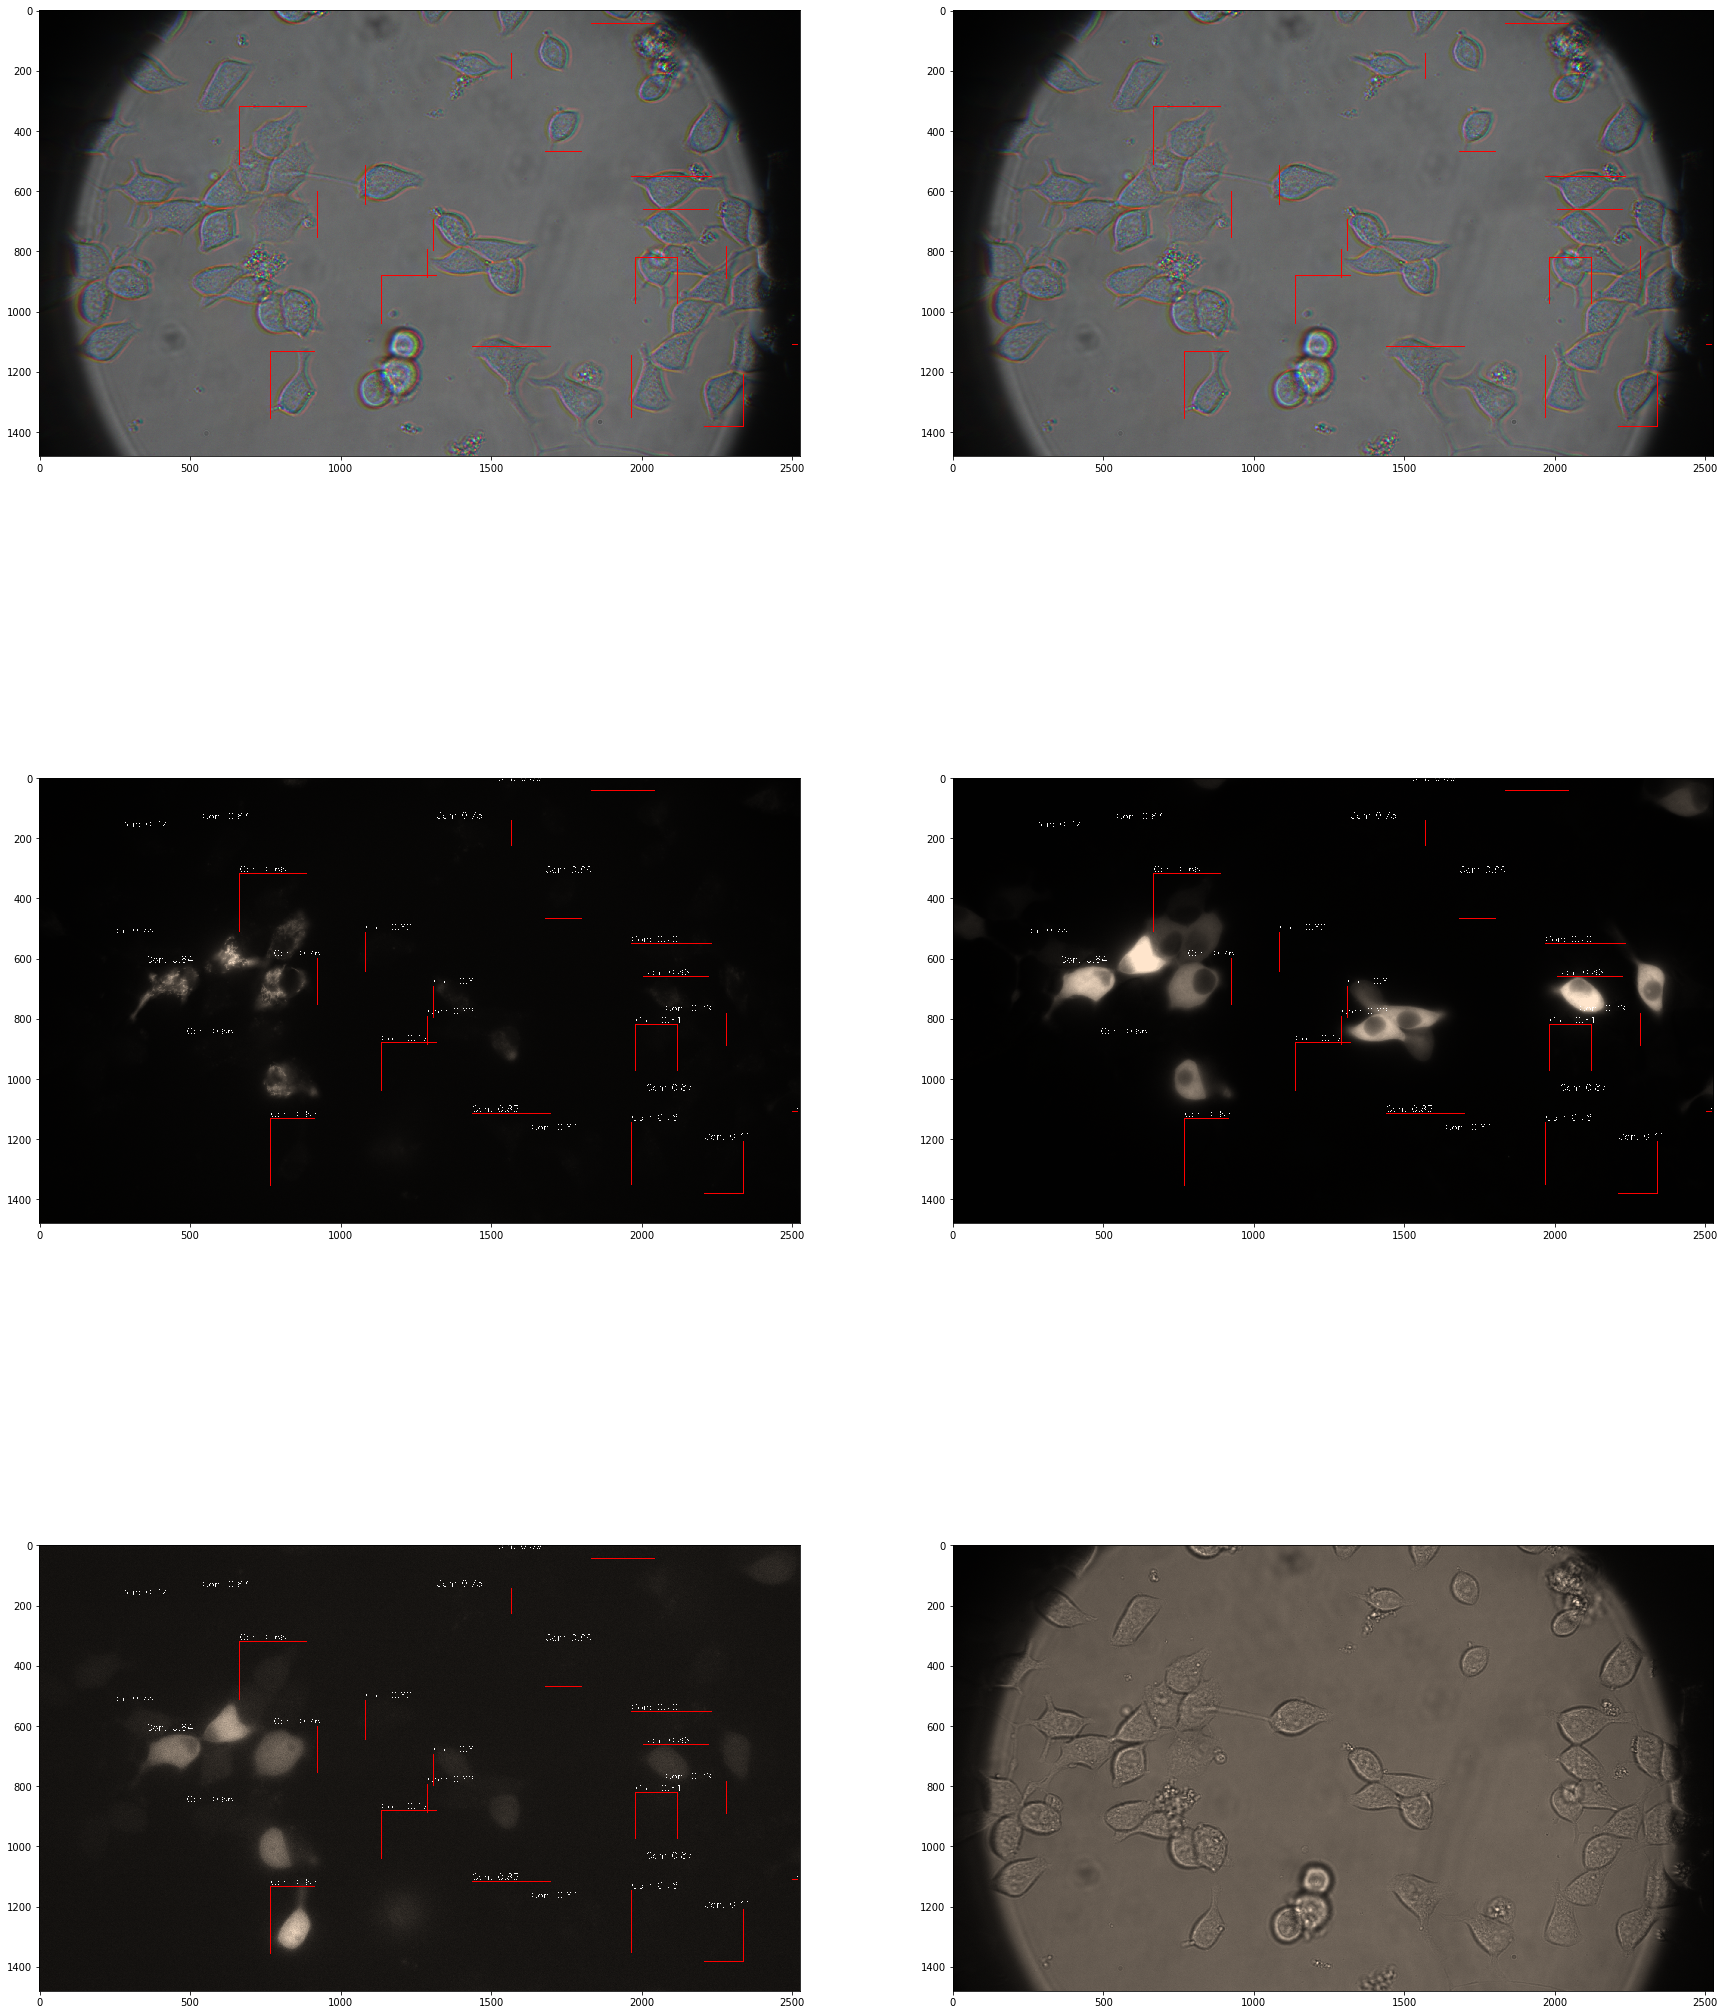

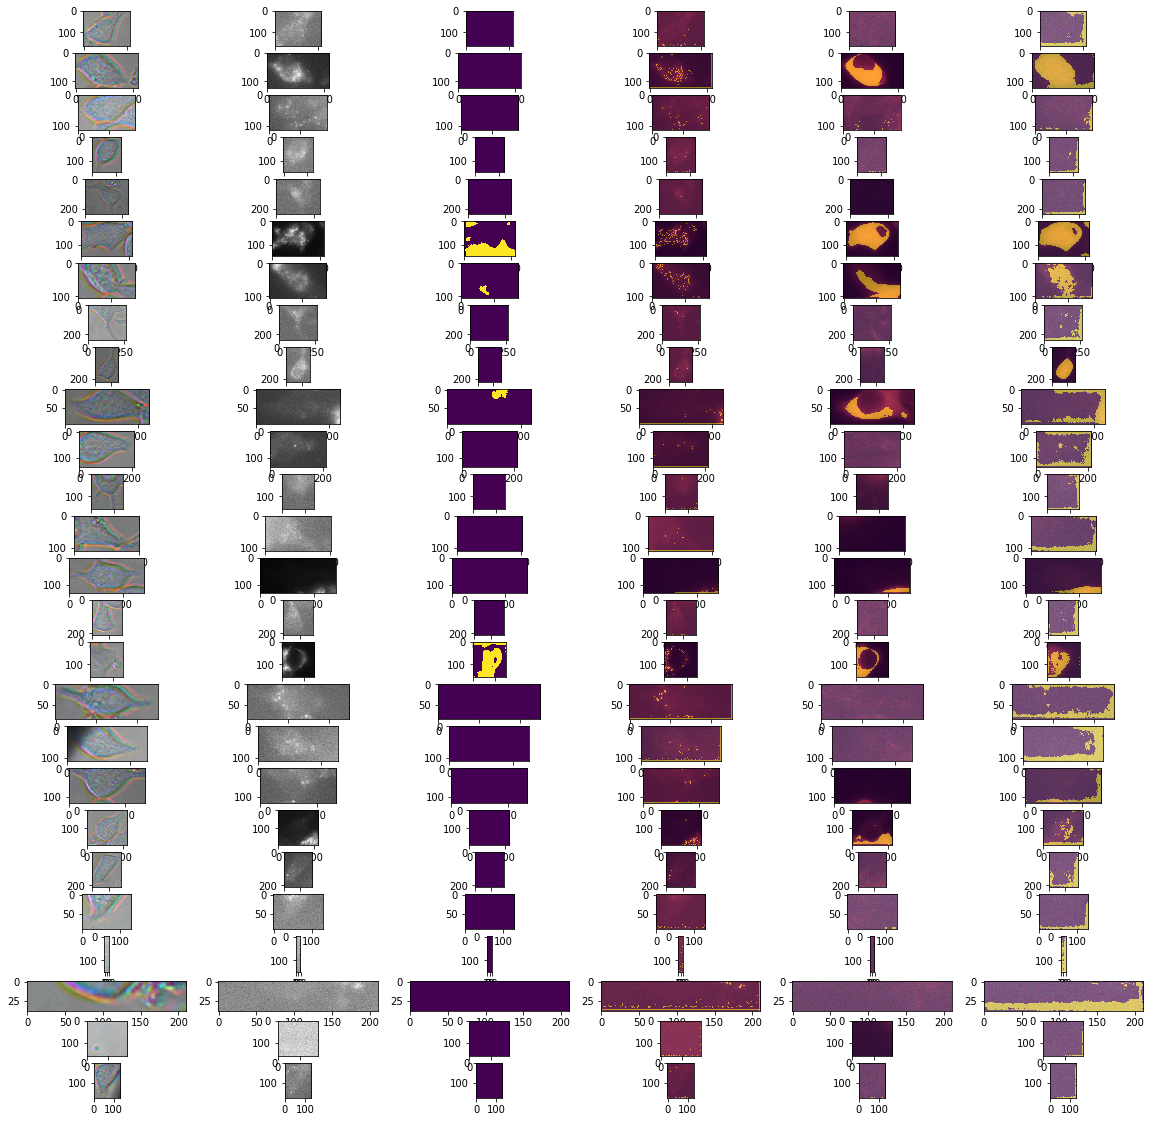

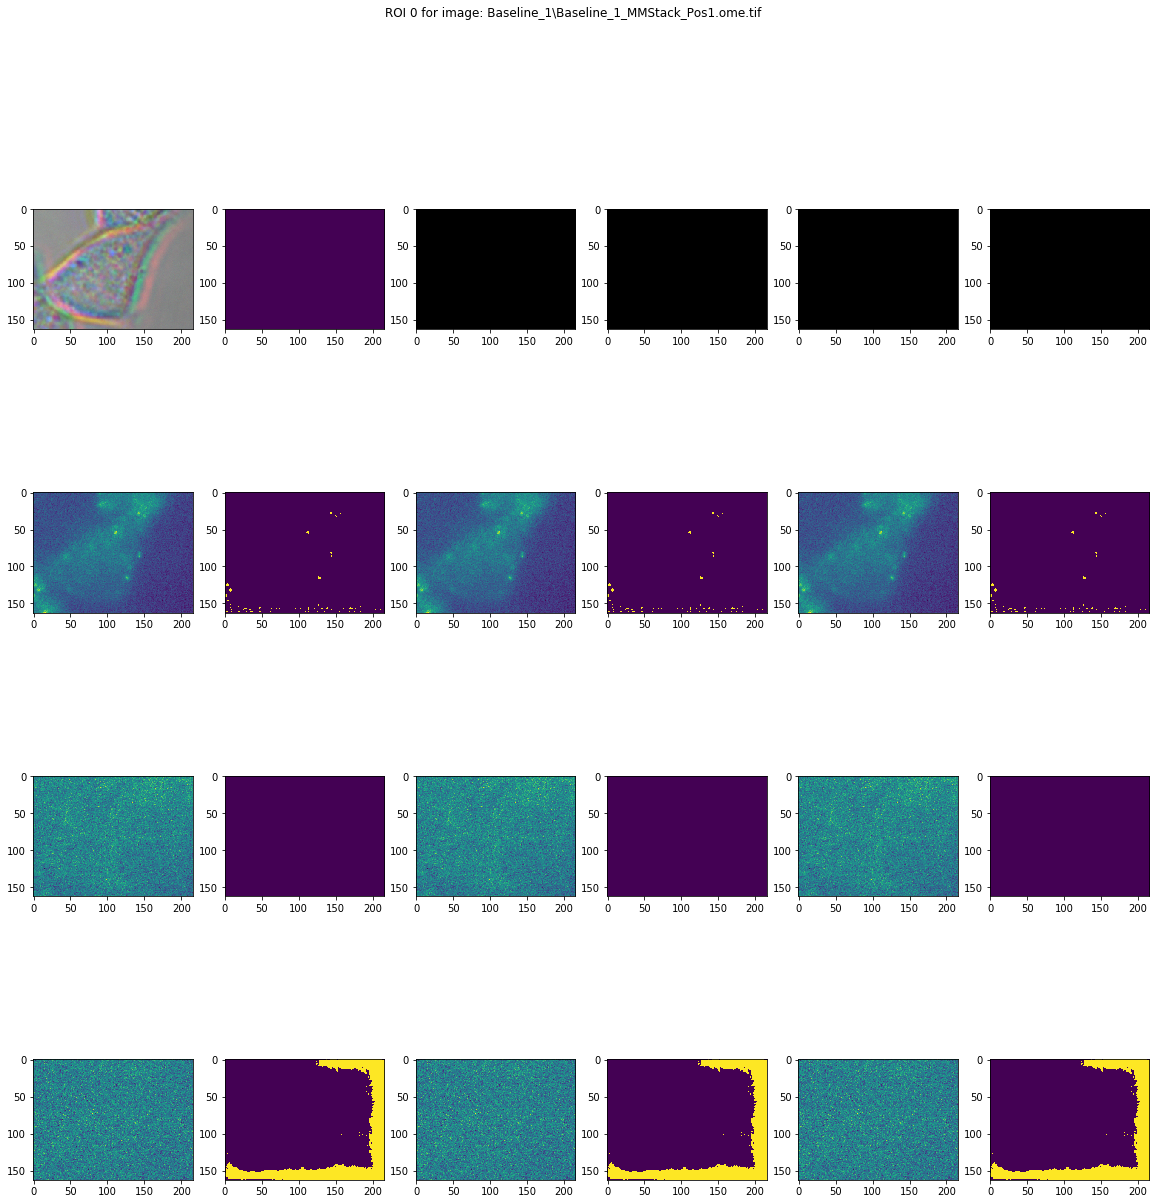

In [8]:
experiment, folder, file = Parameters.choose_file(exp_idx = 0, folder_idx = 0, file_idx = 1)
debug_df, cache = Parameters.analyze_single_file(experiment, folder, file)

debug.output_debug_summary(cache)
debug.output_debug_ROIs(cache)
debug.output_debug_single_ROI(cache, 0)
debug.output_debug_images(cache)

"""Things in the debug cache:
Filename
Segmentation Images
Detection Image
ROI List
Cell Images
Subcellular Images
Cell Masks
Subcellular Masks
Premask Images



"""

In [13]:
import numpy as np
import imageio


seg_imgs = cache['Segmentation Images']    
det_image = cache['Detection Image']
roi_list = cache['ROI List']
cell_images = cache['Cell Images']
sub_images = cache['Subcellular Images']   #Shape [ROI][Colour][h:w:ch]
sub_segs = cache['Subcellular Segmentations']  #Shape [ROI][Colour][h:w:ch]
sub_masks = cache['Subcellular Masks']     #Shape [ROI][Colour][ch][h:w]
cell_masks = cache['Cell Masks']



data_folder = Parameters.data_path
debug_folder = data_folder/'Debug' ; debug_folder.mkdir(exist_ok = True, parents = True)
save_folder = debug_folder


CH = 0

"""Note, this only exports the first image of each set!!"""
for ROI_num in range(len(sub_images)):
    #Output the masks...
    output_folder = save_folder/'Masks' ; output_folder.mkdir(exist_ok = True, parents = True)
    mask_exp = cell_masks[ROI_num]
    
    
    
    #Output the subsegmentations...
    for colour_num in range(len(sub_images[ROI_num])):
        output_folder = save_folder/str(colour_num) ; output_folder.mkdir(exist_ok = True, parents = True)
        
        #export the subimages
        export_img = sub_images[ROI_num][colour_num][:,:,CH]
        stacked_img = np.dstack([export_img, export_img, export_img])
        imageio.imwrite(output_folder/f'ROI{ROI_num}.ome.tif', stacked_img)
        
        #export the masks (x255 to see them and edit them easily)
        sub_export = sub_masks[ROI_num][colour_num][CH]
        imageio.imwrite(output_folder/f'ROI{ROI_num}.png', sub_export.astype('uint8')*255)

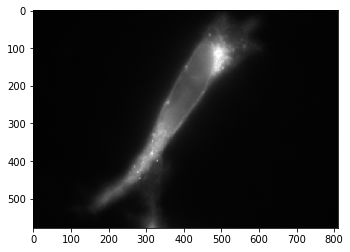

In [17]:
jpeg_export = (export_img/np.amax(export_img)*255).astype('uint8')
jpeg_export = np.dstack([jpeg_export,jpeg_export,jpeg_export])
plt.imshow(jpeg_export)

In [14]:
len(cell_masks)

3

(454, 530, 3)


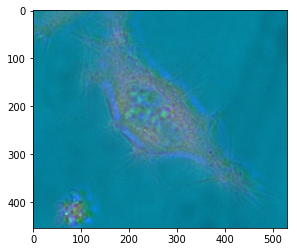

In [18]:
sub_export = cell_images[0]

plt.imshow(sub_export)
print(sub_export.shape)

## Explore the Output Dataframe

In [197]:
print (f"Number of Experiments is: {len(Parameters.experiments)}")

Number of Experiments is: 1


In [198]:
experiment_number = 0
for i, (name, experiments) in enumerate(Parameters.experiments.items()):
    if i == experiment_number:
        experiment = experiments
dataframe = experiment.results

In [199]:
#Select a file

files = experiment.results.groupby(pd.IndexSlice[0,-1,'Filepath']).any().index
filepath = files[0]
image_ROIs = experiment.results[experiment.results.loc[:, pd.IndexSlice[-1,-1,'Filepath']] == filepath]

print (filepath)

D:\[] ML Dataset\Datasets\2019-03-17 AD293 Dataset 24 Hours after Replating-Louise\2019-03-17 AD293 Dataset 24 Hours after Replating\Tester\Cyto-Mem-Mito [Cyto Mem Mito Br]\1_1\1_10_MMStack_Pos0.ome.tif


In [200]:
#Calculate the boxes
time = 0

bottom = np.array(image_ROIs[(time, -1, 'Y_Corner')])
left = np.array(image_ROIs[(time, -1, 'X_Corner')])
top = bottom + np.array(image_ROIs[(time, -1, 'Height')])
right = left + np.array(image_ROIs[(time, -1, 'Width')])

In [215]:
# Open the image
reader = imageio.get_reader(str(filepath))
img = open_image_channel(13, reader)*255
#img = img.astype('uint8')
img.shape
img

array([[2.817121, 2.490272, 2.782101, 2.618677, ..., 4.599222, 4.299611, 4.533074, 4.595331],
       [2.622568, 2.400778, 2.2607  , 2.466926, ..., 4.023346, 3.972763, 4.400778, 4.33463 ],
       [2.824903, 2.871595, 2.661479, 2.918288, ..., 4.63035 , 4.595331, 4.88716 , 3.937743],
       [2.202335, 2.832685, 2.494163, 2.40856 , ..., 4.494163, 3.957198, 5.011673, 3.867704],
       ...,
       [4.385214, 4.085603, 4.342412, 4.55642 , ..., 8.07393 , 7.392996, 7.357977, 7.474708],
       [4.178988, 4.501946, 3.859922, 3.859922, ..., 7.249027, 7.291829, 7.750973, 6.848249],
       [3.743191, 3.957198, 4.151751, 3.770428, ..., 7.050584, 7.307393, 7.237354, 7.533074],
       [3.859922, 4.400778, 4.22179 , 3.945525, ..., 8.077821, 7.291829, 6.560311, 6.595331]])